# AD_with_Plaques:1
# NCI_with_No_Plaques: 0

In [723]:

import tensorflow as tf
from gene_expression import *
from pathway_hierarchy import *
from utils import *
import torch

In [377]:
import os
import torch
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import argparse
from utils import *
from gene_expression import *
from pathway_hierarchy import *
import pandas as pd
import yaml
from custom_neural_network import *
from custom_fc_network import *
from datetime import datetime
import csv
import copy
import pickle
import random
random.seed(0)
np.random.seed(0)

path_config = 'config.yml'
model_dct = dict()

# Hook function
def hook_fn(module, input, output, layer_name):
    global model_dct
    input_list = [i.detach().cpu().numpy().tolist() for i in input]
    output_list = output.detach().cpu().numpy().tolist()
    
    # If the layer name is not in the dictionary, create a new list for it
    if layer_name not in model_dct:
        model_dct[layer_name] = []

    # Append the activations to the corresponding layer list
    model_dct[layer_name].append({
        'input': input_list,
        'output': output_list
    })



# Define the file path for the CSV file
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class TabularDataset(Dataset):
    def __init__(self, count_matrix, label):
        # Read the CSV file
        self.data = count_matrix
        # Separate features and target
        self.features = self.data.values
        self.target = label.values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get features and target for a given index
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        return features, target

def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predicted_list = []
    probability_list = []
    labels_list = []
    criterion = nn.BCEWithLogitsLoss()
    loss = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for features, labels in dataloader:
            outputs = model(features)
            #print(outputs)
            probability = torch.sigmoid(outputs.data)
            predicted = torch.round(torch.sigmoid(outputs.data))
            #print(outputs)
            #print(predicted)
            loss += criterion(outputs, labels)
            #_, predicted = torch.sigmoid(outputs.data)
            predicted_list.extend(predicted)
            labels_list.extend(labels)
            probability_list.extend(probability)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(total)
    accuracy = 100 * correct / total
    return accuracy, loss, predicted_list, labels_list, probability_list

def save_model(model_nn,model_path, model_state_dict_path):
    
    model_nn.eval()
    torch.save(model_nn, model_path)
    torch.save(model_nn.state_dict(), model_state_dict_path)




def model_fc(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomfcNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/fc_training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            outputs = model_nn(batch_features)
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            loss = criterion(outputs, batch_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/fc_test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn



def model(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            
            
            optimizer.zero_grad()
            outputs = model_nn(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn


def load_config(config_file):
    with open(config_file, 'r') as file:
        return yaml.safe_load(file)


def main_file(path_config):

    '''parser = argparse.ArgumentParser(description='Sample application with config and argparse')
    parser.add_argument('--config', type=str, default='config.yml', help='Path to the configuration file')
    args = parser.parse_args()'''

    config = load_config(path_config)
    print(config)
    train = pd.read_csv(config['dataset']['train'],index_col=0)
    test = pd.read_csv(config['dataset']['test'],index_col=0)
    val = pd.read_csv(config['dataset']['val'],index_col=0)

    y_train = pd.read_csv(config['dataset']['y_train'])
    y_test = pd.read_csv(config['dataset']['y_test'])
    y_val = pd.read_csv(config['dataset']['y_val'])
  


    r_data_tmp = train.T
    q_data_tmp = test.T
    v_data_tmp = val.T
    r_label_tmp = y_train

    print('Getting Marker Genes.......')
    train_x, test_x, val_x, train_y = get_expression(r_data_tmp,
                                                q_data_tmp,
                                                v_data_tmp,
                                                r_label_tmp,
                                                thrh=config['gene_expression']['highly_expressed_threshold'],
                                                thrl=config['gene_expression']['lowly_expressed_threshold'],
                                                normalization=config['gene_expression']['normalization'],
                                                marker=config['gene_expression']['marker'])
    
    print('Getting Pathway Genes.........')
    pathway_genes = get_gene_pathways(config['pathways_network']['ensemble_pathway_relation'], species=config['pathways_network']['species'])


    print('Getting Masking.........')
    masking, masking_df, layers_node, train_x, test_x,val_x = get_masking(config['pathways_network']['pathway_names'],
                                                        pathway_genes,
                                                        config['pathways_network']['pathway_relation'],
                                                        train_x,
                                                        test_x,
                                                        val_x,
                                                        train_y,
                                                        config['pathways_network']['datatype'],
                                                        config['pathways_network']['species'],
                                                        config['pathways_network']['n_hidden_layer'])

    test_cell_id = list(test_x.T.index) 
    try:
        masking = list(masking.values())
        layers_node = list(layers_node.values())
    except:
        print('already_done')


    train_dataset = TabularDataset(train_x.T,train_y)
    val_dataset = TabularDataset(val_x.T,y_val)
    test_dataset = TabularDataset(test_x.T,y_test)  
    
    

    dataloader_params = {
    'batch_size': config['train']['batch_size'],
    'shuffle': False
    }

    train_dataloader = DataLoader(train_dataset,**dataloader_params)
    test_dataloader = DataLoader(test_dataset, **dataloader_params)
    val_dataloader = DataLoader(val_dataset,**dataloader_params)
    # Example of iterating through the DataLoader


    pred_y_df = pd.DataFrame(data=0, index=test_x.columns, columns=list(range(2, len(masking) + 2)))
    train_y_df = pd.DataFrame(data=0, index=train_x.columns, columns=list(range(2, len(masking) + 2)))
    model_dict_sparse = dict()
    model_dict_fc = dict()
    activation_output = {}
    now = datetime.now()

# Format the date as a string
    date_string = datetime_string = now.strftime("%Y_%m_%d_%H_%M_%S")

    try:
        os.makedirs(f'{config['model_output']['model_save_dir']}{date_string}')
    except:
        print(('...'))

   

    print('Training.........')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_sparse[output_layer] = model(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  

    print('tranining_fully_connected_layers:')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_fc[output_layer] = model_fc(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  
        
    new_parameter = {'date_string': date_string}
    config.update(new_parameter)
    save_path =   str(config['model_output']['model_save_dir'])+ date_string + '/config.yml'
    with open(save_path, 'w') as file:
        yaml.dump(config, file)

        
    for i in range(len(masking_df)):
        masking_df[i].to_csv(str(config['model_output']['model_save_dir'])+ date_string+ '/' +f'masking_df_{i}.csv')
    
   
        
    return model_dict_sparse, val_dataloader, test_dataloader, train_dataloader, train_x, train_y, val_x, y_val, test_x, y_test, config

   
model_dict_sparse, val_dataloader, test_dataloader, train_dataloader,train_x, train_y, val_x, y_val, test_x, y_test, config = main_file(path_config= path_config)
for j,i in model_dict_sparse.items():

# Assuming 'model' is your neural network
    torch.save(i.state_dict(), f'{config['model_output']['model_save_dir']}{config['date_string']}/model_{j}_state_dict_jupyter_notebook.pth')


for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}') 

{'dataset': {'train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv', 'test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv', 'val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv', 'y_train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv', 'y_test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv', 'y_val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'}, 'model_output': {'model_save_dir': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excito

/home/anwer/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training.........
Current sub-neural network has 1 hidden layers.
...


  2%|███▍                                                                                                                                                                         | 1/50 [00:00<00:18,  2.71it/s]

Epoch [1/50], Train Loss: 1.3804, Train_accuracy: 53.411430599929005, Val Loss: 0.6902, Val_accuracy: 53.439829605963794
Model saved.


  4%|██████▉                                                                                                                                                                      | 2/50 [00:01<00:36,  1.33it/s]

Epoch [2/50], Train Loss: 1.3753, Train_accuracy: 53.00674476393326, Val Loss: 0.6876, Val_accuracy: 53.14164004259851


  6%|██████████▍                                                                                                                                                                  | 3/50 [00:01<00:26,  1.75it/s]

Epoch [3/50], Train Loss: 1.3701, Train_accuracy: 55.05147319843805, Val Loss: 0.6851, Val_accuracy: 55.356762513312034
Model saved.


  8%|█████████████▊                                                                                                                                                               | 4/50 [00:02<00:22,  2.03it/s]

Epoch [4/50], Train Loss: 1.3647, Train_accuracy: 58.71494497692581, Val Loss: 0.6825, Val_accuracy: 59.211927582534614
Model saved.


 10%|█████████████████▎                                                                                                                                                           | 5/50 [00:02<00:20,  2.24it/s]

Epoch [5/50], Train Loss: 1.3591, Train_accuracy: 62.17252396166134, Val Loss: 0.6798, Val_accuracy: 62.705005324813634
Model saved.


 12%|████████████████████▊                                                                                                                                                        | 6/50 [00:03<00:28,  1.53it/s]

Epoch [6/50], Train Loss: 1.3533, Train_accuracy: 64.78523251686191, Val Loss: 0.6771, Val_accuracy: 64.66453674121406
Model saved.


 14%|████████████████████████▏                                                                                                                                                    | 7/50 [00:03<00:24,  1.78it/s]

Epoch [7/50], Train Loss: 1.3472, Train_accuracy: 65.88569400070998, Val Loss: 0.6742, Val_accuracy: 65.51650692225772
Model saved.


 16%|███████████████████████████▋                                                                                                                                                 | 8/50 [00:04<00:21,  2.00it/s]

Epoch [8/50], Train Loss: 1.3408, Train_accuracy: 66.39687610933618, Val Loss: 0.6711, Val_accuracy: 65.79339723109692
Model saved.


 18%|███████████████████████████████▏                                                                                                                                             | 9/50 [00:04<00:18,  2.19it/s]

Epoch [9/50], Train Loss: 1.3341, Train_accuracy: 66.42527511537097, Val Loss: 0.6679, Val_accuracy: 66.00638977635782
Model saved.


 20%|██████████████████████████████████▍                                                                                                                                         | 10/50 [00:05<00:25,  1.56it/s]

Epoch [10/50], Train Loss: 1.3271, Train_accuracy: 66.56727014554491, Val Loss: 0.6646, Val_accuracy: 65.98509052183174


 22%|█████████████████████████████████████▊                                                                                                                                      | 11/50 [00:06<00:21,  1.79it/s]

Epoch [11/50], Train Loss: 1.3199, Train_accuracy: 66.8157614483493, Val Loss: 0.6611, Val_accuracy: 66.09158679446219
Model saved.


 24%|█████████████████████████████████████████▎                                                                                                                                  | 12/50 [00:06<00:18,  2.01it/s]

Epoch [12/50], Train Loss: 1.3125, Train_accuracy: 66.99325523606674, Val Loss: 0.6576, Val_accuracy: 66.02768903088392


 26%|████████████████████████████████████████████▋                                                                                                                               | 13/50 [00:06<00:17,  2.17it/s]

Epoch [13/50], Train Loss: 1.3049, Train_accuracy: 67.36244231451899, Val Loss: 0.6540, Val_accuracy: 66.24068157614484
Model saved.


 28%|████████████████████████████████████████████████▏                                                                                                                           | 14/50 [00:07<00:23,  1.56it/s]

Epoch [14/50], Train Loss: 1.2972, Train_accuracy: 67.6109336173234, Val Loss: 0.6504, Val_accuracy: 66.49627263045794
Model saved.


 30%|███████████████████████████████████████████████████▌                                                                                                                        | 15/50 [00:08<00:19,  1.80it/s]

Epoch [15/50], Train Loss: 1.2894, Train_accuracy: 67.62513312034079, Val Loss: 0.6467, Val_accuracy: 66.41107561235357


 32%|███████████████████████████████████████████████████████                                                                                                                     | 16/50 [00:08<00:17,  2.00it/s]

Epoch [16/50], Train Loss: 1.2815, Train_accuracy: 67.71033013844516, Val Loss: 0.6430, Val_accuracy: 66.5601703940362
Model saved.


 34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 17/50 [00:08<00:15,  2.17it/s]

Epoch [17/50], Train Loss: 1.2737, Train_accuracy: 67.83812566560171, Val Loss: 0.6393, Val_accuracy: 66.70926517571885
Model saved.


 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 18/50 [00:09<00:20,  1.58it/s]

Epoch [18/50], Train Loss: 1.2659, Train_accuracy: 68.02981895633653, Val Loss: 0.6356, Val_accuracy: 66.90095846645367
Model saved.


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 19/50 [00:10<00:17,  1.80it/s]

Epoch [19/50], Train Loss: 1.2581, Train_accuracy: 68.14341498047568, Val Loss: 0.6320, Val_accuracy: 67.0713525026624
Model saved.


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 20/50 [00:10<00:15,  2.00it/s]

Epoch [20/50], Train Loss: 1.2504, Train_accuracy: 68.29250976215832, Val Loss: 0.6284, Val_accuracy: 67.09265175718849
Model saved.


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                   | 21/50 [00:11<00:13,  2.16it/s]

Epoch [21/50], Train Loss: 1.2429, Train_accuracy: 68.51970181043663, Val Loss: 0.6249, Val_accuracy: 67.39084132055378
Model saved.


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 22/50 [00:12<00:17,  1.56it/s]

Epoch [22/50], Train Loss: 1.2355, Train_accuracy: 68.5977990770323, Val Loss: 0.6214, Val_accuracy: 67.49733759318424
Model saved.


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 23/50 [00:12<00:15,  1.78it/s]

Epoch [23/50], Train Loss: 1.2282, Train_accuracy: 68.79659211927583, Val Loss: 0.6180, Val_accuracy: 67.92332268370608
Model saved.


 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24/50 [00:12<00:13,  1.97it/s]

Epoch [24/50], Train Loss: 1.2211, Train_accuracy: 69.02378416755414, Val Loss: 0.6147, Val_accuracy: 68.15761448349308
Model saved.


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25/50 [00:13<00:11,  2.13it/s]

Epoch [25/50], Train Loss: 1.2142, Train_accuracy: 69.21547745828896, Val Loss: 0.6115, Val_accuracy: 68.43450479233226
Model saved.


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 26/50 [00:14<00:15,  1.56it/s]

Epoch [26/50], Train Loss: 1.2074, Train_accuracy: 69.49946751863685, Val Loss: 0.6084, Val_accuracy: 69.07348242811501
Model saved.


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 27/50 [00:14<00:12,  1.78it/s]

Epoch [27/50], Train Loss: 1.2007, Train_accuracy: 69.73375931842385, Val Loss: 0.6053, Val_accuracy: 69.30777422790203
Model saved.


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 28/50 [00:15<00:11,  1.98it/s]

Epoch [28/50], Train Loss: 1.1943, Train_accuracy: 69.91125310614129, Val Loss: 0.6023, Val_accuracy: 69.6059637912673
Model saved.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 29/50 [00:15<00:09,  2.15it/s]

Epoch [29/50], Train Loss: 1.1879, Train_accuracy: 70.14554490592829, Val Loss: 0.5994, Val_accuracy: 69.96805111821087
Model saved.


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/50 [00:16<00:12,  1.58it/s]

Epoch [30/50], Train Loss: 1.1818, Train_accuracy: 70.34433794817181, Val Loss: 0.5965, Val_accuracy: 70.33013844515442
Model saved.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 31/50 [00:16<00:10,  1.80it/s]

Epoch [31/50], Train Loss: 1.1757, Train_accuracy: 70.49343272985446, Val Loss: 0.5938, Val_accuracy: 70.52183173588925
Model saved.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32/50 [00:17<00:08,  2.00it/s]

Epoch [32/50], Train Loss: 1.1699, Train_accuracy: 70.81292154774583, Val Loss: 0.5911, Val_accuracy: 70.8839190628328
Model saved.


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33/50 [00:17<00:07,  2.18it/s]

Epoch [33/50], Train Loss: 1.1641, Train_accuracy: 71.1466098686546, Val Loss: 0.5884, Val_accuracy: 71.16080937167199
Model saved.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 34/50 [00:18<00:10,  1.58it/s]

Epoch [34/50], Train Loss: 1.1585, Train_accuracy: 71.43769968051119, Val Loss: 0.5859, Val_accuracy: 71.28860489882854
Model saved.


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 35/50 [00:19<00:08,  1.80it/s]

Epoch [35/50], Train Loss: 1.1531, Train_accuracy: 71.61519346822861, Val Loss: 0.5834, Val_accuracy: 71.54419595314164
Model saved.


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 36/50 [00:19<00:06,  2.00it/s]

Epoch [36/50], Train Loss: 1.1478, Train_accuracy: 71.78558750443734, Val Loss: 0.5810, Val_accuracy: 71.71458998935037
Model saved.


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 37/50 [00:19<00:06,  2.16it/s]

Epoch [37/50], Train Loss: 1.1426, Train_accuracy: 72.02697905573305, Val Loss: 0.5786, Val_accuracy: 71.97018104366347
Model saved.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 38/50 [00:20<00:07,  1.58it/s]

Epoch [38/50], Train Loss: 1.1376, Train_accuracy: 72.12637557685481, Val Loss: 0.5764, Val_accuracy: 72.16187433439829
Model saved.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 39/50 [00:21<00:06,  1.80it/s]

Epoch [39/50], Train Loss: 1.1327, Train_accuracy: 72.26127085552005, Val Loss: 0.5742, Val_accuracy: 72.26837060702876
Model saved.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 40/50 [00:21<00:04,  2.00it/s]

Epoch [40/50], Train Loss: 1.1280, Train_accuracy: 72.55236066737665, Val Loss: 0.5721, Val_accuracy: 72.41746538871139
Model saved.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 41/50 [00:21<00:04,  2.16it/s]

Epoch [41/50], Train Loss: 1.1234, Train_accuracy: 72.57365992190273, Val Loss: 0.5700, Val_accuracy: 72.69435569755059
Model saved.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 42/50 [00:22<00:05,  1.58it/s]

Epoch [42/50], Train Loss: 1.1189, Train_accuracy: 72.75115370962017, Val Loss: 0.5681, Val_accuracy: 72.77955271565496
Model saved.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 43/50 [00:23<00:03,  1.80it/s]

Epoch [43/50], Train Loss: 1.1145, Train_accuracy: 72.83635072772454, Val Loss: 0.5662, Val_accuracy: 72.84345047923323
Model saved.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 44/50 [00:23<00:03,  2.00it/s]

Epoch [44/50], Train Loss: 1.1103, Train_accuracy: 72.90734824281151, Val Loss: 0.5643, Val_accuracy: 72.94994675186368
Model saved.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 45/50 [00:24<00:02,  2.17it/s]

Epoch [45/50], Train Loss: 1.1061, Train_accuracy: 72.99254526091586, Val Loss: 0.5626, Val_accuracy: 72.97124600638978
Model saved.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 46/50 [00:25<00:02,  1.58it/s]

Epoch [46/50], Train Loss: 1.1021, Train_accuracy: 73.05644302449414, Val Loss: 0.5609, Val_accuracy: 73.05644302449414
Model saved.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 47/50 [00:25<00:01,  1.80it/s]

Epoch [47/50], Train Loss: 1.0982, Train_accuracy: 73.29073482428115, Val Loss: 0.5592, Val_accuracy: 73.20553780617678
Model saved.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:25<00:00,  2.00it/s]

Epoch [48/50], Train Loss: 1.0944, Train_accuracy: 73.4398296059638, Val Loss: 0.5576, Val_accuracy: 73.29073482428115
Model saved.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:26<00:00,  2.16it/s]

Epoch [49/50], Train Loss: 1.0906, Train_accuracy: 73.63862264820732, Val Loss: 0.5561, Val_accuracy: 73.46112886048988
Model saved.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.83it/s]

Epoch [50/50], Train Loss: 1.0870, Train_accuracy: 73.79481718139866, Val Loss: 0.5546, Val_accuracy: 73.56762513312034
Model saved.


Test Accucary 72.91311754684838
Current sub-neural network has 2 hidden layers.
...


  2%|███▍                                                                                                                                                                         | 1/50 [00:00<00:18,  2.71it/s]

Epoch [1/50], Train Loss: 1.3859, Train_accuracy: 50.159744408945684, Val Loss: 0.6929, Val_accuracy: 49.77635782747604
Model saved.


  4%|██████▉                                                                                                                                                                      | 2/50 [00:00<00:17,  2.72it/s]

Epoch [2/50], Train Loss: 1.3855, Train_accuracy: 54.142705005324814, Val Loss: 0.6928, Val_accuracy: 53.908413205537805
Model saved.


  6%|██████████▍                                                                                                                                                                  | 3/50 [00:01<00:32,  1.46it/s]

Epoch [3/50], Train Loss: 1.3852, Train_accuracy: 62.56301029463969, Val Loss: 0.6926, Val_accuracy: 62.74760383386582
Model saved.


  8%|█████████████▊                                                                                                                                                               | 4/50 [00:02<00:25,  1.78it/s]

Epoch [4/50], Train Loss: 1.3848, Train_accuracy: 64.70003549875754, Val Loss: 0.6924, Val_accuracy: 64.89882854100107
Model saved.


 10%|█████████████████▎                                                                                                                                                           | 5/50 [00:02<00:22,  2.04it/s]

Epoch [5/50], Train Loss: 1.3844, Train_accuracy: 64.18885339013134, Val Loss: 0.6922, Val_accuracy: 63.85516506922258


 12%|████████████████████▊                                                                                                                                                        | 6/50 [00:02<00:19,  2.25it/s]

Epoch [6/50], Train Loss: 1.3839, Train_accuracy: 63.59957401490948, Val Loss: 0.6920, Val_accuracy: 63.36528221512247


 14%|████████████████████████▏                                                                                                                                                    | 7/50 [00:03<00:27,  1.55it/s]

Epoch [7/50], Train Loss: 1.3833, Train_accuracy: 62.98189563365282, Val Loss: 0.6917, Val_accuracy: 62.87539936102237


 16%|███████████████████████████▋                                                                                                                                                 | 8/50 [00:04<00:23,  1.80it/s]

Epoch [8/50], Train Loss: 1.3827, Train_accuracy: 62.17962371317004, Val Loss: 0.6914, Val_accuracy: 61.87433439829606


 18%|███████████████████████████████▏                                                                                                                                             | 9/50 [00:04<00:20,  2.03it/s]

Epoch [9/50], Train Loss: 1.3820, Train_accuracy: 61.61874334398296, Val Loss: 0.6910, Val_accuracy: 61.256656017039404


 20%|██████████████████████████████████▍                                                                                                                                         | 10/50 [00:05<00:18,  2.20it/s]

Epoch [10/50], Train Loss: 1.3813, Train_accuracy: 61.178558750443734, Val Loss: 0.6906, Val_accuracy: 61.150159744408946


 22%|█████████████████████████████████████▊                                                                                                                                      | 11/50 [00:06<00:24,  1.57it/s]

Epoch [11/50], Train Loss: 1.3804, Train_accuracy: 61.06496272630458, Val Loss: 0.6902, Val_accuracy: 60.85197018104366


 24%|█████████████████████████████████████████▎                                                                                                                                  | 12/50 [00:06<00:20,  1.81it/s]

Epoch [12/50], Train Loss: 1.3794, Train_accuracy: 61.19275825346113, Val Loss: 0.6897, Val_accuracy: 60.894568690095845


 26%|████████████████████████████████████████████▋                                                                                                                               | 13/50 [00:06<00:18,  2.00it/s]

Epoch [13/50], Train Loss: 1.3783, Train_accuracy: 61.16435924742634, Val Loss: 0.6892, Val_accuracy: 61.0010649627263


 28%|████████████████████████████████████████████████▏                                                                                                                           | 14/50 [00:07<00:16,  2.17it/s]

Epoch [14/50], Train Loss: 1.3771, Train_accuracy: 61.483848065317716, Val Loss: 0.6886, Val_accuracy: 61.128860489882854


 30%|███████████████████████████████████████████████████▌                                                                                                                        | 15/50 [00:08<00:22,  1.57it/s]

Epoch [15/50], Train Loss: 1.3757, Train_accuracy: 61.668441604543844, Val Loss: 0.6879, Val_accuracy: 61.21405750798722


 32%|███████████████████████████████████████████████████████                                                                                                                     | 16/50 [00:08<00:18,  1.79it/s]

Epoch [16/50], Train Loss: 1.3742, Train_accuracy: 61.89563365282215, Val Loss: 0.6872, Val_accuracy: 61.46964856230032


 34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 17/50 [00:08<00:16,  2.01it/s]

Epoch [17/50], Train Loss: 1.3726, Train_accuracy: 62.087326943556974, Val Loss: 0.6864, Val_accuracy: 61.83173588924387


 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 18/50 [00:09<00:14,  2.18it/s]

Epoch [18/50], Train Loss: 1.3708, Train_accuracy: 62.48491302804402, Val Loss: 0.6855, Val_accuracy: 62.2790202342918


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 19/50 [00:10<00:19,  1.57it/s]

Epoch [19/50], Train Loss: 1.3688, Train_accuracy: 62.87539936102237, Val Loss: 0.6845, Val_accuracy: 62.832800851970184


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 20/50 [00:10<00:16,  1.81it/s]

Epoch [20/50], Train Loss: 1.3667, Train_accuracy: 63.2942847000355, Val Loss: 0.6835, Val_accuracy: 63.322683706070286


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                   | 21/50 [00:11<00:14,  2.03it/s]

Epoch [21/50], Train Loss: 1.3644, Train_accuracy: 63.635072772452965, Val Loss: 0.6824, Val_accuracy: 63.5356762513312


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 22/50 [00:11<00:12,  2.20it/s]

Epoch [22/50], Train Loss: 1.3619, Train_accuracy: 64.01845935392261, Val Loss: 0.6811, Val_accuracy: 63.72736954206603


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 23/50 [00:11<00:11,  2.34it/s]

Epoch [23/50], Train Loss: 1.3591, Train_accuracy: 64.47994320198794, Val Loss: 0.6798, Val_accuracy: 63.940362087326946


 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24/50 [00:12<00:15,  1.63it/s]

Epoch [24/50], Train Loss: 1.3562, Train_accuracy: 64.84913028044018, Val Loss: 0.6784, Val_accuracy: 64.25985090521831


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25/50 [00:13<00:13,  1.85it/s]

Epoch [25/50], Train Loss: 1.3531, Train_accuracy: 65.19701810436635, Val Loss: 0.6769, Val_accuracy: 64.83493077742278


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 26/50 [00:13<00:11,  2.05it/s]

Epoch [26/50], Train Loss: 1.3497, Train_accuracy: 65.53070642527511, Val Loss: 0.6753, Val_accuracy: 65.21831735889243
Model saved.


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 27/50 [00:13<00:10,  2.21it/s]

Epoch [27/50], Train Loss: 1.3462, Train_accuracy: 65.77209797657082, Val Loss: 0.6736, Val_accuracy: 65.3248136315229
Model saved.


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 28/50 [00:15<00:14,  1.56it/s]

Epoch [28/50], Train Loss: 1.3424, Train_accuracy: 66.0844870429535, Val Loss: 0.6718, Val_accuracy: 65.49520766773163
Model saved.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 29/50 [00:15<00:11,  1.80it/s]

Epoch [29/50], Train Loss: 1.3385, Train_accuracy: 66.29037983670571, Val Loss: 0.6699, Val_accuracy: 65.51650692225772
Model saved.


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/50 [00:15<00:09,  2.01it/s]

Epoch [30/50], Train Loss: 1.3343, Train_accuracy: 66.63116790912318, Val Loss: 0.6679, Val_accuracy: 65.580404685836
Model saved.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 31/50 [00:16<00:08,  2.18it/s]

Epoch [31/50], Train Loss: 1.3300, Train_accuracy: 66.69506567270146, Val Loss: 0.6659, Val_accuracy: 65.53780617678382


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32/50 [00:17<00:11,  1.57it/s]

Epoch [32/50], Train Loss: 1.3254, Train_accuracy: 66.71636492722754, Val Loss: 0.6637, Val_accuracy: 65.43130990415335


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33/50 [00:17<00:09,  1.80it/s]

Epoch [33/50], Train Loss: 1.3208, Train_accuracy: 66.75896343627973, Val Loss: 0.6615, Val_accuracy: 65.60170394036209
Model saved.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 34/50 [00:17<00:08,  2.00it/s]

Epoch [34/50], Train Loss: 1.3159, Train_accuracy: 66.92935747248846, Val Loss: 0.6592, Val_accuracy: 65.75079872204473
Model saved.


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 35/50 [00:18<00:06,  2.18it/s]

Epoch [35/50], Train Loss: 1.3109, Train_accuracy: 66.96485623003196, Val Loss: 0.6568, Val_accuracy: 65.70820021299255


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 36/50 [00:19<00:08,  1.58it/s]

Epoch [36/50], Train Loss: 1.3059, Train_accuracy: 67.0713525026624, Val Loss: 0.6544, Val_accuracy: 65.89989350372737
Model saved.


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 37/50 [00:19<00:07,  1.80it/s]

Epoch [37/50], Train Loss: 1.3007, Train_accuracy: 67.12815051473198, Val Loss: 0.6519, Val_accuracy: 66.02768903088392
Model saved.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 38/50 [00:20<00:05,  2.00it/s]

Epoch [38/50], Train Loss: 1.2954, Train_accuracy: 67.16364927227546, Val Loss: 0.6495, Val_accuracy: 66.13418530351437
Model saved.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 39/50 [00:20<00:05,  2.17it/s]

Epoch [39/50], Train Loss: 1.2900, Train_accuracy: 67.26304579339723, Val Loss: 0.6469, Val_accuracy: 66.3045793397231
Model saved.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 40/50 [00:21<00:06,  1.57it/s]

Epoch [40/50], Train Loss: 1.2847, Train_accuracy: 67.3411430599929, Val Loss: 0.6444, Val_accuracy: 66.3045793397231


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 41/50 [00:21<00:05,  1.80it/s]

Epoch [41/50], Train Loss: 1.2792, Train_accuracy: 67.41924032658856, Val Loss: 0.6418, Val_accuracy: 66.47497337593184
Model saved.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 42/50 [00:22<00:03,  2.01it/s]

Epoch [42/50], Train Loss: 1.2738, Train_accuracy: 67.46183883564075, Val Loss: 0.6393, Val_accuracy: 66.51757188498402
Model saved.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 43/50 [00:22<00:03,  2.17it/s]

Epoch [43/50], Train Loss: 1.2683, Train_accuracy: 67.6109336173234, Val Loss: 0.6367, Val_accuracy: 66.68796592119276
Model saved.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 44/50 [00:23<00:03,  1.56it/s]

Epoch [44/50], Train Loss: 1.2629, Train_accuracy: 67.81682641107561, Val Loss: 0.6342, Val_accuracy: 66.75186368477104
Model saved.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 45/50 [00:24<00:02,  1.78it/s]

Epoch [45/50], Train Loss: 1.2574, Train_accuracy: 67.97302094426695, Val Loss: 0.6317, Val_accuracy: 66.90095846645367
Model saved.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 46/50 [00:24<00:02,  1.96it/s]

Epoch [46/50], Train Loss: 1.2520, Train_accuracy: 68.24281150159744, Val Loss: 0.6291, Val_accuracy: 67.13525026624067
Model saved.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 47/50 [00:24<00:01,  2.13it/s]

Epoch [47/50], Train Loss: 1.2466, Train_accuracy: 68.42740504082357, Val Loss: 0.6266, Val_accuracy: 67.36954206602769
Model saved.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:25<00:01,  1.53it/s]

Epoch [48/50], Train Loss: 1.2413, Train_accuracy: 68.6119985800497, Val Loss: 0.6242, Val_accuracy: 67.53993610223642
Model saved.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:26<00:00,  1.75it/s]

Epoch [49/50], Train Loss: 1.2360, Train_accuracy: 68.73979410720625, Val Loss: 0.6217, Val_accuracy: 67.8594249201278
Model saved.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.88it/s]

Epoch [50/50], Train Loss: 1.2308, Train_accuracy: 68.83209087681931, Val Loss: 0.6193, Val_accuracy: 68.00851970181044
Model saved.


Test Accucary 68.82453151618398
Current sub-neural network has 3 hidden layers.
...


  2%|███▍                                                                                                                                                                         | 1/50 [00:01<00:52,  1.07s/it]

Epoch [1/50], Train Loss: 1.3868, Train_accuracy: 50.17394391196308, Val Loss: 0.6936, Val_accuracy: 49.75505857294995
Model saved.


  4%|██████▉                                                                                                                                                                      | 2/50 [00:01<00:31,  1.51it/s]

Epoch [2/50], Train Loss: 1.3867, Train_accuracy: 50.17394391196308, Val Loss: 0.6936, Val_accuracy: 49.75505857294995


  6%|██████████▍                                                                                                                                                                  | 3/50 [00:01<00:25,  1.88it/s]

Epoch [3/50], Train Loss: 1.3866, Train_accuracy: 50.17394391196308, Val Loss: 0.6935, Val_accuracy: 49.75505857294995


  8%|█████████████▊                                                                                                                                                               | 4/50 [00:02<00:21,  2.11it/s]

Epoch [4/50], Train Loss: 1.3865, Train_accuracy: 50.17394391196308, Val Loss: 0.6935, Val_accuracy: 49.75505857294995


 10%|█████████████████▎                                                                                                                                                           | 5/50 [00:03<00:31,  1.45it/s]

Epoch [5/50], Train Loss: 1.3864, Train_accuracy: 50.17394391196308, Val Loss: 0.6934, Val_accuracy: 49.75505857294995


 12%|████████████████████▊                                                                                                                                                        | 6/50 [00:03<00:25,  1.70it/s]

Epoch [6/50], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6934, Val_accuracy: 49.75505857294995


 14%|████████████████████████▏                                                                                                                                                    | 7/50 [00:04<00:22,  1.93it/s]

Epoch [7/50], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


 16%|███████████████████████████▋                                                                                                                                                 | 8/50 [00:04<00:19,  2.10it/s]

Epoch [8/50], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 18%|███████████████████████████████▏                                                                                                                                             | 9/50 [00:05<00:27,  1.51it/s]

Epoch [9/50], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 20%|██████████████████████████████████▍                                                                                                                                         | 10/50 [00:05<00:23,  1.73it/s]

Epoch [10/50], Train Loss: 1.3859, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 22%|█████████████████████████████████████▊                                                                                                                                      | 11/50 [00:06<00:20,  1.94it/s]

Epoch [11/50], Train Loss: 1.3858, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 24%|█████████████████████████████████████████▎                                                                                                                                  | 12/50 [00:06<00:18,  2.10it/s]

Epoch [12/50], Train Loss: 1.3856, Train_accuracy: 50.17394391196308, Val Loss: 0.6929, Val_accuracy: 49.75505857294995


 26%|████████████████████████████████████████████▋                                                                                                                               | 13/50 [00:07<00:24,  1.52it/s]

Epoch [13/50], Train Loss: 1.3854, Train_accuracy: 50.17394391196308, Val Loss: 0.6928, Val_accuracy: 49.75505857294995


 28%|████████████████████████████████████████████████▏                                                                                                                           | 14/50 [00:08<00:20,  1.74it/s]

Epoch [14/50], Train Loss: 1.3853, Train_accuracy: 50.17394391196308, Val Loss: 0.6927, Val_accuracy: 49.75505857294995


 30%|███████████████████████████████████████████████████▌                                                                                                                        | 15/50 [00:08<00:18,  1.93it/s]

Epoch [15/50], Train Loss: 1.3851, Train_accuracy: 50.17394391196308, Val Loss: 0.6926, Val_accuracy: 49.75505857294995


 32%|███████████████████████████████████████████████████████                                                                                                                     | 16/50 [00:08<00:16,  2.07it/s]

Epoch [16/50], Train Loss: 1.3848, Train_accuracy: 50.18814341498047, Val Loss: 0.6925, Val_accuracy: 49.818956336528224
Model saved.


 34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 17/50 [00:09<00:15,  2.19it/s]

Epoch [17/50], Train Loss: 1.3846, Train_accuracy: 50.905218317358894, Val Loss: 0.6924, Val_accuracy: 50.415335463258785
Model saved.


 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 18/50 [00:10<00:20,  1.54it/s]

Epoch [18/50], Train Loss: 1.3843, Train_accuracy: 54.994675186368475, Val Loss: 0.6922, Val_accuracy: 54.67518636847711
Model saved.


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 19/50 [00:10<00:17,  1.74it/s]

Epoch [19/50], Train Loss: 1.3840, Train_accuracy: 60.972665956691515, Val Loss: 0.6921, Val_accuracy: 60.2555910543131
Model saved.


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 20/50 [00:11<00:15,  1.93it/s]

Epoch [20/50], Train Loss: 1.3836, Train_accuracy: 64.52964146254881, Val Loss: 0.6919, Val_accuracy: 63.74866879659212
Model saved.


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                   | 21/50 [00:11<00:13,  2.09it/s]

Epoch [21/50], Train Loss: 1.3832, Train_accuracy: 65.49520766773163, Val Loss: 0.6917, Val_accuracy: 64.3237486687966
Model saved.


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 22/50 [00:12<00:18,  1.51it/s]

Epoch [22/50], Train Loss: 1.3828, Train_accuracy: 64.98402555910543, Val Loss: 0.6914, Val_accuracy: 64.17465388711395


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 23/50 [00:13<00:15,  1.73it/s]

Epoch [23/50], Train Loss: 1.3823, Train_accuracy: 63.5427760028399, Val Loss: 0.6912, Val_accuracy: 63.045793397231094


 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24/50 [00:13<00:13,  1.92it/s]

Epoch [24/50], Train Loss: 1.3817, Train_accuracy: 62.32161874334398, Val Loss: 0.6909, Val_accuracy: 61.853035143769965


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25/50 [00:13<00:12,  2.08it/s]

Epoch [25/50], Train Loss: 1.3811, Train_accuracy: 61.37025204117856, Val Loss: 0.6906, Val_accuracy: 61.150159744408946


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 26/50 [00:14<00:15,  1.52it/s]

Epoch [26/50], Train Loss: 1.3804, Train_accuracy: 60.816471423500175, Val Loss: 0.6902, Val_accuracy: 60.87326943556975


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 27/50 [00:15<00:13,  1.73it/s]

Epoch [27/50], Train Loss: 1.3796, Train_accuracy: 60.60347887823926, Val Loss: 0.6899, Val_accuracy: 60.83067092651757


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 28/50 [00:15<00:11,  1.92it/s]

Epoch [28/50], Train Loss: 1.3787, Train_accuracy: 60.766773162939295, Val Loss: 0.6894, Val_accuracy: 61.0010649627263


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 29/50 [00:16<00:10,  2.09it/s]

Epoch [29/50], Train Loss: 1.3778, Train_accuracy: 60.96556620518282, Val Loss: 0.6890, Val_accuracy: 61.04366347177849


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/50 [00:17<00:13,  1.51it/s]

Epoch [30/50], Train Loss: 1.3768, Train_accuracy: 61.405750798722046, Val Loss: 0.6885, Val_accuracy: 61.46964856230032


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 31/50 [00:17<00:10,  1.73it/s]

Epoch [31/50], Train Loss: 1.3756, Train_accuracy: 61.853035143769965, Val Loss: 0.6879, Val_accuracy: 61.83173588924387


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32/50 [00:17<00:09,  1.92it/s]

Epoch [32/50], Train Loss: 1.3744, Train_accuracy: 62.392616258430955, Val Loss: 0.6873, Val_accuracy: 62.236421725239616


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33/50 [00:18<00:08,  2.08it/s]

Epoch [33/50], Train Loss: 1.3730, Train_accuracy: 62.83990060347888, Val Loss: 0.6867, Val_accuracy: 62.49201277955272


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 34/50 [00:19<00:10,  1.51it/s]

Epoch [34/50], Train Loss: 1.3715, Train_accuracy: 63.21618743343983, Val Loss: 0.6859, Val_accuracy: 62.61980830670927


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 35/50 [00:19<00:08,  1.73it/s]

Epoch [35/50], Train Loss: 1.3699, Train_accuracy: 63.57827476038339, Val Loss: 0.6852, Val_accuracy: 62.74760383386582


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 36/50 [00:20<00:07,  1.92it/s]

Epoch [36/50], Train Loss: 1.3682, Train_accuracy: 64.13915512957047, Val Loss: 0.6843, Val_accuracy: 63.024494142705


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 37/50 [00:20<00:06,  2.09it/s]

Epoch [37/50], Train Loss: 1.3663, Train_accuracy: 64.34504792332268, Val Loss: 0.6834, Val_accuracy: 63.25878594249201


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 38/50 [00:21<00:07,  1.51it/s]

Epoch [38/50], Train Loss: 1.3643, Train_accuracy: 64.7923322683706, Val Loss: 0.6825, Val_accuracy: 63.85516506922258


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 39/50 [00:21<00:06,  1.73it/s]

Epoch [39/50], Train Loss: 1.3621, Train_accuracy: 65.25381611643593, Val Loss: 0.6814, Val_accuracy: 64.08945686900958


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 40/50 [00:22<00:05,  1.91it/s]

Epoch [40/50], Train Loss: 1.3598, Train_accuracy: 65.42421015264466, Val Loss: 0.6803, Val_accuracy: 64.53674121405751
Model saved.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 41/50 [00:22<00:04,  2.06it/s]

Epoch [41/50], Train Loss: 1.3573, Train_accuracy: 65.49520766773163, Val Loss: 0.6791, Val_accuracy: 64.8136315228967
Model saved.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 42/50 [00:23<00:05,  1.49it/s]

Epoch [42/50], Train Loss: 1.3547, Train_accuracy: 65.5733049343273, Val Loss: 0.6779, Val_accuracy: 64.87752928647497
Model saved.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 43/50 [00:24<00:04,  1.70it/s]

Epoch [43/50], Train Loss: 1.3520, Train_accuracy: 65.85729499467519, Val Loss: 0.6765, Val_accuracy: 65.02662406815762
Model saved.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 44/50 [00:24<00:03,  1.89it/s]

Epoch [44/50], Train Loss: 1.3490, Train_accuracy: 66.26908058217963, Val Loss: 0.6751, Val_accuracy: 65.17571884984025
Model saved.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 45/50 [00:25<00:02,  2.06it/s]

Epoch [45/50], Train Loss: 1.3460, Train_accuracy: 66.41107561235357, Val Loss: 0.6737, Val_accuracy: 65.28221512247072
Model saved.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 46/50 [00:26<00:02,  1.49it/s]

Epoch [46/50], Train Loss: 1.3427, Train_accuracy: 66.45367412140575, Val Loss: 0.6721, Val_accuracy: 65.3248136315229
Model saved.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 47/50 [00:26<00:01,  1.71it/s]

Epoch [47/50], Train Loss: 1.3394, Train_accuracy: 66.38267660631878, Val Loss: 0.6705, Val_accuracy: 65.34611288604899
Model saved.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:26<00:01,  1.90it/s]

Epoch [48/50], Train Loss: 1.3359, Train_accuracy: 66.39687610933618, Val Loss: 0.6689, Val_accuracy: 65.36741214057508
Model saved.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:27<00:00,  2.06it/s]

Epoch [49/50], Train Loss: 1.3322, Train_accuracy: 66.53887113951012, Val Loss: 0.6671, Val_accuracy: 65.3248136315229


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.76it/s]

Epoch [50/50], Train Loss: 1.3284, Train_accuracy: 66.73056443024494, Val Loss: 0.6653, Val_accuracy: 65.45260915867945
Model saved.


Test Accucary 65.92844974446338
tranining_fully_connected_layers:
Current sub-neural network has 1 hidden layers.
...


  2%|███▍                                                                                                                                                                         | 1/50 [00:00<00:18,  2.71it/s]

Epoch [1/50], Train Loss: 1.6327, Train_accuracy: 49.85445509407171, Val Loss: 0.8098, Val_accuracy: 50.26624068157614
Model saved.


  4%|██████▉                                                                                                                                                                      | 2/50 [00:00<00:17,  2.72it/s]

Epoch [2/50], Train Loss: 2.0425, Train_accuracy: 50.17394391196308, Val Loss: 1.0301, Val_accuracy: 49.77635782747604


  6%|██████████▍                                                                                                                                                                  | 3/50 [00:01<00:32,  1.46it/s]

Epoch [3/50], Train Loss: 1.3423, Train_accuracy: 53.64572239971601, Val Loss: 0.6737, Val_accuracy: 52.843450479233226
Model saved.


  8%|█████████████▊                                                                                                                                                               | 4/50 [00:02<00:25,  1.78it/s]

Epoch [4/50], Train Loss: 1.4724, Train_accuracy: 50.23074192403266, Val Loss: 0.7322, Val_accuracy: 50.6283280085197


 10%|█████████████████▎                                                                                                                                                           | 5/50 [00:02<00:22,  2.03it/s]

Epoch [5/50], Train Loss: 1.4970, Train_accuracy: 50.003549875754345, Val Loss: 0.7443, Val_accuracy: 50.415335463258785


 12%|████████████████████▊                                                                                                                                                        | 6/50 [00:02<00:19,  2.22it/s]

Epoch [6/50], Train Loss: 1.3253, Train_accuracy: 56.07383741569045, Val Loss: 0.6619, Val_accuracy: 56.443024494142705
Model saved.


 14%|████████████████████████▏                                                                                                                                                    | 7/50 [00:03<00:18,  2.35it/s]

Epoch [7/50], Train Loss: 1.3020, Train_accuracy: 61.462548810791624, Val Loss: 0.6543, Val_accuracy: 60.40468583599574
Model saved.


 16%|███████████████████████████▋                                                                                                                                                 | 8/50 [00:04<00:26,  1.61it/s]

Epoch [8/50], Train Loss: 1.3607, Train_accuracy: 51.87788427405041, Val Loss: 0.6860, Val_accuracy: 50.905218317358894


 18%|███████████████████████████████▏                                                                                                                                             | 9/50 [00:04<00:21,  1.87it/s]

Epoch [9/50], Train Loss: 1.3379, Train_accuracy: 53.1629392971246, Val Loss: 0.6746, Val_accuracy: 52.01277955271566


 20%|██████████████████████████████████▍                                                                                                                                         | 10/50 [00:05<00:19,  2.06it/s]

Epoch [10/50], Train Loss: 1.2759, Train_accuracy: 65.5946041888534, Val Loss: 0.6421, Val_accuracy: 64.34504792332268
Model saved.


 22%|█████████████████████████████████████▊                                                                                                                                      | 11/50 [00:05<00:17,  2.24it/s]

Epoch [11/50], Train Loss: 1.2632, Train_accuracy: 67.73162939297124, Val Loss: 0.6338, Val_accuracy: 67.43343982960596
Model saved.


 24%|█████████████████████████████████████████▎                                                                                                                                  | 12/50 [00:06<00:23,  1.60it/s]

Epoch [12/50], Train Loss: 1.2796, Train_accuracy: 62.776002839900606, Val Loss: 0.6409, Val_accuracy: 63.10969116080937


 26%|████████████████████████████████████████████▋                                                                                                                               | 13/50 [00:06<00:20,  1.83it/s]

Epoch [13/50], Train Loss: 1.2673, Train_accuracy: 64.21725239616613, Val Loss: 0.6351, Val_accuracy: 64.40894568690096


 28%|████████████████████████████████████████████████▏                                                                                                                           | 14/50 [00:07<00:17,  2.04it/s]

Epoch [14/50], Train Loss: 1.2323, Train_accuracy: 69.08768193113241, Val Loss: 0.6193, Val_accuracy: 68.370607028754
Model saved.


 30%|███████████████████████████████████████████████████▌                                                                                                                        | 15/50 [00:07<00:15,  2.21it/s]

Epoch [15/50], Train Loss: 1.2191, Train_accuracy: 69.68406105786298, Val Loss: 0.6151, Val_accuracy: 68.90308839190628
Model saved.


 32%|███████████████████████████████████████████████████████                                                                                                                     | 16/50 [00:08<00:21,  1.58it/s]

Epoch [16/50], Train Loss: 1.2231, Train_accuracy: 67.76002839900603, Val Loss: 0.6188, Val_accuracy: 66.13418530351437


 34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 17/50 [00:08<00:18,  1.81it/s]

Epoch [17/50], Train Loss: 1.2045, Train_accuracy: 69.10898118565851, Val Loss: 0.6095, Val_accuracy: 67.98722044728434


 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 18/50 [00:09<00:15,  2.02it/s]

Epoch [18/50], Train Loss: 1.1814, Train_accuracy: 71.06851260205893, Val Loss: 0.5965, Val_accuracy: 70.35143769968052
Model saved.


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 19/50 [00:09<00:14,  2.19it/s]

Epoch [19/50], Train Loss: 1.1781, Train_accuracy: 70.29463968761094, Val Loss: 0.5936, Val_accuracy: 69.8828541001065


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 20/50 [00:10<00:19,  1.57it/s]

Epoch [20/50], Train Loss: 1.1665, Train_accuracy: 70.67802626908058, Val Loss: 0.5882, Val_accuracy: 70.20234291799787


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                   | 21/50 [00:11<00:16,  1.80it/s]

Epoch [21/50], Train Loss: 1.1488, Train_accuracy: 71.56549520766774, Val Loss: 0.5814, Val_accuracy: 70.94781682641107
Model saved.


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 22/50 [00:11<00:14,  2.00it/s]

Epoch [22/50], Train Loss: 1.1459, Train_accuracy: 71.30990415335464, Val Loss: 0.5819, Val_accuracy: 70.69222577209797


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 23/50 [00:11<00:12,  2.18it/s]

Epoch [23/50], Train Loss: 1.1329, Train_accuracy: 71.94888178913737, Val Loss: 0.5753, Val_accuracy: 71.26730564430245
Model saved.


 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24/50 [00:12<00:16,  1.56it/s]

Epoch [24/50], Train Loss: 1.1219, Train_accuracy: 72.23997160099397, Val Loss: 0.5684, Val_accuracy: 71.84238551650692
Model saved.


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25/50 [00:13<00:14,  1.78it/s]

Epoch [25/50], Train Loss: 1.1154, Train_accuracy: 72.55946041888534, Val Loss: 0.5650, Val_accuracy: 71.94888178913737
Model saved.


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 26/50 [00:13<00:12,  1.99it/s]

Epoch [26/50], Train Loss: 1.1025, Train_accuracy: 73.22683706070288, Val Loss: 0.5606, Val_accuracy: 72.63045793397231
Model saved.


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 27/50 [00:14<00:10,  2.17it/s]

Epoch [27/50], Train Loss: 1.0969, Train_accuracy: 73.37593184238551, Val Loss: 0.5595, Val_accuracy: 72.37486687965921


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 28/50 [00:15<00:14,  1.55it/s]

Epoch [28/50], Train Loss: 1.0848, Train_accuracy: 73.9297124600639, Val Loss: 0.5529, Val_accuracy: 73.1629392971246
Model saved.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 29/50 [00:15<00:11,  1.78it/s]

Epoch [29/50], Train Loss: 1.0776, Train_accuracy: 74.17820376286829, Val Loss: 0.5486, Val_accuracy: 73.50372736954206
Model saved.


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/50 [00:15<00:10,  2.00it/s]

Epoch [30/50], Train Loss: 1.0671, Train_accuracy: 74.70358537451189, Val Loss: 0.5446, Val_accuracy: 73.54632587859425
Model saved.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 31/50 [00:16<00:08,  2.17it/s]

Epoch [31/50], Train Loss: 1.0601, Train_accuracy: 74.9662761803337, Val Loss: 0.5427, Val_accuracy: 73.75931842385516
Model saved.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32/50 [00:17<00:11,  1.57it/s]

Epoch [32/50], Train Loss: 1.0501, Train_accuracy: 75.26446574369898, Val Loss: 0.5376, Val_accuracy: 74.05750798722045
Model saved.


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33/50 [00:17<00:09,  1.80it/s]

Epoch [33/50], Train Loss: 1.0428, Train_accuracy: 75.49165779197727, Val Loss: 0.5338, Val_accuracy: 74.12140575079871
Model saved.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 34/50 [00:17<00:07,  2.00it/s]

Epoch [34/50], Train Loss: 1.0341, Train_accuracy: 75.83954561590345, Val Loss: 0.5310, Val_accuracy: 74.84558040468583
Model saved.


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 35/50 [00:18<00:06,  2.18it/s]

Epoch [35/50], Train Loss: 1.0271, Train_accuracy: 76.12353567625134, Val Loss: 0.5285, Val_accuracy: 74.9520766773163
Model saved.


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 36/50 [00:19<00:08,  1.56it/s]

Epoch [36/50], Train Loss: 1.0193, Train_accuracy: 76.30812921547746, Val Loss: 0.5245, Val_accuracy: 74.76038338658147


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 37/50 [00:19<00:07,  1.79it/s]

Epoch [37/50], Train Loss: 1.0118, Train_accuracy: 76.50692225772097, Val Loss: 0.5219, Val_accuracy: 75.10117145899893
Model saved.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 38/50 [00:20<00:05,  2.00it/s]

Epoch [38/50], Train Loss: 1.0052, Train_accuracy: 76.85481008164714, Val Loss: 0.5201, Val_accuracy: 75.50585729499467
Model saved.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 39/50 [00:20<00:05,  2.19it/s]

Epoch [39/50], Train Loss: 0.9978, Train_accuracy: 76.79091231806886, Val Loss: 0.5167, Val_accuracy: 75.33546325878594


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 40/50 [00:21<00:06,  1.56it/s]

Epoch [40/50], Train Loss: 0.9910, Train_accuracy: 77.03940362087327, Val Loss: 0.5145, Val_accuracy: 75.61235356762514
Model saved.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 41/50 [00:21<00:05,  1.79it/s]

Epoch [41/50], Train Loss: 0.9847, Train_accuracy: 77.32339368122116, Val Loss: 0.5129, Val_accuracy: 75.6762513312034
Model saved.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 42/50 [00:22<00:03,  2.01it/s]

Epoch [42/50], Train Loss: 0.9779, Train_accuracy: 77.18139865104722, Val Loss: 0.5102, Val_accuracy: 75.54845580404685


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 43/50 [00:22<00:03,  2.18it/s]

Epoch [43/50], Train Loss: 0.9717, Train_accuracy: 77.35889243876464, Val Loss: 0.5086, Val_accuracy: 75.78274760383387
Model saved.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 44/50 [00:23<00:03,  1.58it/s]

Epoch [44/50], Train Loss: 0.9658, Train_accuracy: 77.51508697195598, Val Loss: 0.5070, Val_accuracy: 75.86794462193824
Model saved.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 45/50 [00:24<00:02,  1.81it/s]

Epoch [45/50], Train Loss: 0.9600, Train_accuracy: 77.6925807596734, Val Loss: 0.5050, Val_accuracy: 75.80404685835995


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 46/50 [00:24<00:01,  2.02it/s]

Epoch [46/50], Train Loss: 0.9547, Train_accuracy: 77.86297479588214, Val Loss: 0.5041, Val_accuracy: 76.10223642172524
Model saved.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 47/50 [00:24<00:01,  2.20it/s]

Epoch [47/50], Train Loss: 0.9493, Train_accuracy: 77.91267305644303, Val Loss: 0.5024, Val_accuracy: 75.97444089456869


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:25<00:01,  1.57it/s]

Epoch [48/50], Train Loss: 0.9443, Train_accuracy: 78.00496982605608, Val Loss: 0.5013, Val_accuracy: 76.2087326943557
Model saved.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:26<00:00,  1.80it/s]

Epoch [49/50], Train Loss: 0.9396, Train_accuracy: 78.17536386226482, Val Loss: 0.5004, Val_accuracy: 76.29392971246007
Model saved.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.88it/s]

Epoch [50/50], Train Loss: 0.9350, Train_accuracy: 78.17536386226482, Val Loss: 0.4992, Val_accuracy: 76.35782747603834
Model saved.


Test Accucary 76.51192504258944
Current sub-neural network has 2 hidden layers.
...


  2%|███▍                                                                                                                                                                         | 1/50 [00:00<00:18,  2.66it/s]

Epoch [1/50], Train Loss: 1.3542, Train_accuracy: 53.53922612708555, Val Loss: 0.6805, Val_accuracy: 52.86474973375932
Model saved.


  4%|██████▉                                                                                                                                                                      | 2/50 [00:01<00:37,  1.29it/s]

Epoch [2/50], Train Loss: 1.4899, Train_accuracy: 49.82605608803692, Val Loss: 0.7425, Val_accuracy: 50.24494142705005


  6%|██████████▍                                                                                                                                                                  | 3/50 [00:01<00:27,  1.69it/s]

Epoch [3/50], Train Loss: 1.3777, Train_accuracy: 50.65672701455449, Val Loss: 0.6917, Val_accuracy: 50.01064962726304


  8%|█████████████▊                                                                                                                                                               | 4/50 [00:02<00:23,  1.97it/s]

Epoch [4/50], Train Loss: 1.4111, Train_accuracy: 50.23074192403266, Val Loss: 0.7096, Val_accuracy: 49.818956336528224


 10%|█████████████████▎                                                                                                                                                           | 5/50 [00:02<00:20,  2.17it/s]

Epoch [5/50], Train Loss: 1.3339, Train_accuracy: 66.31167909123181, Val Loss: 0.6684, Val_accuracy: 65.68690095846645
Model saved.


 12%|████████████████████▊                                                                                                                                                        | 6/50 [00:03<00:29,  1.51it/s]

Epoch [6/50], Train Loss: 1.3642, Train_accuracy: 51.43769968051118, Val Loss: 0.6821, Val_accuracy: 51.71458998935037


 14%|████████████████████████▏                                                                                                                                                    | 7/50 [00:03<00:24,  1.76it/s]

Epoch [7/50], Train Loss: 1.3090, Train_accuracy: 63.42208022719205, Val Loss: 0.6563, Val_accuracy: 63.25878594249201


 16%|███████████████████████████▋                                                                                                                                                 | 8/50 [00:04<00:21,  1.97it/s]

Epoch [8/50], Train Loss: 1.2984, Train_accuracy: 60.972665956691515, Val Loss: 0.6545, Val_accuracy: 59.72310969116081


 18%|███████████████████████████████▏                                                                                                                                             | 9/50 [00:04<00:18,  2.16it/s]

Epoch [9/50], Train Loss: 1.2659, Train_accuracy: 65.66560170394037, Val Loss: 0.6392, Val_accuracy: 64.34504792332268


 20%|██████████████████████████████████▍                                                                                                                                         | 10/50 [00:05<00:26,  1.52it/s]

Epoch [10/50], Train Loss: 1.2307, Train_accuracy: 68.39190628328008, Val Loss: 0.6196, Val_accuracy: 67.22044728434504
Model saved.


 22%|█████████████████████████████████████▊                                                                                                                                      | 11/50 [00:06<00:22,  1.75it/s]

Epoch [11/50], Train Loss: 1.1959, Train_accuracy: 69.48526801561945, Val Loss: 0.6038, Val_accuracy: 69.54206602768903
Model saved.


 24%|█████████████████████████████████████████▎                                                                                                                                  | 12/50 [00:06<00:19,  1.96it/s]

Epoch [12/50], Train Loss: 1.1874, Train_accuracy: 69.34327298544551, Val Loss: 0.6052, Val_accuracy: 67.71033013844516


 26%|████████████████████████████████████████████▋                                                                                                                               | 13/50 [00:06<00:17,  2.13it/s]

Epoch [13/50], Train Loss: 1.1462, Train_accuracy: 70.74192403265886, Val Loss: 0.5820, Val_accuracy: 70.52183173588925
Model saved.


 28%|████████████████████████████████████████████████▏                                                                                                                           | 14/50 [00:08<00:23,  1.54it/s]

Epoch [14/50], Train Loss: 1.1300, Train_accuracy: 71.34540291089812, Val Loss: 0.5746, Val_accuracy: 71.05431309904154
Model saved.


 30%|███████████████████████████████████████████████████▌                                                                                                                        | 15/50 [00:08<00:19,  1.76it/s]

Epoch [15/50], Train Loss: 1.1228, Train_accuracy: 71.94888178913737, Val Loss: 0.5766, Val_accuracy: 70.8626198083067


 32%|███████████████████████████████████████████████████████                                                                                                                     | 16/50 [00:08<00:17,  1.96it/s]

Epoch [16/50], Train Loss: 1.0978, Train_accuracy: 72.78665246716365, Val Loss: 0.5600, Val_accuracy: 71.82108626198082
Model saved.


 34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 17/50 [00:09<00:15,  2.13it/s]

Epoch [17/50], Train Loss: 1.0717, Train_accuracy: 74.22080227192048, Val Loss: 0.5520, Val_accuracy: 72.9286474973376
Model saved.


 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 18/50 [00:10<00:20,  1.54it/s]

Epoch [18/50], Train Loss: 1.0485, Train_accuracy: 75.16506922257722, Val Loss: 0.5399, Val_accuracy: 73.88711395101171
Model saved.


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 19/50 [00:10<00:17,  1.76it/s]

Epoch [19/50], Train Loss: 1.0311, Train_accuracy: 75.9531416400426, Val Loss: 0.5325, Val_accuracy: 74.48349307774228
Model saved.


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 20/50 [00:10<00:15,  1.96it/s]

Epoch [20/50], Train Loss: 1.0174, Train_accuracy: 76.23713170039049, Val Loss: 0.5278, Val_accuracy: 74.82428115015975
Model saved.


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                   | 21/50 [00:11<00:13,  2.12it/s]

Epoch [21/50], Train Loss: 1.0043, Train_accuracy: 76.53532126375576, Val Loss: 0.5219, Val_accuracy: 75.05857294994675
Model saved.


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 22/50 [00:12<00:18,  1.53it/s]

Epoch [22/50], Train Loss: 0.9932, Train_accuracy: 76.74121405750799, Val Loss: 0.5186, Val_accuracy: 75.01597444089457


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 23/50 [00:12<00:15,  1.75it/s]

Epoch [23/50], Train Loss: 0.9828, Train_accuracy: 77.02520411785588, Val Loss: 0.5160, Val_accuracy: 75.1863684771033
Model saved.


 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24/50 [00:13<00:13,  1.96it/s]

Epoch [24/50], Train Loss: 0.9714, Train_accuracy: 76.92580759673412, Val Loss: 0.5112, Val_accuracy: 74.90947816826412


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25/50 [00:13<00:11,  2.13it/s]

Epoch [25/50], Train Loss: 0.9660, Train_accuracy: 77.52928647497338, Val Loss: 0.5137, Val_accuracy: 75.12247071352503


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 26/50 [00:14<00:15,  1.53it/s]

Epoch [26/50], Train Loss: 0.9488, Train_accuracy: 77.64998225062122, Val Loss: 0.5052, Val_accuracy: 75.52715654952077
Model saved.


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 27/50 [00:15<00:13,  1.76it/s]

Epoch [27/50], Train Loss: 0.9390, Train_accuracy: 78.30315938942137, Val Loss: 0.5044, Val_accuracy: 75.6975505857295
Model saved.


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 28/50 [00:15<00:11,  1.96it/s]

Epoch [28/50], Train Loss: 0.9374, Train_accuracy: 78.2392616258431, Val Loss: 0.5078, Val_accuracy: 75.4206602768903


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 29/50 [00:15<00:09,  2.13it/s]

Epoch [29/50], Train Loss: 0.9230, Train_accuracy: 78.40255591054313, Val Loss: 0.5009, Val_accuracy: 75.48455804046858


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/50 [00:16<00:12,  1.55it/s]

Epoch [30/50], Train Loss: 0.9163, Train_accuracy: 78.60134895278665, Val Loss: 0.5008, Val_accuracy: 75.50585729499467


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 31/50 [00:17<00:10,  1.76it/s]

Epoch [31/50], Train Loss: 0.9220, Train_accuracy: 78.35995740149095, Val Loss: 0.5083, Val_accuracy: 75.6975505857295


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32/50 [00:17<00:09,  1.97it/s]

Epoch [32/50], Train Loss: 0.9091, Train_accuracy: 78.72204472843451, Val Loss: 0.5032, Val_accuracy: 75.6762513312034


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33/50 [00:17<00:07,  2.13it/s]

Epoch [33/50], Train Loss: 0.8992, Train_accuracy: 78.94213702520412, Val Loss: 0.4983, Val_accuracy: 75.80404685835995
Model saved.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 34/50 [00:19<00:10,  1.54it/s]

Epoch [34/50], Train Loss: 0.8958, Train_accuracy: 79.06993255236067, Val Loss: 0.5001, Val_accuracy: 75.71884984025559


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 35/50 [00:19<00:08,  1.76it/s]

Epoch [35/50], Train Loss: 0.9093, Train_accuracy: 78.89953851615194, Val Loss: 0.5116, Val_accuracy: 75.52715654952077


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 36/50 [00:19<00:07,  1.97it/s]

Epoch [36/50], Train Loss: 0.8946, Train_accuracy: 79.57401490947817, Val Loss: 0.5052, Val_accuracy: 75.78274760383387


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 37/50 [00:20<00:06,  2.12it/s]

Epoch [37/50], Train Loss: 0.8841, Train_accuracy: 79.36812211572595, Val Loss: 0.4985, Val_accuracy: 75.4206602768903


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 38/50 [00:21<00:07,  1.54it/s]

Epoch [38/50], Train Loss: 0.8794, Train_accuracy: 79.4746183883564, Val Loss: 0.4993, Val_accuracy: 75.56975505857295


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 39/50 [00:21<00:06,  1.76it/s]

Epoch [39/50], Train Loss: 0.8922, Train_accuracy: 79.43911963081293, Val Loss: 0.5101, Val_accuracy: 75.56975505857295


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 40/50 [00:21<00:05,  1.95it/s]

Epoch [40/50], Train Loss: 0.8784, Train_accuracy: 79.93610223642173, Val Loss: 0.5033, Val_accuracy: 75.86794462193824
Model saved.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 41/50 [00:22<00:04,  2.11it/s]

Epoch [41/50], Train Loss: 0.8710, Train_accuracy: 79.78700745473908, Val Loss: 0.4981, Val_accuracy: 75.33546325878594


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 42/50 [00:22<00:03,  2.27it/s]

Epoch [42/50], Train Loss: 0.8669, Train_accuracy: 80.18459353922613, Val Loss: 0.4988, Val_accuracy: 75.6975505857295


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 43/50 [00:23<00:04,  1.58it/s]

Epoch [43/50], Train Loss: 0.8773, Train_accuracy: 79.66631167909124, Val Loss: 0.5078, Val_accuracy: 75.6762513312034


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 44/50 [00:24<00:03,  1.79it/s]

Epoch [44/50], Train Loss: 0.8664, Train_accuracy: 80.21299254526092, Val Loss: 0.5029, Val_accuracy: 75.59105431309904


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 45/50 [00:24<00:02,  2.00it/s]

Epoch [45/50], Train Loss: 0.8581, Train_accuracy: 80.21299254526092, Val Loss: 0.4980, Val_accuracy: 75.76144834930777


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 46/50 [00:24<00:01,  2.10it/s]

Epoch [46/50], Train Loss: 0.8547, Train_accuracy: 80.46148384806531, Val Loss: 0.4985, Val_accuracy: 75.59105431309904


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 47/50 [00:26<00:01,  1.54it/s]

Epoch [47/50], Train Loss: 0.8615, Train_accuracy: 80.30528931487397, Val Loss: 0.5057, Val_accuracy: 75.80404685835995


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:26<00:01,  1.76it/s]

Epoch [48/50], Train Loss: 0.8639, Train_accuracy: 80.05679801206958, Val Loss: 0.5087, Val_accuracy: 75.80404685835995


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:26<00:00,  1.94it/s]

Epoch [49/50], Train Loss: 0.8470, Train_accuracy: 80.62477813276536, Val Loss: 0.4994, Val_accuracy: 75.88924387646432
Model saved.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.84it/s]

Epoch [50/50], Train Loss: 0.8436, Train_accuracy: 80.66737664181754, Val Loss: 0.4974, Val_accuracy: 75.9318423855165
Model saved.


Test Accucary 76.70357751277683
Current sub-neural network has 3 hidden layers.
...


  2%|███▍                                                                                                                                                                         | 1/50 [00:00<00:18,  2.62it/s]

Epoch [1/50], Train Loss: 1.3634, Train_accuracy: 52.55946041888534, Val Loss: 0.6812, Val_accuracy: 52.694355697550584
Model saved.


  4%|██████▉                                                                                                                                                                      | 2/50 [00:00<00:18,  2.63it/s]

Epoch [2/50], Train Loss: 1.2956, Train_accuracy: 61.16435924742634, Val Loss: 0.6549, Val_accuracy: 60.425985090521834
Model saved.


  6%|██████████▍                                                                                                                                                                  | 3/50 [00:01<00:17,  2.64it/s]

Epoch [3/50], Train Loss: 1.2532, Train_accuracy: 65.09762158324459, Val Loss: 0.6288, Val_accuracy: 64.68583599574015
Model saved.


  8%|█████████████▊                                                                                                                                                               | 4/50 [00:02<00:29,  1.55it/s]

Epoch [4/50], Train Loss: 1.2141, Train_accuracy: 68.04401845935392, Val Loss: 0.6178, Val_accuracy: 66.87965921192759
Model saved.


 10%|█████████████████▎                                                                                                                                                           | 5/50 [00:02<00:24,  1.83it/s]

Epoch [5/50], Train Loss: 1.1634, Train_accuracy: 70.152644657437, Val Loss: 0.5875, Val_accuracy: 69.49946751863685
Model saved.


 12%|████████████████████▊                                                                                                                                                        | 6/50 [00:02<00:21,  2.06it/s]

Epoch [6/50], Train Loss: 1.1236, Train_accuracy: 72.58075967341144, Val Loss: 0.5745, Val_accuracy: 71.09691160809372
Model saved.


 14%|████████████████████████▏                                                                                                                                                    | 7/50 [00:03<00:19,  2.22it/s]

Epoch [7/50], Train Loss: 1.0883, Train_accuracy: 73.77351792687256, Val Loss: 0.5550, Val_accuracy: 72.73695420660277
Model saved.


 16%|███████████████████████████▋                                                                                                                                                 | 8/50 [00:04<00:26,  1.56it/s]

Epoch [8/50], Train Loss: 1.0618, Train_accuracy: 75.13667021654243, Val Loss: 0.5465, Val_accuracy: 73.82321618743345
Model saved.


 18%|███████████████████████████████▏                                                                                                                                             | 9/50 [00:04<00:22,  1.80it/s]

Epoch [9/50], Train Loss: 1.0405, Train_accuracy: 75.71884984025559, Val Loss: 0.5336, Val_accuracy: 74.24920127795527
Model saved.


 20%|██████████████████████████████████▍                                                                                                                                         | 10/50 [00:05<00:20,  1.99it/s]

Epoch [10/50], Train Loss: 1.0373, Train_accuracy: 75.84664536741214, Val Loss: 0.5391, Val_accuracy: 74.31309904153355
Model saved.


 22%|█████████████████████████████████████▊                                                                                                                                      | 11/50 [00:05<00:18,  2.16it/s]

Epoch [11/50], Train Loss: 1.0204, Train_accuracy: 75.98864039758608, Val Loss: 0.5258, Val_accuracy: 74.71778487752928
Model saved.


 24%|█████████████████████████████████████████▎                                                                                                                                  | 12/50 [00:06<00:24,  1.55it/s]

Epoch [12/50], Train Loss: 0.9994, Train_accuracy: 76.9471068512602, Val Loss: 0.5233, Val_accuracy: 75.25026624068158
Model saved.


 26%|████████████████████████████████████████████▋                                                                                                                               | 13/50 [00:06<00:20,  1.77it/s]

Epoch [13/50], Train Loss: 0.9848, Train_accuracy: 77.46538871139511, Val Loss: 0.5183, Val_accuracy: 75.35676251331203
Model saved.


 28%|████████████████████████████████████████████████▏                                                                                                                           | 14/50 [00:07<00:18,  1.97it/s]

Epoch [14/50], Train Loss: 0.9792, Train_accuracy: 77.01100461483848, Val Loss: 0.5136, Val_accuracy: 75.37806176783812
Model saved.


 30%|███████████████████████████████████████████████████▌                                                                                                                        | 15/50 [00:07<00:16,  2.15it/s]

Epoch [15/50], Train Loss: 0.9636, Train_accuracy: 77.83457578984735, Val Loss: 0.5143, Val_accuracy: 75.65495207667732
Model saved.


 32%|███████████████████████████████████████████████████████                                                                                                                     | 16/50 [00:08<00:21,  1.56it/s]

Epoch [16/50], Train Loss: 0.9497, Train_accuracy: 78.14696485623003, Val Loss: 0.5098, Val_accuracy: 75.65495207667732


 34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 17/50 [00:09<00:18,  1.79it/s]

Epoch [17/50], Train Loss: 0.9427, Train_accuracy: 78.17536386226482, Val Loss: 0.5045, Val_accuracy: 75.91054313099042
Model saved.


 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 18/50 [00:09<00:16,  2.00it/s]

Epoch [18/50], Train Loss: 0.9285, Train_accuracy: 78.58714944976926, Val Loss: 0.5039, Val_accuracy: 75.82534611288605


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 19/50 [00:09<00:14,  2.16it/s]

Epoch [19/50], Train Loss: 0.9446, Train_accuracy: 78.09726659566915, Val Loss: 0.5166, Val_accuracy: 75.27156549520767


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 20/50 [00:10<00:19,  1.56it/s]

Epoch [20/50], Train Loss: 0.9106, Train_accuracy: 79.24742634007809, Val Loss: 0.4993, Val_accuracy: 76.27263045793397
Model saved.


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                   | 21/50 [00:11<00:16,  1.80it/s]

Epoch [21/50], Train Loss: 0.9105, Train_accuracy: 78.92083777067802, Val Loss: 0.5001, Val_accuracy: 75.76144834930777


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 22/50 [00:11<00:14,  2.00it/s]

Epoch [22/50], Train Loss: 0.8970, Train_accuracy: 79.5101171458999, Val Loss: 0.4995, Val_accuracy: 76.10223642172524


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 23/50 [00:11<00:12,  2.18it/s]

Epoch [23/50], Train Loss: 0.9407, Train_accuracy: 78.26766063187789, Val Loss: 0.5283, Val_accuracy: 74.90947816826412


 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24/50 [00:12<00:11,  2.32it/s]

Epoch [24/50], Train Loss: 0.9561, Train_accuracy: 77.7067802626908, Val Loss: 0.5379, Val_accuracy: 74.31309904153355


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25/50 [00:13<00:15,  1.63it/s]

Epoch [25/50], Train Loss: 0.9455, Train_accuracy: 77.64998225062122, Val Loss: 0.5220, Val_accuracy: 74.24920127795527


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 26/50 [00:13<00:12,  1.86it/s]

Epoch [26/50], Train Loss: 0.9070, Train_accuracy: 79.19062832800851, Val Loss: 0.5126, Val_accuracy: 75.50585729499467


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 27/50 [00:14<00:11,  2.06it/s]

Epoch [27/50], Train Loss: 0.8817, Train_accuracy: 80.10649627263045, Val Loss: 0.4973, Val_accuracy: 76.12353567625134


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 28/50 [00:14<00:09,  2.20it/s]

Epoch [28/50], Train Loss: 0.8786, Train_accuracy: 80.21299254526092, Val Loss: 0.4973, Val_accuracy: 76.03833865814697


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 29/50 [00:15<00:13,  1.57it/s]

Epoch [29/50], Train Loss: 0.8858, Train_accuracy: 79.82250621228258, Val Loss: 0.5056, Val_accuracy: 75.9531416400426


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/50 [00:15<00:11,  1.80it/s]

Epoch [30/50], Train Loss: 0.8893, Train_accuracy: 79.53851615193469, Val Loss: 0.5045, Val_accuracy: 75.99574014909479


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 31/50 [00:16<00:09,  1.99it/s]

Epoch [31/50], Train Loss: 0.8897, Train_accuracy: 79.85090521831737, Val Loss: 0.5131, Val_accuracy: 75.65495207667732


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32/50 [00:16<00:08,  2.16it/s]

Epoch [32/50], Train Loss: 0.8678, Train_accuracy: 80.37628682996095, Val Loss: 0.5000, Val_accuracy: 76.1874334398296


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33/50 [00:17<00:10,  1.57it/s]

Epoch [33/50], Train Loss: 0.8599, Train_accuracy: 80.66737664181754, Val Loss: 0.4989, Val_accuracy: 75.88924387646432


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 34/50 [00:18<00:08,  1.78it/s]

Epoch [34/50], Train Loss: 0.8711, Train_accuracy: 80.2555910543131, Val Loss: 0.5087, Val_accuracy: 75.84664536741214


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 35/50 [00:18<00:07,  1.98it/s]

Epoch [35/50], Train Loss: 0.8570, Train_accuracy: 80.68867589634363, Val Loss: 0.4999, Val_accuracy: 76.23003194888179


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 36/50 [00:18<00:06,  2.16it/s]

Epoch [36/50], Train Loss: 0.8493, Train_accuracy: 80.75257365992191, Val Loss: 0.4993, Val_accuracy: 76.1874334398296


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 37/50 [00:19<00:08,  1.56it/s]

Epoch [37/50], Train Loss: 0.8578, Train_accuracy: 80.7596734114306, Val Loss: 0.5089, Val_accuracy: 75.9531416400426


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 38/50 [00:20<00:06,  1.78it/s]

Epoch [38/50], Train Loss: 0.8434, Train_accuracy: 81.06496272630459, Val Loss: 0.5027, Val_accuracy: 75.82534611288605


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 39/50 [00:20<00:05,  1.97it/s]

Epoch [39/50], Train Loss: 0.8395, Train_accuracy: 80.94426695065673, Val Loss: 0.4998, Val_accuracy: 76.37912673056444
Model saved.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 40/50 [00:21<00:04,  2.13it/s]

Epoch [40/50], Train Loss: 0.8344, Train_accuracy: 81.16435924742635, Val Loss: 0.4996, Val_accuracy: 76.33652822151225


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 41/50 [00:22<00:05,  1.54it/s]

Epoch [41/50], Train Loss: 0.8282, Train_accuracy: 81.70394036208732, Val Loss: 0.5012, Val_accuracy: 76.08093716719915


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 42/50 [00:22<00:04,  1.77it/s]

Epoch [42/50], Train Loss: 0.8541, Train_accuracy: 80.44728434504792, Val Loss: 0.5187, Val_accuracy: 75.48455804046858


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 43/50 [00:22<00:03,  1.97it/s]

Epoch [43/50], Train Loss: 0.9561, Train_accuracy: 76.90450834220802, Val Loss: 0.5676, Val_accuracy: 72.84345047923323


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 44/50 [00:23<00:02,  2.13it/s]

Epoch [44/50], Train Loss: 0.8269, Train_accuracy: 81.5122470713525, Val Loss: 0.4942, Val_accuracy: 76.48562300319489
Model saved.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 45/50 [00:24<00:03,  1.55it/s]

Epoch [45/50], Train Loss: 0.8311, Train_accuracy: 81.35605253816117, Val Loss: 0.4959, Val_accuracy: 76.65601703940362
Model saved.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 46/50 [00:24<00:02,  1.77it/s]

Epoch [46/50], Train Loss: 0.8561, Train_accuracy: 80.31238906638268, Val Loss: 0.5171, Val_accuracy: 75.56975505857295


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 47/50 [00:25<00:01,  1.97it/s]

Epoch [47/50], Train Loss: 0.8584, Train_accuracy: 80.31948881789137, Val Loss: 0.5137, Val_accuracy: 75.86794462193824


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:25<00:00,  2.15it/s]

Epoch [48/50], Train Loss: 0.8146, Train_accuracy: 81.7962371317004, Val Loss: 0.5004, Val_accuracy: 76.35782747603834


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:26<00:00,  1.54it/s]

Epoch [49/50], Train Loss: 0.8103, Train_accuracy: 81.73233936812211, Val Loss: 0.4966, Val_accuracy: 76.23003194888179


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.86it/s]

Epoch [50/50], Train Loss: 0.8248, Train_accuracy: 81.34895278665246, Val Loss: 0.4996, Val_accuracy: 76.35782747603834


Test Accucary 77.02299829642249
Hidden_Layers: 2
Test Accuracy: 72.91311754684838
Train Accuracy: 73.79481718139866
Validation Accuracy: 73.56762513312034
Hidden_Layers: 3
Test Accuracy: 68.82453151618398
Train Accuracy: 68.83209087681931
Validation Accuracy: 68.00851970181044
Hidden_Layers: 4
Test Accuracy: 65.92844974446338
Train Accuracy: 66.73056443024494
Validation Accuracy: 65.45260915867945


In [390]:

train_dataset = TabularDataset(train_x.T,train_y)
val_dataset = TabularDataset(val_x.T,y_val)
test_dataset = TabularDataset(test_x.T,y_test) 

dataloader_params = {
    'batch_size': 1,
    'shuffle': False
    }

train_dataloader = DataLoader(train_dataset,**dataloader_params)
test_dataloader = DataLoader(test_dataset, **dataloader_params)
val_dataloader = DataLoader(val_dataset,**dataloader_params)

for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}')

Hidden_Layers: 2
Test Accuracy: 72.91311754684838
Train Accuracy: 73.79481718139866
Validation Accuracy: 73.56762513312034
Hidden_Layers: 3
Test Accuracy: 68.82453151618398
Train Accuracy: 68.83209087681931
Validation Accuracy: 68.00851970181044
Hidden_Layers: 4
Test Accuracy: 65.92844974446338
Train Accuracy: 66.73056443024494
Validation Accuracy: 65.45260915867945


In [391]:
config

{'dataset': {'train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv',
  'test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv',
  'val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv',
  'y_train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv',
  'y_test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv',
  'y_val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'},
 'model_output': {'model_save_dir': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_

In [392]:
config['model_output']['model_save_dir'] 

'/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/'

In [393]:
train_x

cell_id          GTACAACAGGCGTTGA.21.11  GAGTTGTAGCAACAGC.42.2  \
ENSG00000142920                0.000000               1.145814   
ENSG00000128298                0.000000               0.000000   
ENSG00000128739                0.000000               1.145814   
ENSG00000115738                0.000000               0.000000   
ENSG00000104325                0.000000               0.000000   
...                                 ...                    ...   
ENSG00000157152                2.006299               2.820393   
ENSG00000112186                2.006299               2.820393   
ENSG00000076685                2.006299               0.000000   
ENSG00000134539                0.000000               1.776280   
ENSG00000127663                0.000000               0.000000   

cell_id          ACACCAATCCCGATCT.23.6  GCACATAAGAATCTAG.10.7  \
ENSG00000142920               1.360721               0.000000   
ENSG00000128298               0.000000               0.381069   
ENSG00000128739               0.000000               0.931244   
ENSG00000115738               0.000000               0.381069   
ENSG00000104325               0.000000               0.931244   
...                                ...                    ...   
ENSG00000157152               1.745110               2.468479   
ENSG00000112186               1.360721               1.492540   
ENSG00000076685               1.745110               1.328568   
ENSG00000134539               0.000000               0.381069   
ENSG00000127663               0.000000               1.328568   

cell_id          AAGACCTAGCCTATGT.13.1  ACTTACTGTCAGAAGC.8.1  \
ENSG00000142920                 0.0000              1.643206   
ENSG00000128298                 3.4106              0.000000   
ENSG00000128739                 0.0000              0.000000   
ENSG00000115738                 3.4106              0.000000   
ENSG00000104325                 0.0000              0.000000   
...                                ...                   ...   
ENSG00000157152                 0.0000              0.000000   
ENSG00000112186                 0.0000              2.391544   
ENSG00000076685                 0.0000              0.000000   
ENSG00000134539                 0.0000              1.643206   
ENSG00000127663                 0.0000              0.000000   

cell_id          CACAGGCAGAATCTCC.38.1  CGAGCCAGTATTACCG.29.0  \
ENSG00000142920               0.000000                    0.0   
ENSG00000128298               0.000000                    0.0   
ENSG00000128739               0.000000                    0.0   
ENSG00000115738               2.347186                    0.0   
ENSG00000104325               0.000000                    0.0   
...                                ...                    ...   
ENSG00000157152               0.000000                    0.0   
ENSG00000112186               0.000000                    0.0   
ENSG00000076685               0.000000                    0.0   
ENSG00000134539               0.000000                    0.0   
ENSG00000127663               0.000000                    0.0   

cell_id          ACCCAAAGTGACCTGC.1.5  CGGACGTTCATGTGGT.15.1  ...  \
ENSG00000142920              0.504917               1.582466  ...   
ENSG00000128298              0.504917               0.000000  ...   
ENSG00000128739              1.174485               0.000000  ...   
ENSG00000115738              0.000000               0.000000  ...   
ENSG00000104325              0.000000               0.000000  ...   
...                               ...                    ...  ...   
ENSG00000157152              2.945731               1.582466  ...   
ENSG00000112186              2.254404               2.318932  ...   
ENSG00000076685              1.420167               1.582466  ...   
ENSG00000134539              0.000000               0.000000  ...   
ENSG00000127663              0.878202               0.000000  ...   

cell_id          AGGGCCTTCGAGAACG.12.14  GCGATC

In [394]:
model_dict_sparse

{2: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=582, out_features=356, bias=False)
     (1): Linear(in_features=356, out_features=1, bias=True)
   )
 ),
 3: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=582, out_features=356, bias=False)
     (1): Linear(in_features=356, out_features=134, bias=False)
     (2): Linear(in_features=134, out_features=1, bias=True)
   )
 ),
 4: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=582, out_features=356, bias=False)
     (1): Linear(in_features=356, out_features=134, bias=False)
     (2): Linear(in_features=134, out_features=29, bias=False)
     (3): Linear(in_features=29, out_features=1, bias=True)
   )
 )}

In [395]:
model_dict_sparse[2]

CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=582, out_features=356, bias=False)
    (1): Linear(in_features=356, out_features=1, bias=True)
  )
)

In [396]:
accuracy, loss, predicted_list, labels_list, probability_list = evaluate(model_dict_sparse[2], test_dataloader)
accuracy

72.91311754684838

In [397]:
for features, labels in test_dataloader:
    print(labels)
    print(features.shape)
    break

tensor([[1.]])
torch.Size([1, 582])


In [398]:
config

{'dataset': {'train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv',
  'test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv',
  'val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv',
  'y_train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv',
  'y_test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv',
  'y_val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'},
 'model_output': {'model_save_dir': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_

# Result Analysis

In [702]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def confusion_matrix_return(result):
    cm = confusion_matrix(result['true_y'], result['pred_y'])
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [704]:
from sklearn.metrics import roc_curve, roc_auc_score

def roc_curve_return(result):
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(result['true_y'], result['probabilty'])
    
    # Calculate the AUC
    auc = roc_auc_score(result['true_y'], result['probabilty'])
    print(f'AUC: {auc}')
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [707]:


import pandas as pd
from sklearn.metrics import precision_score

# Sample DataFrame
def return_accuracy(result):
    df = result.copy()
    
    # Calculate positive accuracy (precision for positive class)
    positive_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=1)
    
    # Calculate negative accuracy (precision for negative class)
    negative_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=0)
    
    print(f'Positive Accuracy (Precision for positive class): {positive_accuracy}')
    print(f'Negative Accuracy (Precision for negative class): {negative_accuracy}')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 1


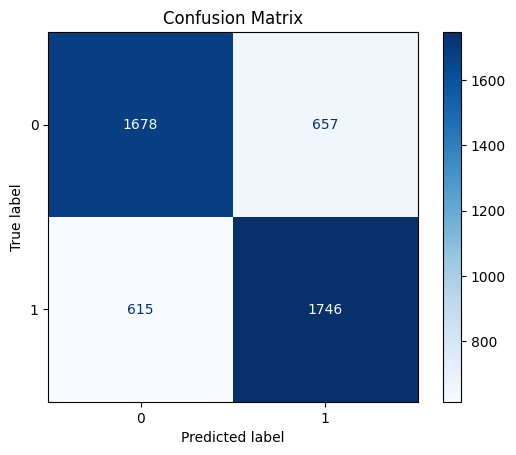

AUC: 0.7978775371013808


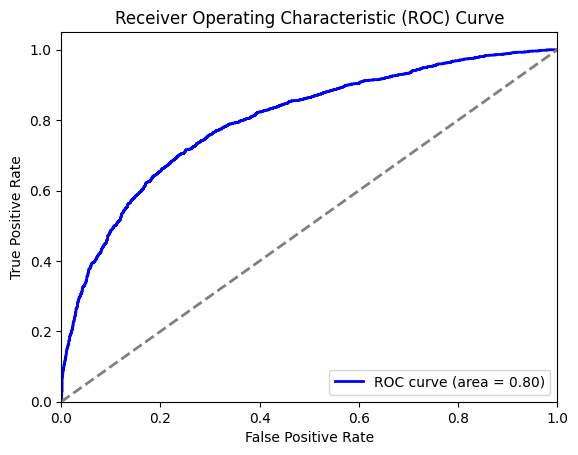

Positive Accuracy (Precision for positive class): 0.7265917602996255
Negative Accuracy (Precision for negative class): 0.7317924116877453
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 2


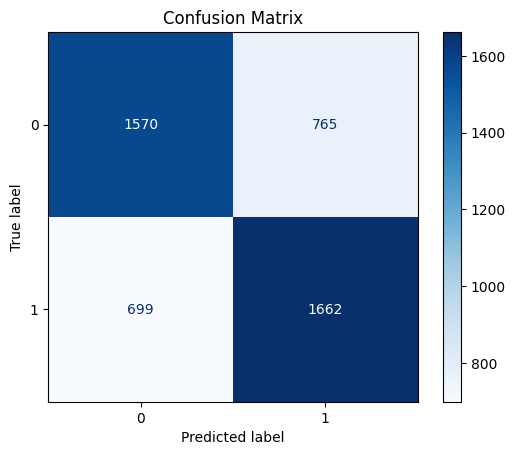

AUC: 0.7454546443954083


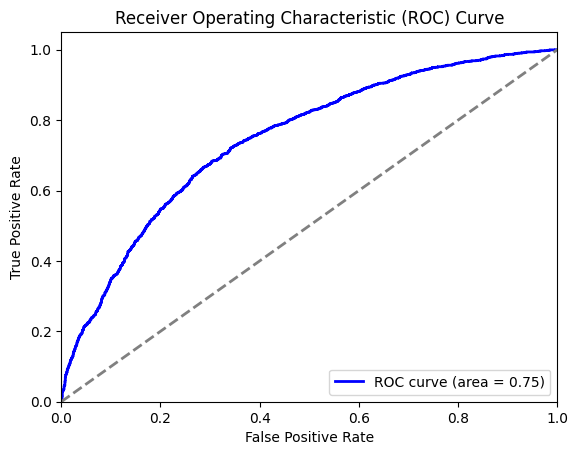

Positive Accuracy (Precision for positive class): 0.6847960444993819
Negative Accuracy (Precision for negative class): 0.6919347730277655
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 3


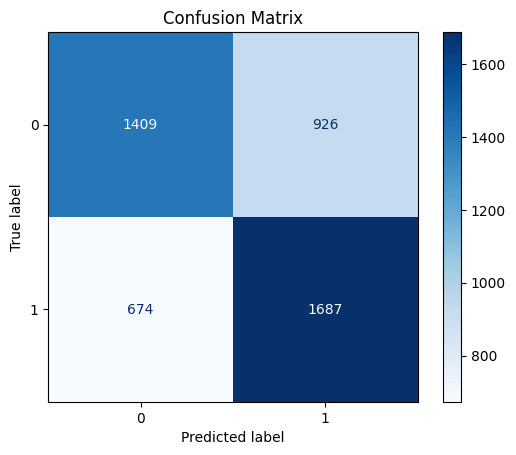

AUC: 0.721904031155818


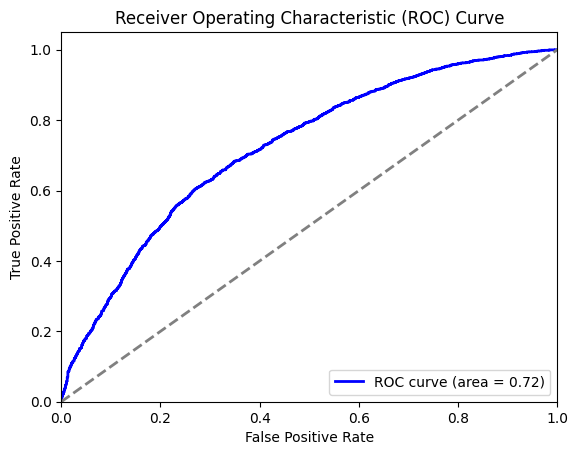

Positive Accuracy (Precision for positive class): 0.6456180635285113
Negative Accuracy (Precision for negative class): 0.6764282285165627


In [716]:
dir_path = config['model_output']['model_save_dir'] + config['date_string']+ '/' + 'test_log_'

for i in range(2,config['pathways_network']['n_hidden_layer']+2):
    print('-'*282)
    print(f'Number of Hidden Layers: {i-1}')
    result = pd.read_csv(f'{dir_path}{i}.csv',index_col=0)

    confusion_matrix_return(result)
    roc_curve_return(result)
    return_accuracy(result)

# Model Interpretation

In [573]:
# Define a hook function to capture the activations


def get_activation(name, number_of_layers, config, activations):
    def hook(model, input, output):
        # Convert output to numpy array for easier handling, but this is optional
        activations[name] = output.detach().numpy()
        
           
    return hook
def attaching_hook(model, dataloader):
    
        correct = 0
        total = 0
        predicted_list = []
        probability_list = []
        labels_list = []
        activations_list = []
        features_list = []
        criterion = nn.BCEWithLogitsLoss()
        loss = 0
        

        with torch.no_grad():  # No need to compute gradients during evaluation
            for sample_idx, (features, labels) in tqdm(enumerate(dataloader)):
                
                
                #print(labels)
                #print(features.shape)
                activations = {}
                for idx, layer in enumerate(model.layers):
                    layer_name = f'layer_{idx}'
                    number_of_layers = len(model.layers)
                    activation_hook = get_activation(layer_name, number_of_layers, config, activations)
                    
                    layer.register_forward_hook(activation_hook)
    
                outputs =  model(features)
                    #print(outputs)
                probability = torch.sigmoid(outputs.data)
                predicted = torch.round(torch.sigmoid(outputs.data))
                    #print(outputs)
                    #print(predicted)
                #loss += criterion(outputs, labels)
                    #_, predicted = torch.sigmoid(outputs.data)
                predicted_list.extend(predicted.detach().numpy())
                labels_list.extend(labels.detach().numpy())
                probability_list.extend(probability.detach().numpy())
                features_list.append(features)
                total += labels.size(0)
                x = activations
                activations_temp = activations.copy()
                activations_list.append(activations_temp)
                
                correct += (predicted == labels).sum().item()
                '''if sample_idx == 1000:
                    #print(activations_list)
                    break'''
                
            #print(total)
        accuracy = 100 * correct / total
        #print(activations_list)
        return activations_list, accuracy, predicted_list, labels_list, features_list,x
        


In [574]:

def return_feature_importance(model_dict_sparse, dataloader):
    predicted_list_dict = {}
    ground_truth_list_dict = {}
    activations_list_dict = {}
    accuracy_list_dict = {}
    for i, j in model_dict_sparse.items():
        #accuracy, loss, predicted_list, labels_list, probability_list = evaluate(j, dataloader)
        
        activations_list_dict[f'model_{i}_hidden_layers'], accuracy_list_dict[f'model_{i}_hidden_layers'], \
        predicted_list_dict[f'model_{i}_hidden_layers'], ground_truth_list_dict[f'model_{i}_hidden_layers'], \
        feature_list,x= attaching_hook(j, dataloader)
        print(f'{i} Layers: {accuracy_list_dict[f'model_{i}_hidden_layers']}')
        
    return activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x

In [575]:

activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x = return_feature_importance(model_dict_sparse, test_dataloader)

4696it [02:50, 27.58it/s]


2 Layers: 72.91311754684838


4696it [04:11, 18.64it/s]


3 Layers: 68.82453151618398


4696it [06:06, 12.83it/s]

4 Layers: 65.92844974446338


In [616]:
def return_feature_importance_list(activations_list_dict, model_name):
    m=0
    for k in tqdm(activations_list_dict[model_name]):
        #print(k)
        if m == 0:
            layer_dict = {key: [] for key in list(k.keys())}
        m = m+1
        
        #print(k['0_layer_0'])
        for z in list(layer_dict.keys()):
            #print(k)
            layer_dict[z].append(k[z][0])

    return layer_dict
    

In [717]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_2_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))
    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])
layer_0_df

li = []
for i in layer_dict['layer_1']:
    li.append(list(i))
    
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 734038.37it/s]


In [718]:
layer_1_df

R-HSA-9753281  R-HSA-71387  R-HSA-450531  \
cell_id                                                            
CACAACATCGTCCTTG.26.2        0.054064     0.009594      0.103718   
AGCTTCCGTCTCTCTG.9.9         0.028118    -0.044555      0.068069   
CGCCAGACAACAAGTA.17.11       0.063603     0.005452      0.030214   
GGGATGATCGTAACAC.7.4         0.033687     0.016704      0.206760   
ACGTTCCGTATTCTCT.5.11        0.000000     0.112472      0.069899   
...                               ...          ...           ...   
CATCAAGTCCTCGCAT.19.1        0.033122    -0.034338     -0.083406   
GTCAGCGGTCTGATAC.45.2        0.000000     0.071941      0.075827   
CATGCTCAGTGTCATC.30.10       0.065531     0.029235      0.061929   
CTCATCGAGCAAATGT.32.8        0.041930     0.026595      0.024141   
GAAATGACATGCACTA.3.9         0.054550    -0.051883      0.106846   

                        R-HSA-391251  R-HSA-69620  R-HSA-9675126  \
cell_id                                                            
CACAACATCGTCCTTG.26.2       0.039036    -0.008635       0.018997   
AGCTTCCGTCTCTCTG.9.9        0.031664    -0.093948      -0.008548   
CGCCAGACAACAAGTA.17.11      0.019097    -0.055822      -0.009098   
GGGATGATCGTAACAC.7.4        0.048859     0.065013       0.003499   
ACGTTCCGTATTCTCT.5.11       0.000000     0.027084       0.000000   
...                              ...          ...            ...   
CATCAAGTCCTCGCAT.19.1       0.018445    -0.047094       0.016971   
GTCAGCGGTCTGATAC.45.2       0.127617     0.090615      -0.016710   
CATGCTCAGTGTCATC.30.10      0.019115     0.015796      -0.022257   
CTCATCGAGCAAATGT.32.8       0.018221    -0.018558      -0.017344   
GAAATGACATGCACTA.3.9       -0.059633    -0.019018       0.014022   

                        R-HSA-5682910  R-HSA-5660526  R-HSA-390522  \
cell_id                                                              
CACAACATCGTCCTTG.26.2       -0.026221      -0.018246      0.021486   
AGCTTCCGTCTCTCTG.9.9        -0.110658       0.000000      0.000000   
CGCCAGACAACAAGTA.17.11      -0.074879      -0.028573      0.018063   
GGGATGATCGTAACAC.7.4        -0.082416       0.000000      0.027882   
ACGTTCCGTATTCTCT.5.11        0.000000       0.000000      0.000000   
...                               ...            ...           ...   
CATCAAGTCCTCGCAT.19.1       -0.049045       0.000000      0.000000   
GTCAGCGGTCTGATAC.45.2       -0.036786      -0.045683      0.000000   
CATGCTCAGTGTCATC.30.10      -0.068927      -0.033857      0.029053   
CTCATCGAGCAAATGT.32.8       -0.059109      -0.055158      0.000000   
GAAATGACATGCACTA.3.9        -0.076731      -0.031885      0.035694   

                        R-HSA-73886  ...  R-HSA-189445  R-HSA-9748787  \
cell_id                              ...                                
CACAACATCGTCCTTG.26.2      0.003698  ...  1.574006e-06      -0.041606   
AGCTTCCGTCTCTCTG.9.9      -0.019222  ...  0.000000e+00      -0.010186   
CGCCAGACAACAAGTA.17.11     0.003377  ...  1.784461e-06      -0.037463   
GGGATGATCGTAACAC.7.4       0.020155  ...  9.828614e-07      -0.023129   
ACGTTCCGTATTCTCT.5.11     -0.069171  ...  0.000000e+00       0.000000   
...                             ...  ...           ...            ...   
CATCAAGTCCTCGCAT.19.1     -0.061071  ...  0.000000e+00       0.000000   
GTCAGCGGTCTGATAC.45.2      0.017005  ...  0.000000e+00      -0.012870   
CATGCTCAGTGTCATC.30.10     0.031135  ...  1.031554e-06      -0.033105   
CTCATCGAGCAAATGT.32.8      0.027991  ...  9.490089e-07      -0.006276   
GAAATGACATGCACTA.3.9      -0.038651  ...  9.613366e-07      -0.025369   

                        R-HSA-983231  R-HSA-5668914  R-HSA-196854  \
cell_id                                                             
CACAACATCGTCCTTG.26.2       0.056456       0.082533      0.073860   
AGCTTCCGTCTCTCTG.9.9        0.088996       0.131297      0.065116   
CGCCAGACAACAAGTA.17.11      0.047612       0.100508      0.062034   
GGGATGATCGTAACAC.7.4        0.063332       0.066

In [721]:
last_layer_df

last_layer
cell_id                           
CACAACATCGTCCTTG.26.2     0.458160
AGCTTCCGTCTCTCTG.9.9     -0.521409
CGCCAGACAACAAGTA.17.11    0.208300
GGGATGATCGTAACAC.7.4      1.064491
ACGTTCCGTATTCTCT.5.11     0.058511
...                            ...
CATCAAGTCCTCGCAT.19.1    -1.893938
GTCAGCGGTCTGATAC.45.2     1.469059
CATGCTCAGTGTCATC.30.10    1.282622
CTCATCGAGCAAATGT.32.8    -0.055354
GAAATGACATGCACTA.3.9     -1.965485

[4696 rows x 1 columns]

In [722]:
y_test

diagnosis
0             1
1             0
2             0
3             1
4             1
...         ...
4691          1
4692          1
4693          1
4694          0
4695          0

[4696 rows x 1 columns]

In [740]:
for i,j in predicted_list_dict.items():
    flattened_list = [item for sublist in list(predicted_list_dict[i]) for item in sublist]
    predicted_list_dict[i] = flattened_list
    

In [744]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [745]:
predicted_list_dict['model_4_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]

In [736]:
for i,j in ground_truth_list_dict.items():
    flattened_list = [item for sublist in list(ground_truth_list_dict[i]) for item in sublist]
    ground_truth_list_dict[i] = flattened_list
    

In [746]:
ground_truth_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [748]:
ground_truth_list_dict['model_4_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [747]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [750]:
layer_1_df['predicted'] = predicted_list_dict['model_2_hidden_layers']
layer_1_df['ground_truth'] = ground_truth_list_dict['model_2_hidden_layers']
layer_1_df.head()

R-HSA-9753281  R-HSA-71387  R-HSA-450531  \
cell_id                                                            
CACAACATCGTCCTTG.26.2        0.054064     0.009594      0.103718   
AGCTTCCGTCTCTCTG.9.9         0.028118    -0.044555      0.068069   
CGCCAGACAACAAGTA.17.11       0.063603     0.005452      0.030214   
GGGATGATCGTAACAC.7.4         0.033687     0.016704      0.206760   
ACGTTCCGTATTCTCT.5.11        0.000000     0.112472      0.069899   

                        R-HSA-391251  R-HSA-69620  R-HSA-9675126  \
cell_id                                                            
CACAACATCGTCCTTG.26.2       0.039036    -0.008635       0.018997   
AGCTTCCGTCTCTCTG.9.9        0.031664    -0.093948      -0.008548   
CGCCAGACAACAAGTA.17.11      0.019097    -0.055822      -0.009098   
GGGATGATCGTAACAC.7.4        0.048859     0.065013       0.003499   
ACGTTCCGTATTCTCT.5.11       0.000000     0.027084       0.000000   

                        R-HSA-5682910  R-HSA-5660526  R-HSA-390522  \
cell_id                                                              
CACAACATCGTCCTTG.26.2       -0.026221      -0.018246      0.021486   
AGCTTCCGTCTCTCTG.9.9        -0.110658       0.000000      0.000000   
CGCCAGACAACAAGTA.17.11      -0.074879      -0.028573      0.018063   
GGGATGATCGTAACAC.7.4        -0.082416       0.000000      0.027882   
ACGTTCCGTATTCTCT.5.11        0.000000       0.000000      0.000000   

                        R-HSA-73886  ...  R-HSA-983231  R-HSA-5668914  \
cell_id                              ...                                
CACAACATCGTCCTTG.26.2      0.003698  ...      0.056456       0.082533   
AGCTTCCGTCTCTCTG.9.9      -0.019222  ...      0.088996       0.131297   
CGCCAGACAACAAGTA.17.11     0.003377  ...      0.047612       0.100508   
GGGATGATCGTAACAC.7.4       0.020155  ...      0.063332       0.066456   
ACGTTCCGTATTCTCT.5.11     -0.069171  ...      0.088292      -0.002000   

                        R-HSA-196854  R-HSA-157118  R-HSA-382556  \
cell_id                                                            
CACAACATCGTCCTTG.26.2       0.073860      0.009229      0.012015   
AGCTTCCGTCTCTCTG.9.9        0.065116      0.135826      0.000000   
CGCCAGACAACAAGTA.17.11      0.062034      0.066834      0.025086   
GGGATGATCGTAACAC.7.4        0.108359      0.130401     -0.022330   
ACGTTCCGTATTCTCT.5.11       0.000000      0.000000      0.000000   

                        R-HSA-1181150  R-HSA-5663205  R-HSA-2262752  \
cell_id                                                               
CACAACATCGTCCTTG.26.2        0.035096      -0.097365       0.107205   
AGCTTCCGTCTCTCTG.9.9         0.032094      -0.041190       0.069450   
CGCCAGACAACAAGTA.17.11       0.027957       0.039960       0.088308   
GGGATGATCGTAACAC.7.4         0.048868      -0.415049       0.399887   
ACGTTCCGTATTCTCT.5.11        0.000000      -0.190422       0.322576   

                        predicted  ground_truth  
cell_id                                          
CACAACATCGTCCTTG.26.2         1.0           1.0  
AGCTTCCGTCTCTCTG.9.9          0.0           0.0  
CGCCAGACAACAAGTA.17.11        1.0           0.0  
GGGATGATCGTAACAC.7.4          1.0           1.0  
ACGTTCCGTATTCTCT.5.11         1.0           1.0  

[5 rows x 136 columns]

In [754]:
correct_predicted_layer_1_df = layer_1_df[layer_1_df.predicted == layer_1_df.ground_truth]
correct_predicted_layer_1_df_AD = correct_predicted_layer_1_df[correct_predicted_layer_1_df.predicted == 1]
correct_predicted_layer_1_df_Control = correct_predicted_layer_1_df[correct_predicted_layer_1_df.predicted == 0]

In [758]:
correct_predicted_layer_1_df_AD.drop(columns=['predicted','ground_truth'], inplace = True)
correct_predicted_layer_1_df_AD.head()

/tmp/ipykernel_2219947/1148605866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_predicted_layer_1_df_AD.drop(columns=['predicted','ground_truth'], inplace = True)


R-HSA-9753281  R-HSA-71387  R-HSA-450531  R-HSA-391251  \
cell_id                                                                         
CACAACATCGTCCTTG.26.2       0.054064     0.009594      0.103718      0.039036   
GGGATGATCGTAACAC.7.4        0.033687     0.016704      0.206760      0.048859   
ACGTTCCGTATTCTCT.5.11       0.000000     0.112472      0.069899      0.000000   
AGATCGTAGAAGCTCG.11.9       0.000000     0.097251      0.169773      0.071453   
CGTCTACTCTTACCGC.38.1       0.085102     0.077158     -0.024840      0.077013   

                       R-HSA-69620  R-HSA-9675126  R-HSA-5682910  \
cell_id                                                            
CACAACATCGTCCTTG.26.2    -0.008635       0.018997      -0.026221   
GGGATGATCGTAACAC.7.4      0.065013       0.003499      -0.082416   
ACGTTCCGTATTCTCT.5.11     0.027084       0.000000       0.000000   
AGATCGTAGAAGCTCG.11.9     0.021841      -0.028853      -0.085784   
CGTCTACTCTTACCGC.38.1     0.040477      -0.025722      -0.044145   

                       R-HSA-5660526  R-HSA-390522  R-HSA-73886  ...  \
cell_id                                                          ...   
CACAACATCGTCCTTG.26.2      -0.018246      0.021486     0.003698  ...   
GGGATGATCGTAACAC.7.4        0.000000      0.027882     0.020155  ...   
ACGTTCCGTATTCTCT.5.11       0.000000      0.000000    -0.069171  ...   
AGATCGTAGAAGCTCG.11.9      -0.052363      0.029488     0.041076  ...   
CGTCTACTCTTACCGC.38.1      -0.051813      0.000000     0.009056  ...   

                       R-HSA-189445  R-HSA-9748787  R-HSA-983231  \
cell_id                                                            
CACAACATCGTCCTTG.26.2  1.574006e-06      -0.041606      0.056456   
GGGATGATCGTAACAC.7.4   9.828614e-07      -0.023129      0.063332   
ACGTTCCGTATTCTCT.5.11  0.000000e+00       0.000000      0.088292   
AGATCGTAGAAGCTCG.11.9  0.000000e+00      -0.006851      0.129548   
CGTCTACTCTTACCGC.38.1  2.690074e-06      -0.044958      0.027249   

                       R-HSA-5668914  R-HSA-196854  R-HSA-157118  \
cell_id                                                            
CACAACATCGTCCTTG.26.2       0.082533      0.073860      0.009229   
GGGATGATCGTAACAC.7.4        0.066456      0.108359      0.130401   
ACGTTCCGTATTCTCT.5.11      -0.002000      0.000000      0.000000   
AGATCGTAGAAGCTCG.11.9       0.058132      0.102702      0.226544   
CGTCTACTCTTACCGC.38.1       0.050351      0.091369      0.101441   

                       R-HSA-382556  R-HSA-1181150  R-HSA-5663205  \
cell_id                                                             
CACAACATCGTCCTTG.26.2      0.012015       0.035096      -0.097365   
GGGATGATCGTAACAC.7.4      -0.022330       0.048868      -0.415049   
ACGTTCCGTATTCTCT.5.11      0.000000       0.000000      -0.190422   
AGATCGTAGAAGCTCG.11.9     -0.021044       0.033137      -0.387239   
CGTCTACTCTTACCGC.38.1      0.004305       0.000000      -0.070010   

                       R-HSA-2262752  
cell_id                               
CACAACATCGTCCTTG.26.2       0.107205  
GGGATGATCGTAACAC.7.4        0.399887  
ACGTTCCGTATTCTCT.5.11       0.322576  
AGATCGTAGAAGCTCG.11.9       0.357963  
CGTCTACTCTTACCGC.38.1       0.275343  

[5 rows x 134 columns]

In [759]:
correct_predicted_layer_1_df_Control.drop(columns=['predicted','ground_truth'], inplace = True)
correct_predicted_layer_1_df_Control

/tmp/ipykernel_2219947/1979248537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_predicted_layer_1_df_Control.drop(columns=['predicted','ground_truth'], inplace = True)


R-HSA-9753281  R-HSA-71387  R-HSA-450531  \
cell_id                                                            
AGCTTCCGTCTCTCTG.9.9         0.028118    -0.044555      0.068069   
GACTTCCCACTTGTCC.31.9        0.000000     0.001385      0.000000   
ACAAGCTTCCATCTGC.13.2        0.045836    -0.057312      0.096674   
AGATCCAGTAGGACCA.13.11       0.047643    -0.122599      0.102021   
AAGGTTCTCTGACCTC.23.1        0.000000    -0.112657     -0.008441   
...                               ...          ...           ...   
GCACTAATCTCCTGTG.27.11       0.092619    -0.083345      0.009324   
GACTGATAGATGCCGA.28.6        0.064351    -0.072754      0.013545   
ACGGAAGCAAGACAAT.13.14       0.000000     0.029207      0.066036   
CTCATCGAGCAAATGT.32.8        0.041930     0.026595      0.024141   
GAAATGACATGCACTA.3.9         0.054550    -0.051883      0.106846   

                        R-HSA-391251  R-HSA-69620  R-HSA-9675126  \
cell_id                                                            
AGCTTCCGTCTCTCTG.9.9        0.031664    -0.093948      -0.008548   
GACTTCCCACTTGTCC.31.9       0.036669    -0.062049      -0.017214   
ACAAGCTTCCATCTGC.13.2       0.033295     0.007809      -0.002146   
AGATCCAGTAGGACCA.13.11     -0.026020    -0.042973      -0.018399   
AAGGTTCTCTGACCTC.23.1       0.085861    -0.075007       0.000000   
...                              ...          ...            ...   
GCACTAATCTCCTGTG.27.11      0.034160    -0.129592       0.024512   
GACTGATAGATGCCGA.28.6       0.091900    -0.005199      -0.011279   
ACGGAAGCAAGACAAT.13.14     -0.008439    -0.169293      -0.008289   
CTCATCGAGCAAATGT.32.8       0.018221    -0.018558      -0.017344   
GAAATGACATGCACTA.3.9       -0.059633    -0.019018       0.014022   

                        R-HSA-5682910  R-HSA-5660526  R-HSA-390522  \
cell_id                                                              
AGCTTCCGTCTCTCTG.9.9        -0.110658       0.000000      0.000000   
GACTTCCCACTTGTCC.31.9       -0.038131       0.000000      0.000000   
ACAAGCTTCCATCTGC.13.2       -0.056792      -0.034888      0.010149   
AGATCCAGTAGGACCA.13.11      -0.080299      -0.020636      0.029429   
AAGGTTCTCTGACCTC.23.1        0.000000       0.000000      0.000000   
...                               ...            ...           ...   
GCACTAATCTCCTGTG.27.11      -0.048761      -0.029126      0.039288   
GACTGATAGATGCCGA.28.6       -0.107818       0.000000      0.017019   
ACGGAAGCAAGACAAT.13.14       0.000000       0.000000      0.042250   
CTCATCGAGCAAATGT.32.8       -0.059109      -0.055158      0.000000   
GAAATGACATGCACTA.3.9        -0.076731      -0.031885      0.035694   

                        R-HSA-73886  ...  R-HSA-189445  R-HSA-9748787  \
cell_id                              ...                                
AGCTTCCGTCTCTCTG.9.9      -0.019222  ...  0.000000e+00      -0.010186   
GACTTCCCACTTGTCC.31.9      0.055046  ...  0.000000e+00      -0.009001   
ACAAGCTTCCATCTGC.13.2      0.031375  ...  1.068767e-06      -0.034098   
AGATCCAGTAGGACCA.13.11     0.024285  ...  1.047298e-06      -0.027321   
AAGGTTCTCTGACCTC.23.1      0.000000  ...  0.000000e+00      -0.015938   
...                             ...  ...           ...            ...   
GCACTAATCTCCTGTG.27.11    -0.073447  ...  1.484290e-06      -0.047361   
GACTGATAGATGCCGA.28.6     -0.019009  ...  0.000000e+00      -0.026400   
ACGGAAGCAAGACAAT.13.14    -0.038155  ...  0.000000e+00      -0.006336   
CTCATCGAGCAAATGT.32.8      0.027991  ...  9.490089e-07      -0.006276   
GAAATGACATGCACTA.3.9      -0.038651  ...  9.613366e-07      -0.025369   

                        R-HSA-983231  R-HSA-5668914  R-HSA-196854  \
cell_id                                                             
AGCTTCCGTCTCTCTG.9.9        0.088996       0.131297      0.065116   
GACTTCCCACTTGTCC.31.9       0.091487       0.061996      0.005229   
ACAAGCTTCCATCTGC.13.2       0.040585       0.138628      0.074385   
AGATCCAGTAGGACCA.13.11      0.035706       0.122

In [766]:
from scipy import stats



# Perform a two-sample t-test





T-statistic: -1.000017325076745
P-value: 0.3465856205180649


T-statistic: 6.143890854269765
P-value: 8.977614738103371e-10


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


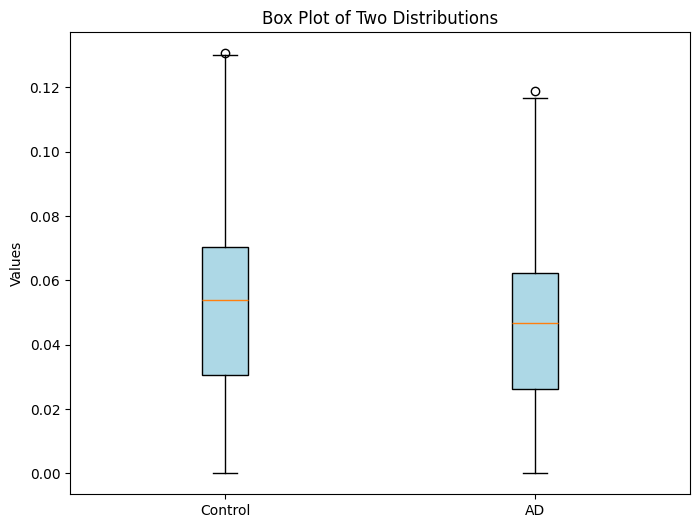

T-statistic: -22.350531486549368
P-value: 2.1326566483794503e-103


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


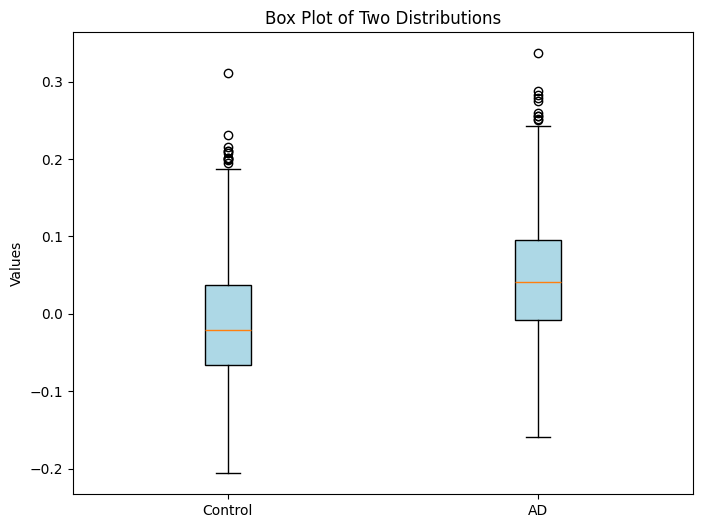

T-statistic: -19.79787773941763
P-value: 1.1144161223203994e-82


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


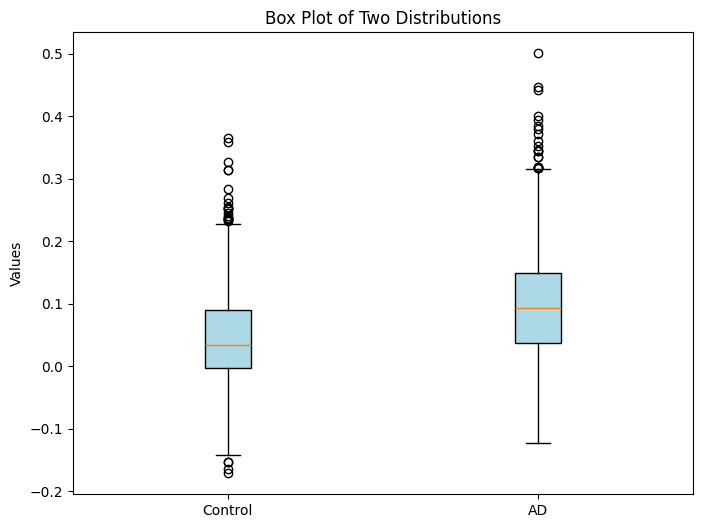

T-statistic: -18.219072748082432
P-value: 7.35405057360536e-71


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


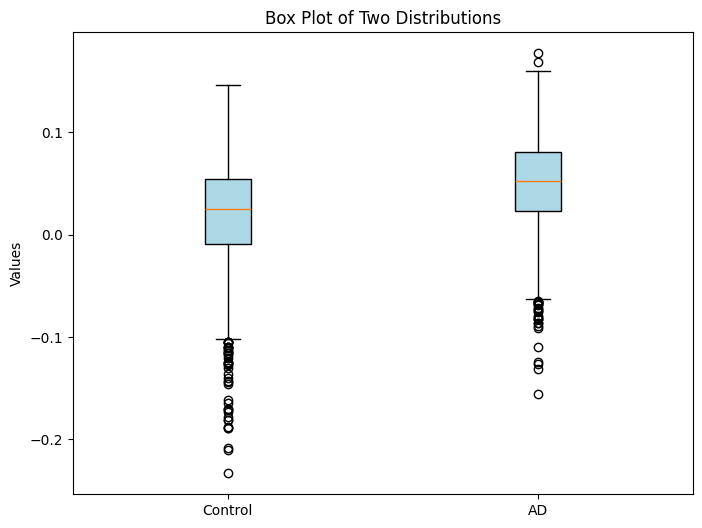

T-statistic: -24.404766016405652
P-value: 2.0701027907961914e-121


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


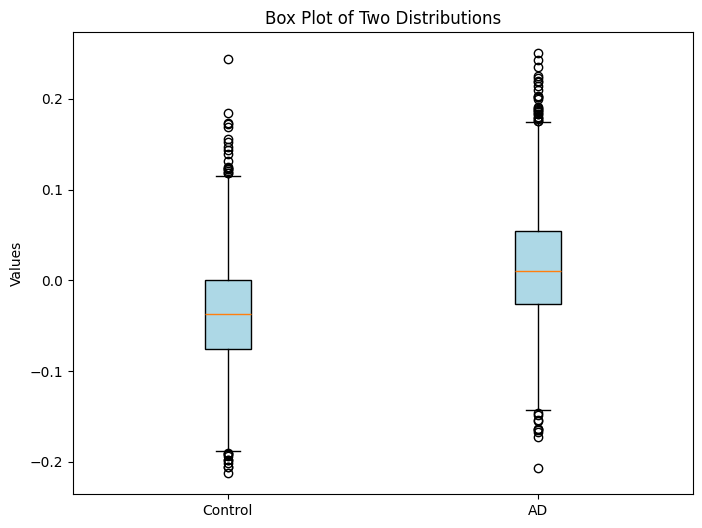

T-statistic: 7.447417715968581
P-value: 1.1983770103368446e-13


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


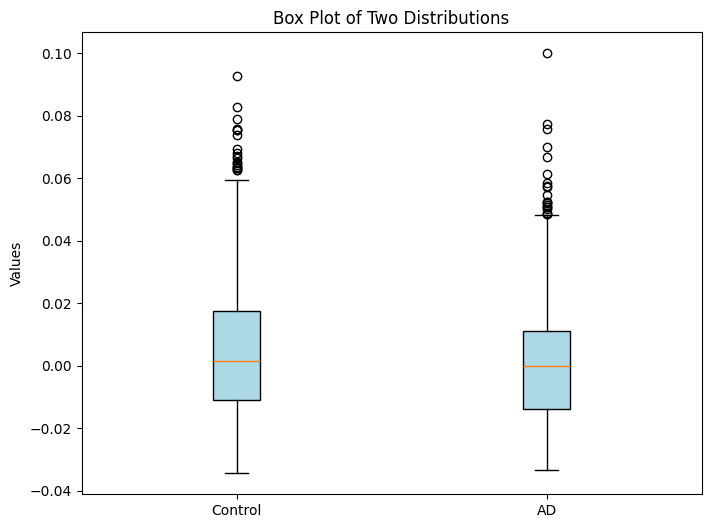

T-statistic: -4.171473107740876
P-value: 3.1015334214671855e-05


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


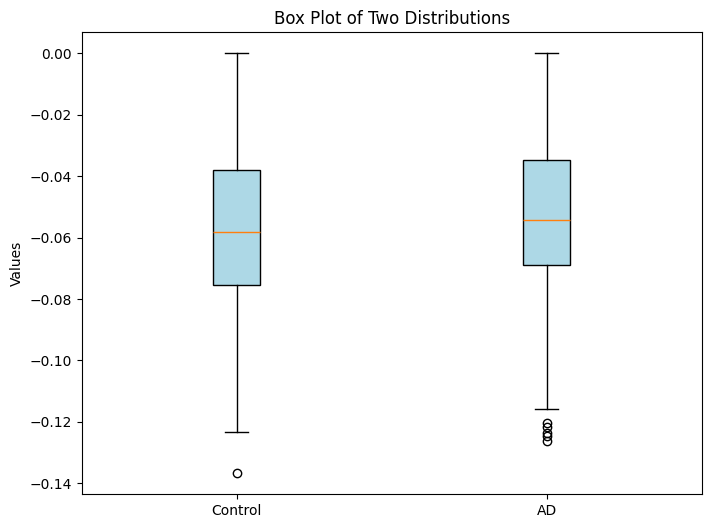

T-statistic: 17.475233836063904
P-value: 1.4364449275332007e-65


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


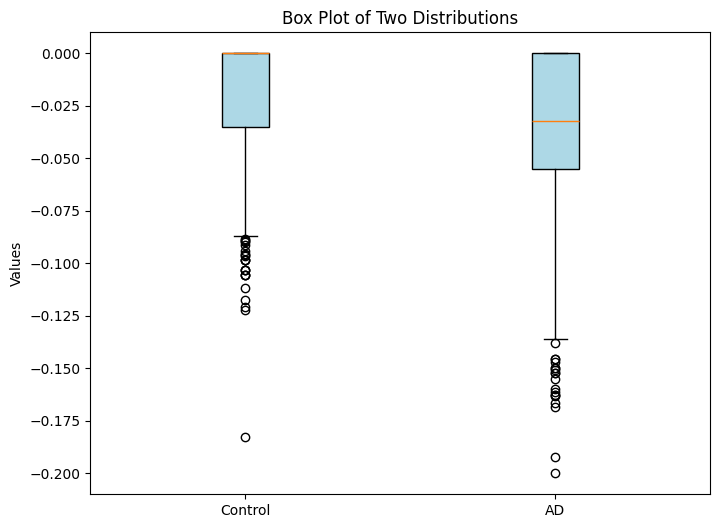

T-statistic: 5.284482076360583
P-value: 1.3394606264357123e-07


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


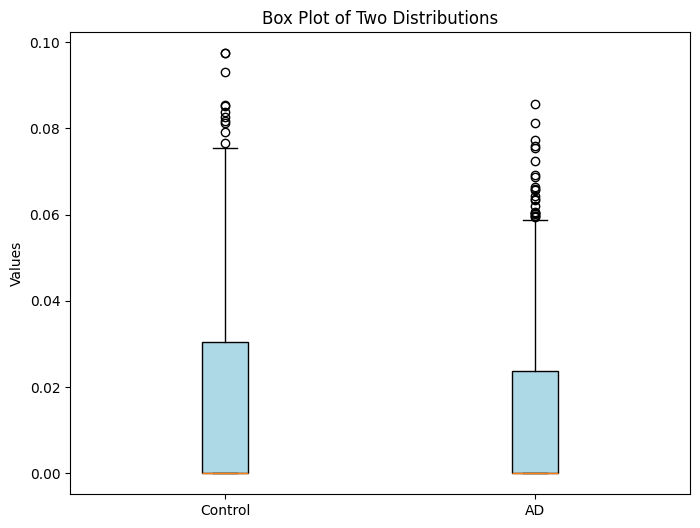

T-statistic: -9.927778967296051
P-value: 6.414178505735278e-23


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


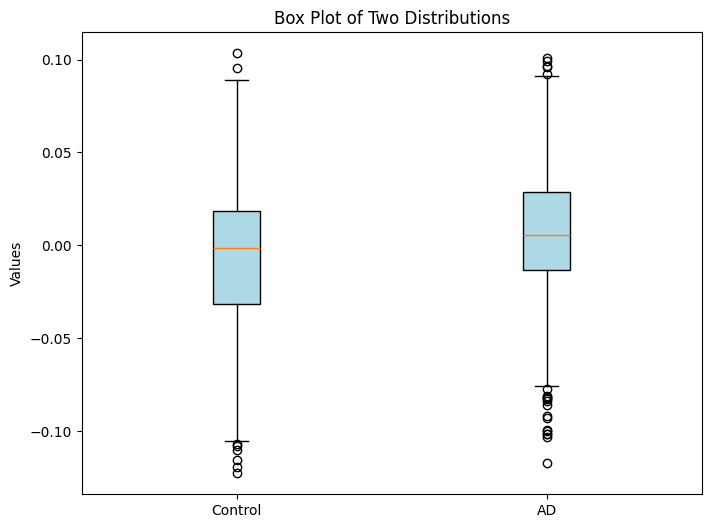

T-statistic: -11.542264393525183
P-value: 2.9136967203168835e-30


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


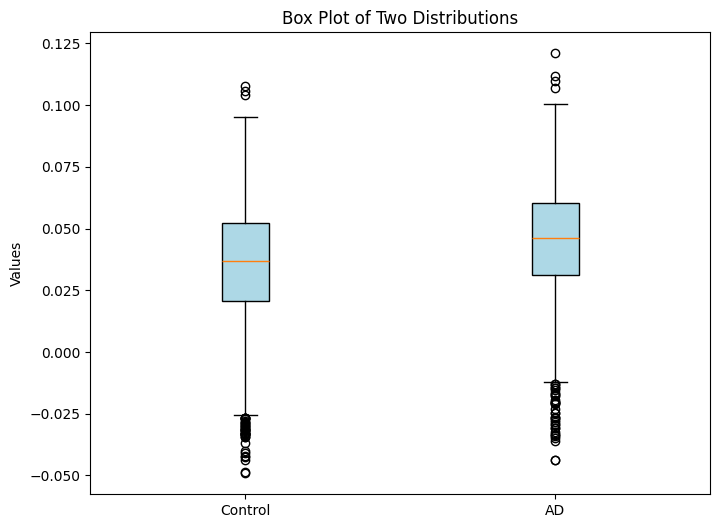

T-statistic: -10.355510882451489
P-value: 9.136135237141754e-25


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


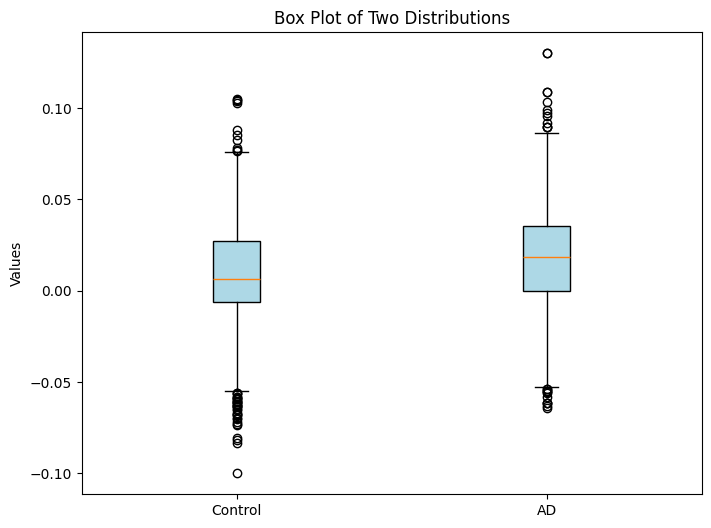

T-statistic: -13.842279939063944
P-value: 1.93249841458866e-42


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


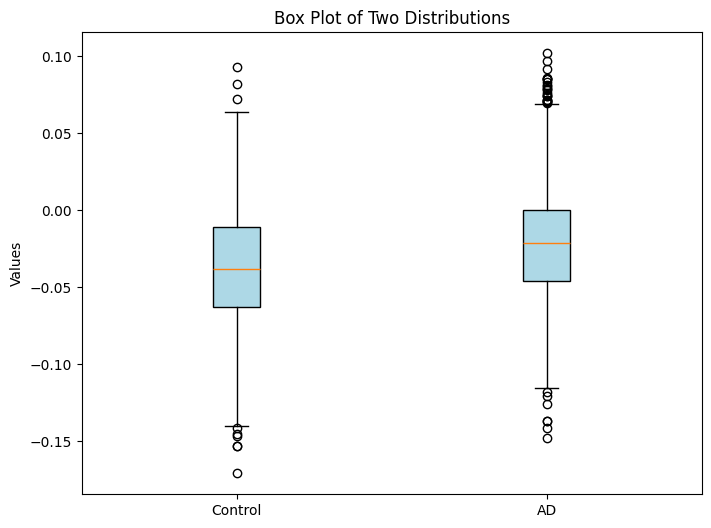

T-statistic: -14.632454275919349
P-value: 4.479061242095687e-47


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


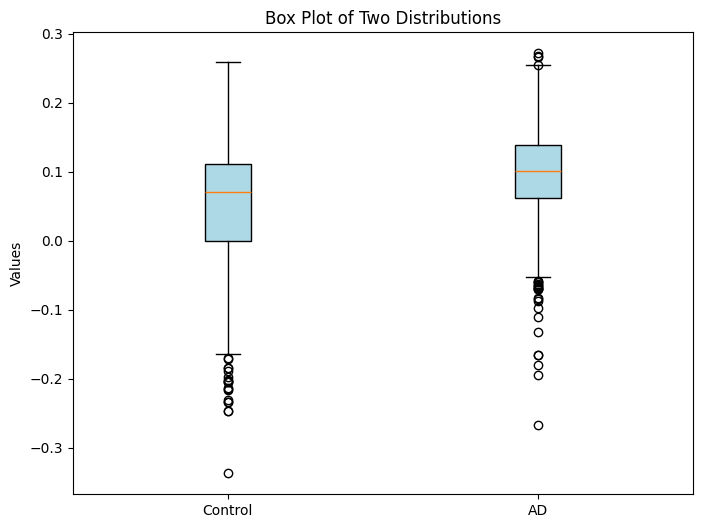

T-statistic: -7.313476488398622
P-value: 3.2261073302305124e-13


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


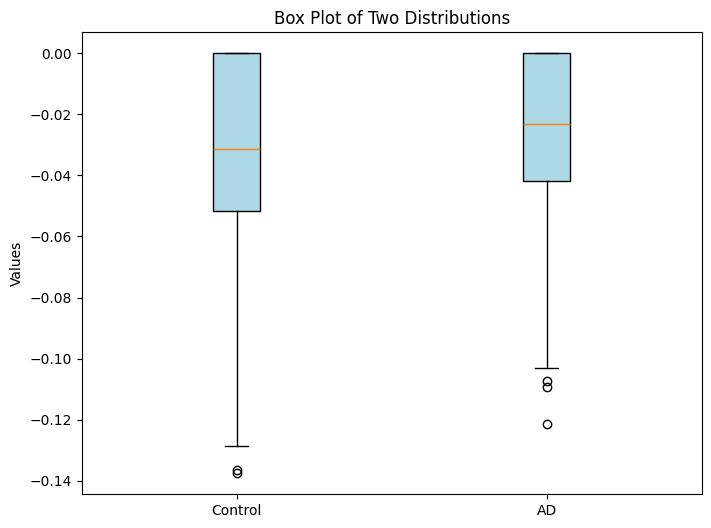

T-statistic: -16.948326451960998
P-value: 6.225816542128115e-62


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


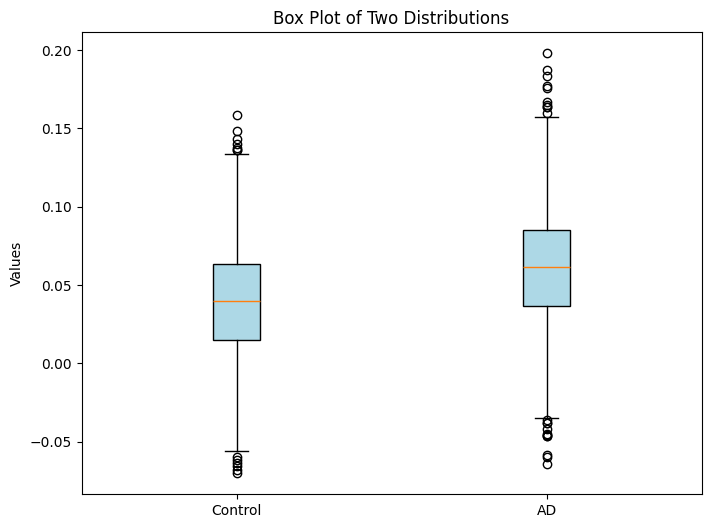

T-statistic: -13.83082977939034
P-value: 2.2470665709794453e-42


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


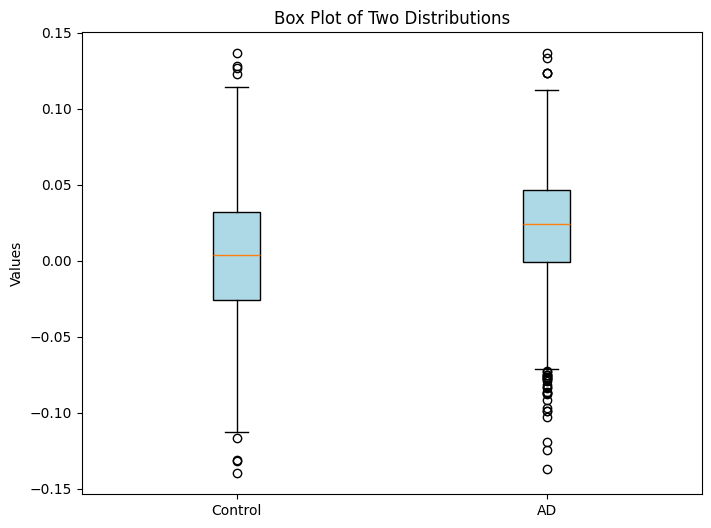

T-statistic: -16.187557641634825
P-value: 7.583278824296695e-57


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


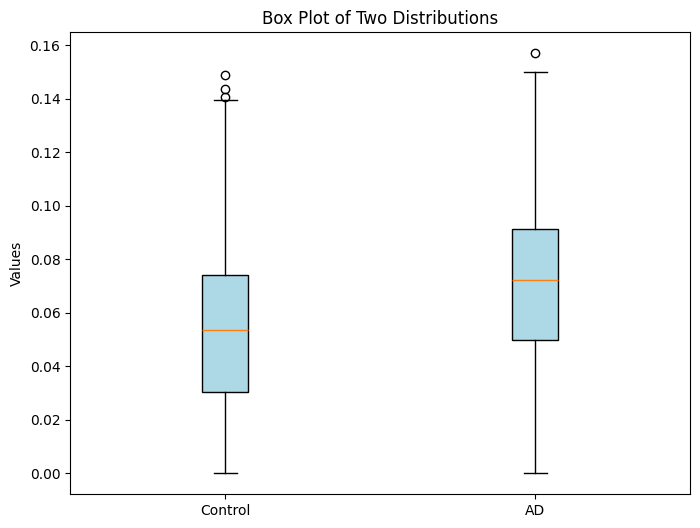

T-statistic: 26.749490150683854
P-value: 2.6500406966392224e-143


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


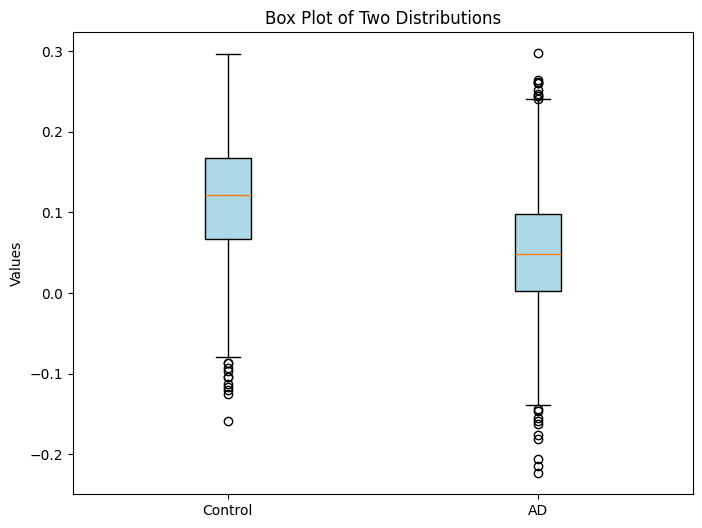

T-statistic: 7.880143594436785
P-value: 4.358276297619172e-15


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


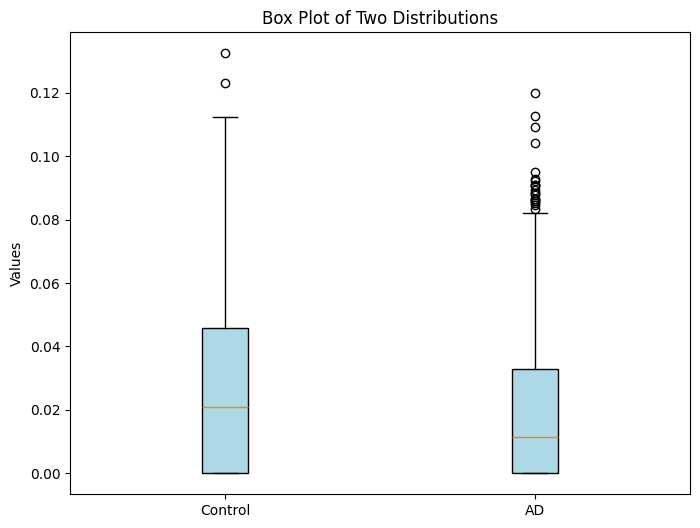

T-statistic: 29.6080963373606
P-value: 1.007528445797893e-171


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


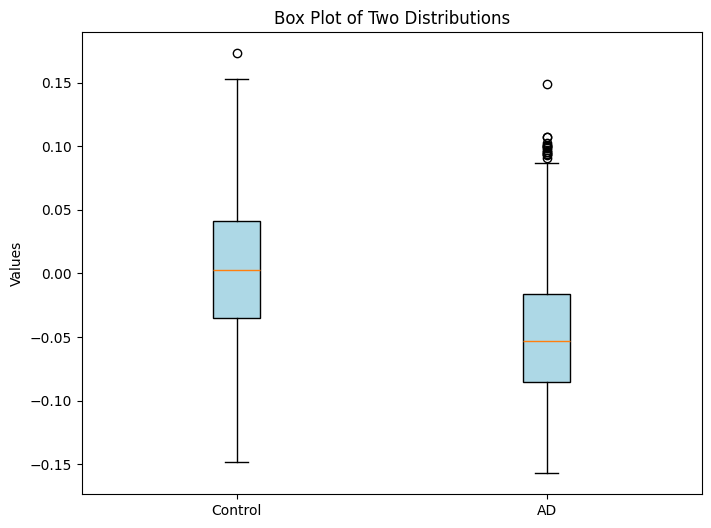

T-statistic: -8.95289127540626
P-value: 5.561032636713062e-19


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


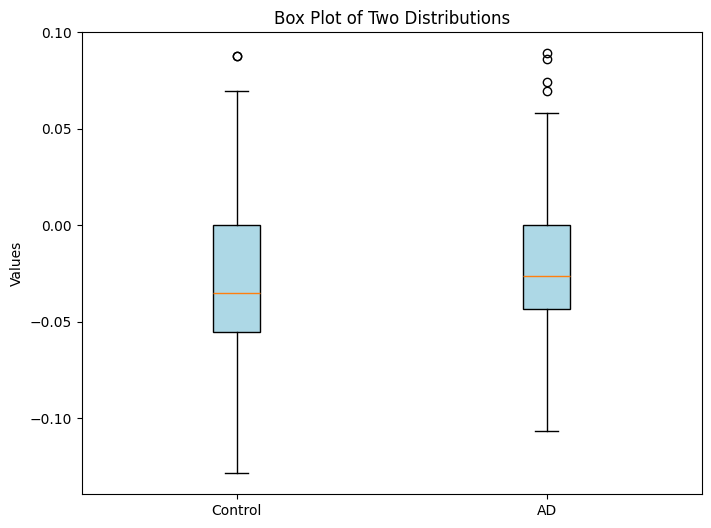

T-statistic: 5.206635845222863
P-value: 2.036345615003712e-07


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


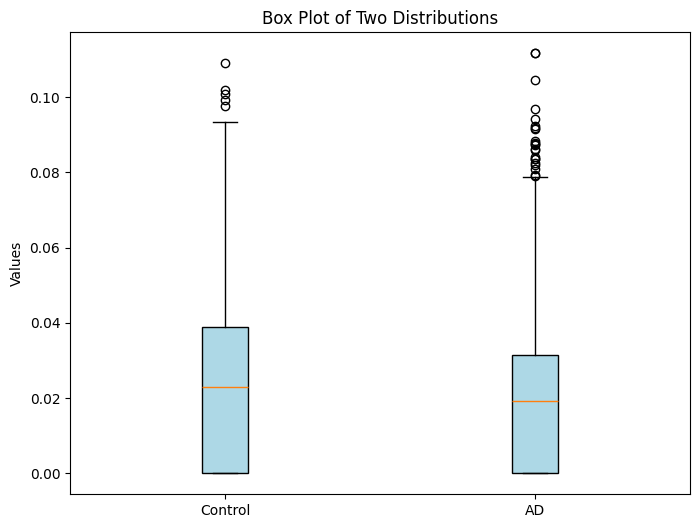

T-statistic: -25.819231651230176
P-value: 1.8660571033085874e-134


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


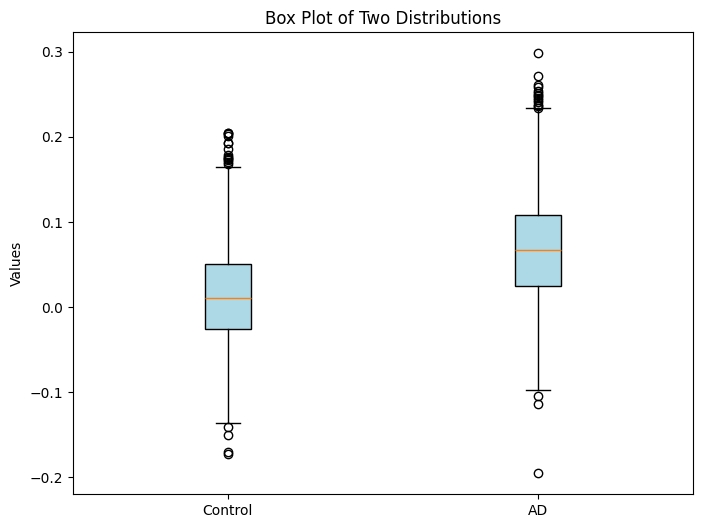

T-statistic: 35.9534804988578
P-value: 1.9771923519196663e-240


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


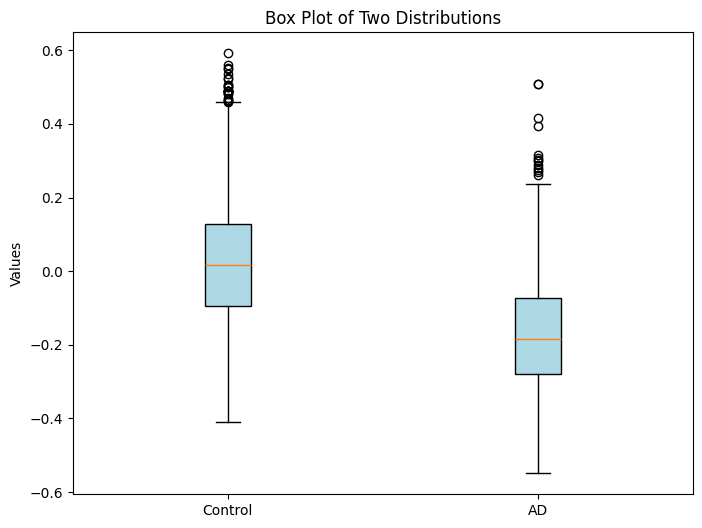

T-statistic: 11.13349865210008
P-value: 2.62520228490429e-28


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


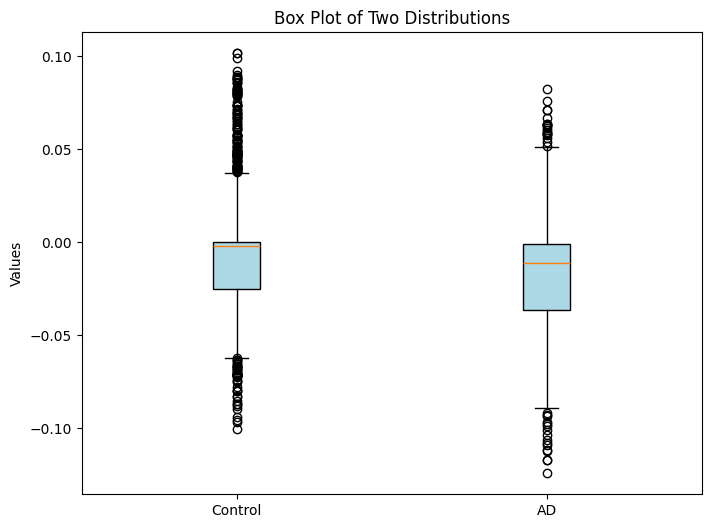

T-statistic: -12.570550109738747
P-value: 1.8407494648437566e-35


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


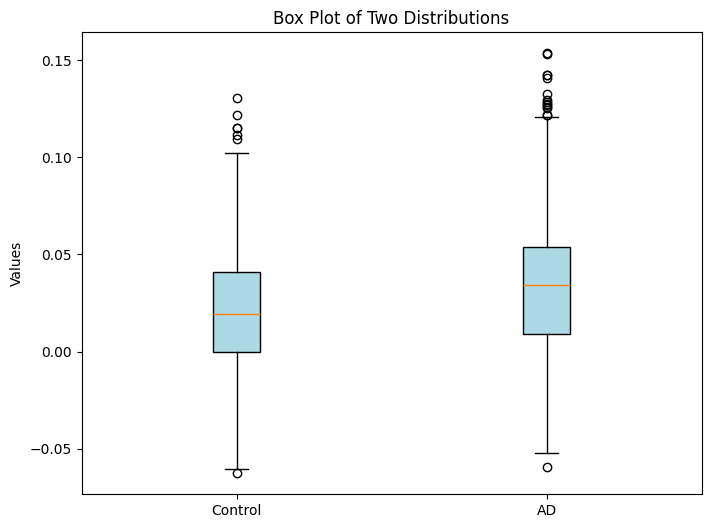

T-statistic: 3.1136649068898827
P-value: 0.0018630617214840514


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


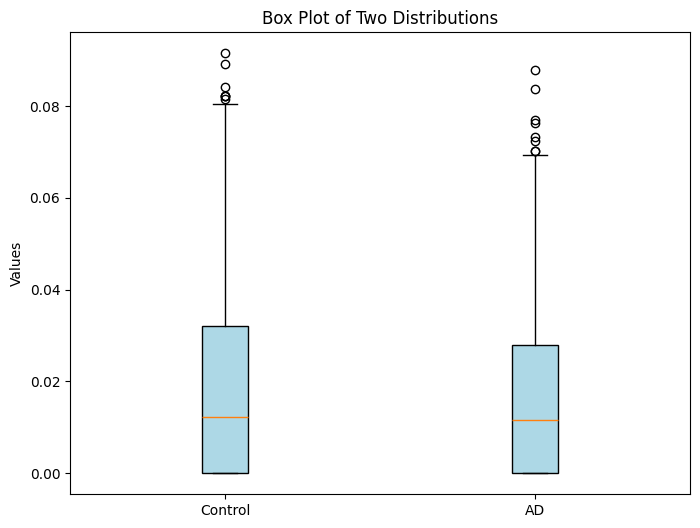

T-statistic: 1.3912916328725924
P-value: 0.164227451510592


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


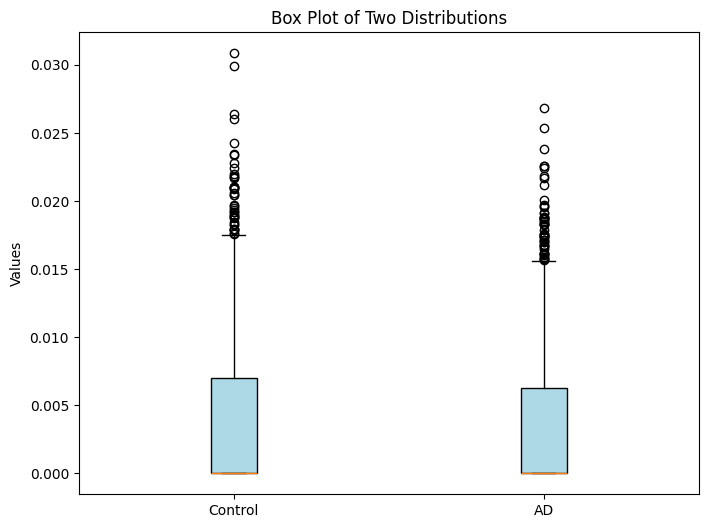

T-statistic: 14.10546061197737
P-value: 5.85470651950077e-44


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


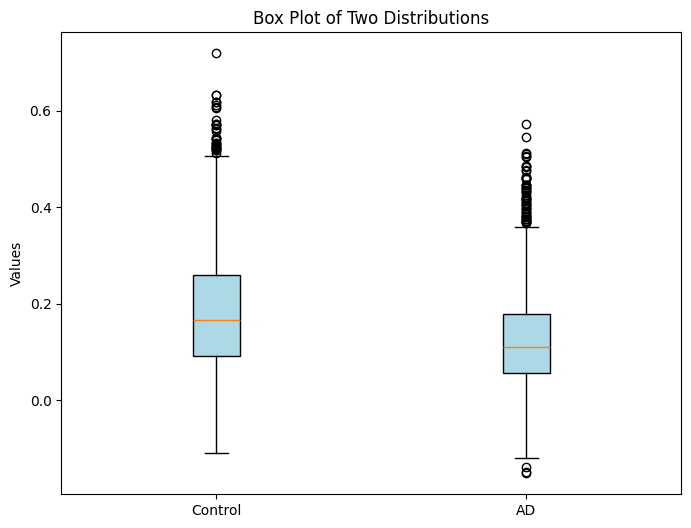

T-statistic: 37.263838821410424
P-value: 2.067383780420856e-255


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


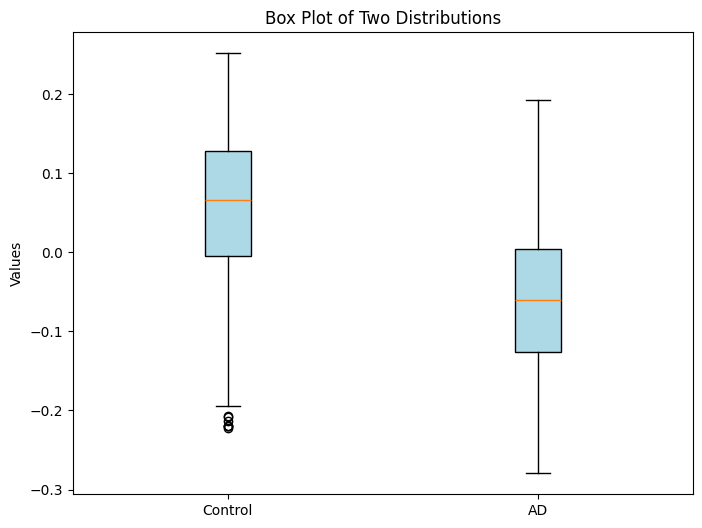

T-statistic: -5.749806694071907
P-value: 9.718331611166574e-09


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


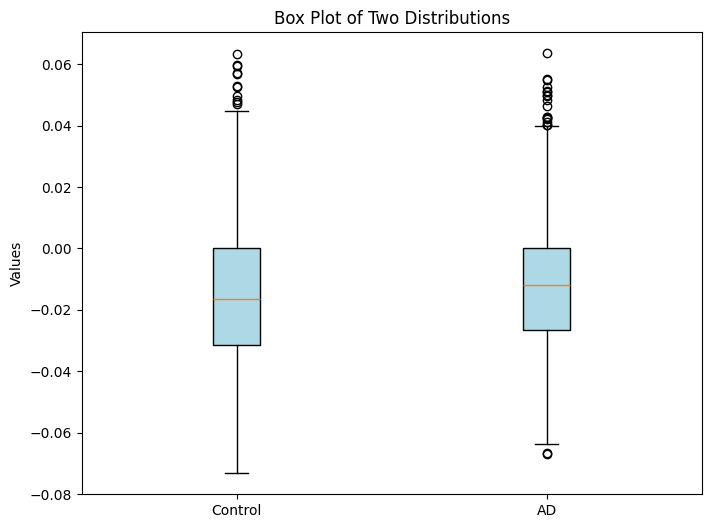

T-statistic: -9.850456196010564
P-value: 1.3590470723490905e-22


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


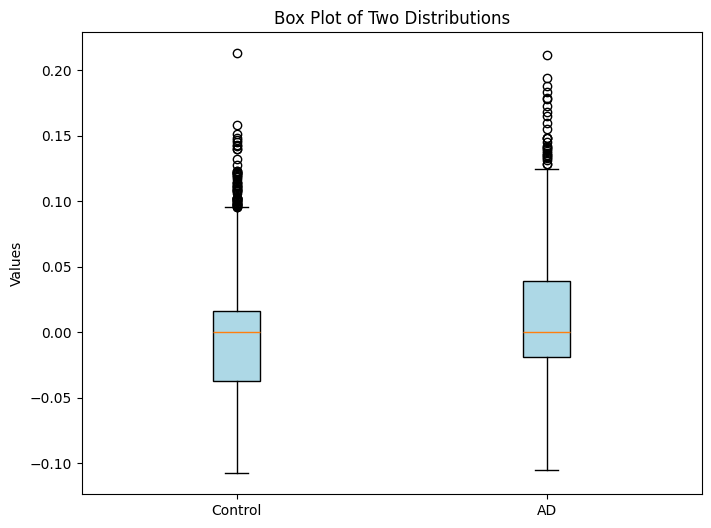

T-statistic: -13.908197324618607
P-value: 8.093375052694977e-43


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


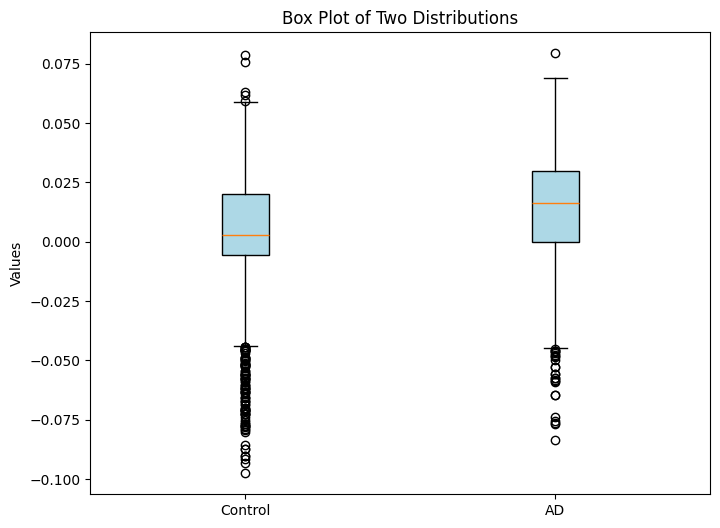

T-statistic: -22.788806381452698
P-value: 3.8225516869422213e-107


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


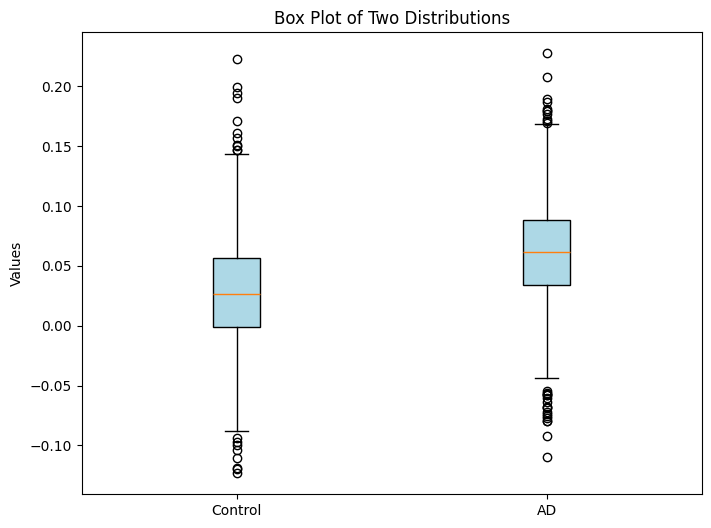

T-statistic: -8.474803855336955
P-value: 3.4501776980945875e-17


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


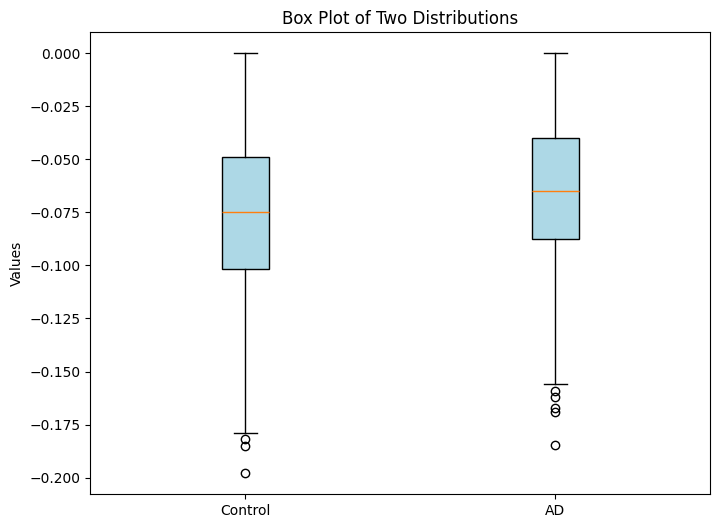

T-statistic: 9.131496673271432
P-value: 1.1271051027209326e-19


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


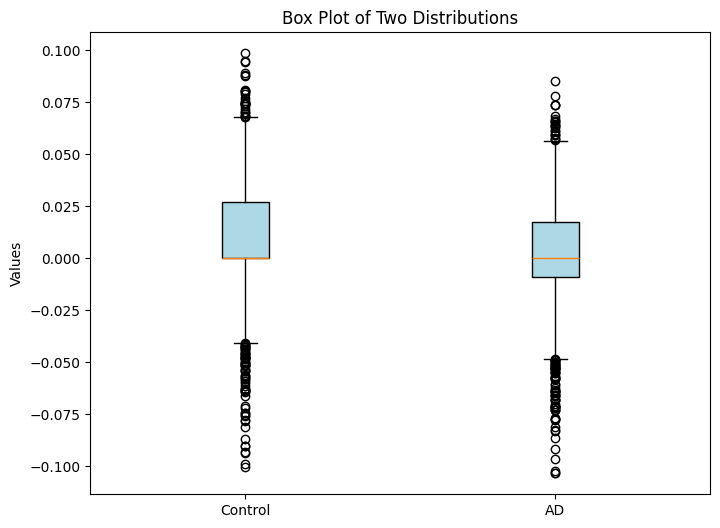

T-statistic: 2.626831991547798
P-value: 0.008656821405669082


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


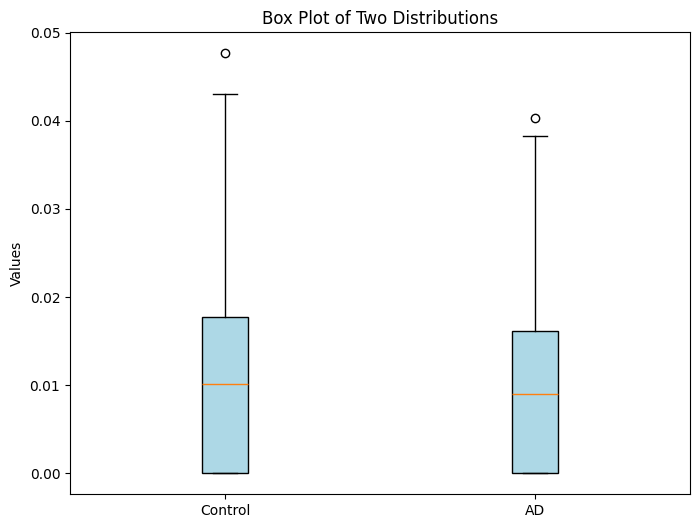

T-statistic: -19.762383490294866
P-value: 2.095886659829691e-82


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


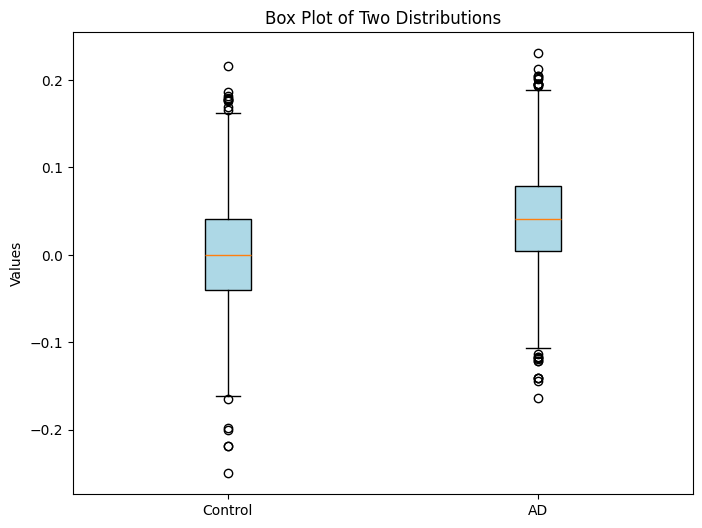

T-statistic: -3.689099314379815
P-value: 0.00022854993221828684


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


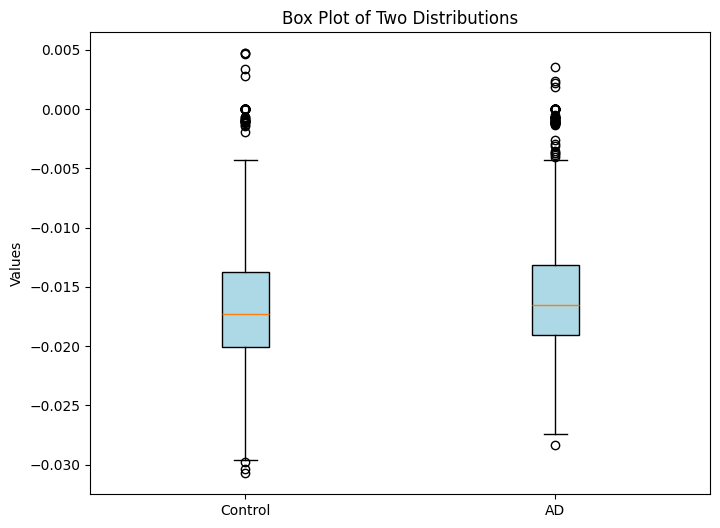

T-statistic: -11.182640197357836
P-value: 1.5401827907183888e-28


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


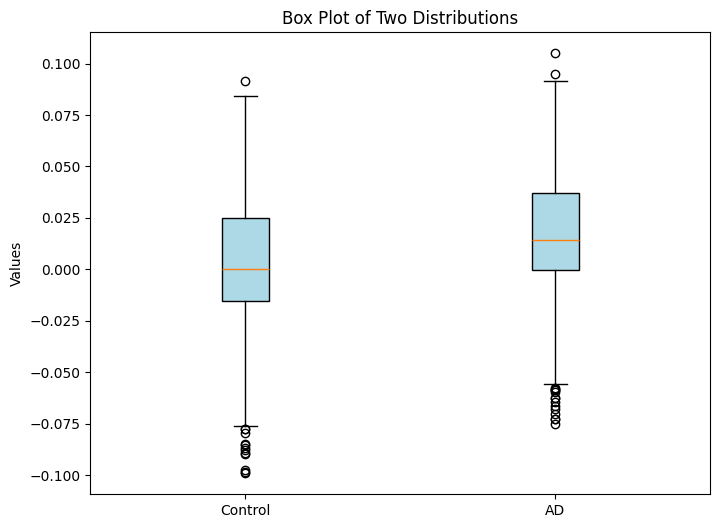

T-statistic: -33.58533070054816
P-value: 5.457616980705917e-214


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


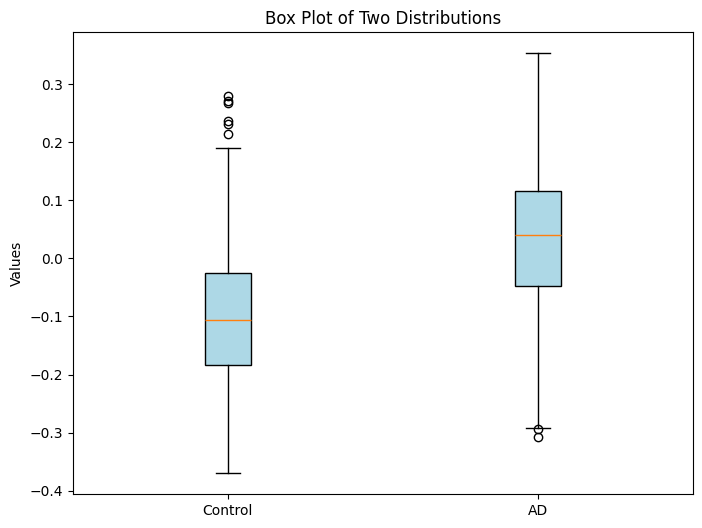

T-statistic: 30.413913989766904
P-value: 4.78502276582505e-180


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


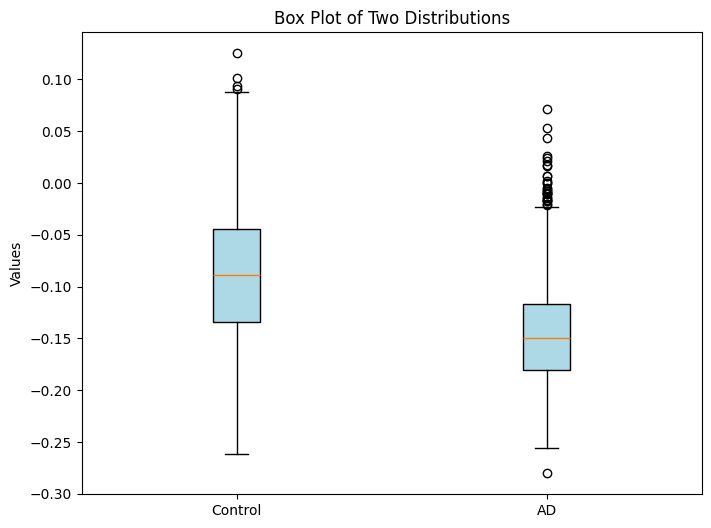

T-statistic: -26.095915328625086
P-value: 4.582313852424339e-137


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


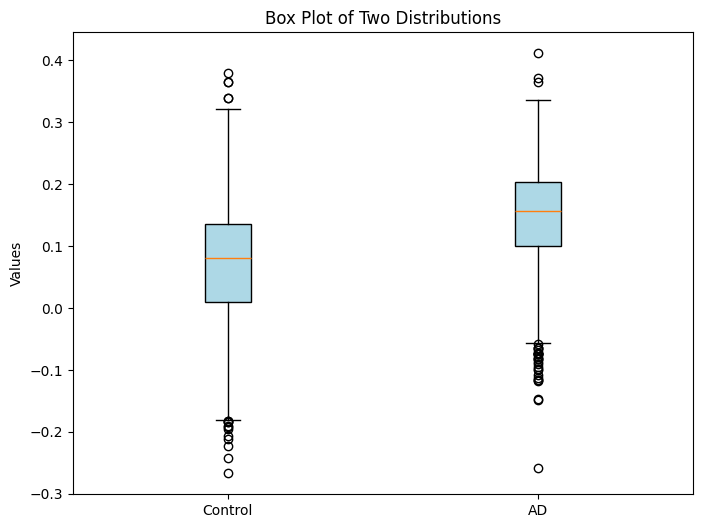

T-statistic: 32.138419809696074
P-value: 2.797352365516751e-198


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


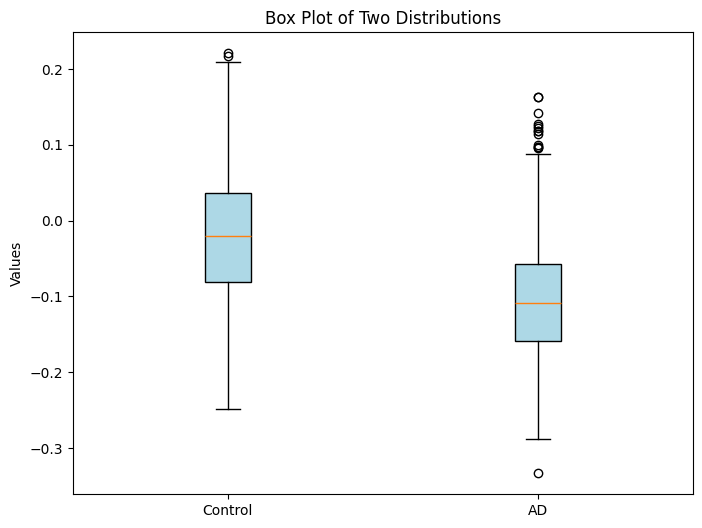

T-statistic: -6.212572190904984
P-value: 5.839293789177581e-10


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


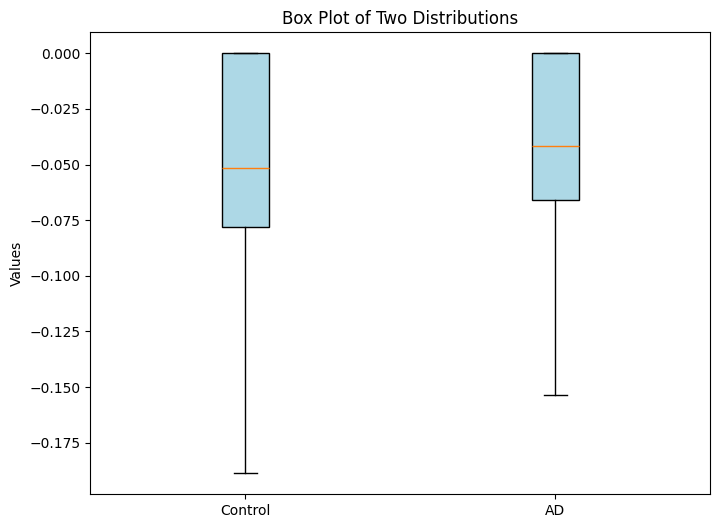

T-statistic: -26.247056204029676
P-value: 1.6889695592405784e-138


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


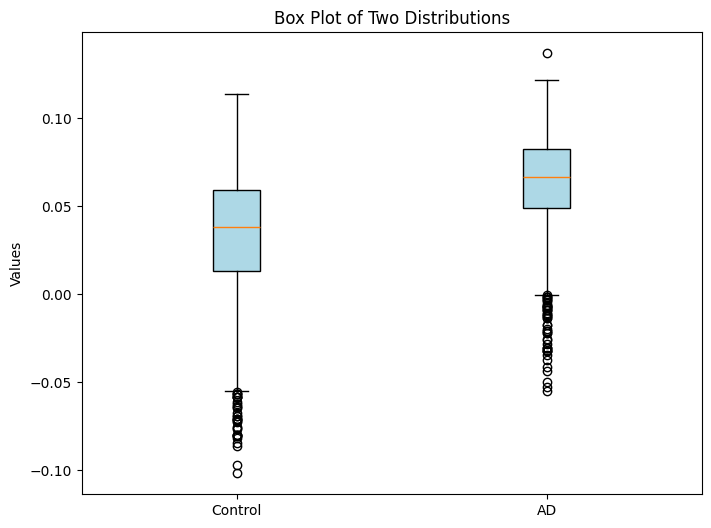

T-statistic: 10.66172578852239
P-value: 3.934640687951465e-26


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


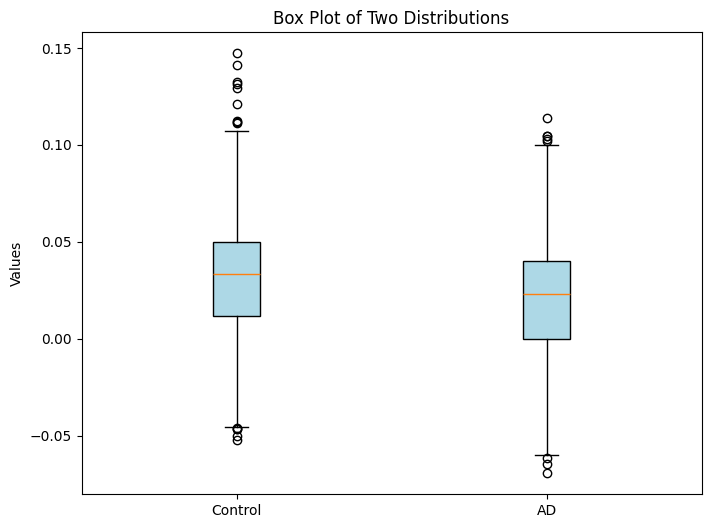

T-statistic: 21.281986456128617
P-value: 1.7175484830998083e-94


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


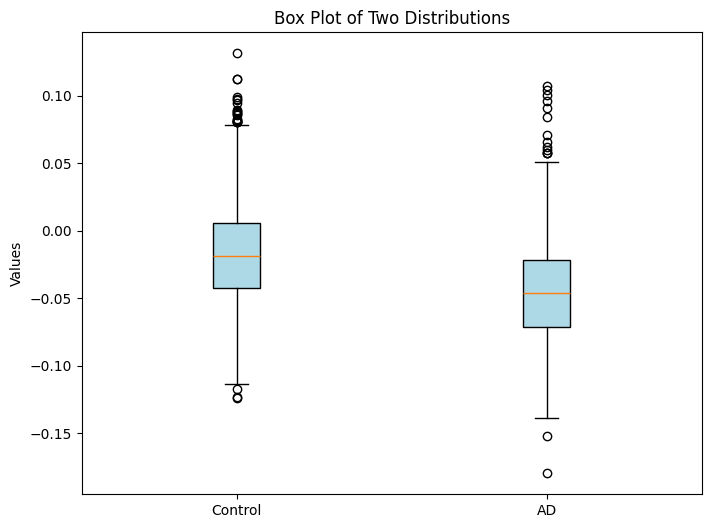

T-statistic: 16.537501004259546
P-value: 3.6729751376546174e-59


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


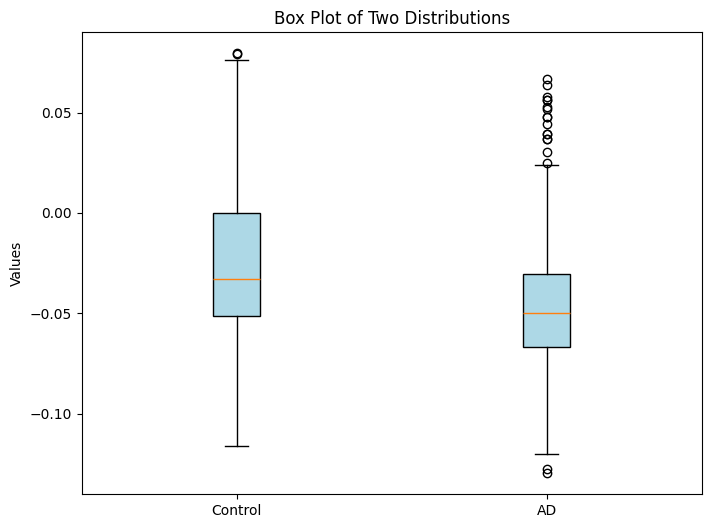

T-statistic: 7.712796746309709
P-value: 1.6029875952868858e-14


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


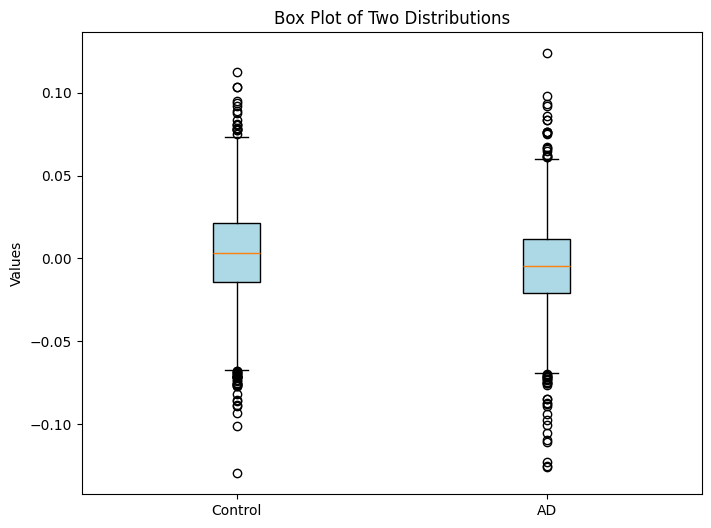

T-statistic: -10.75778753007281
P-value: 1.441751232625479e-26


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


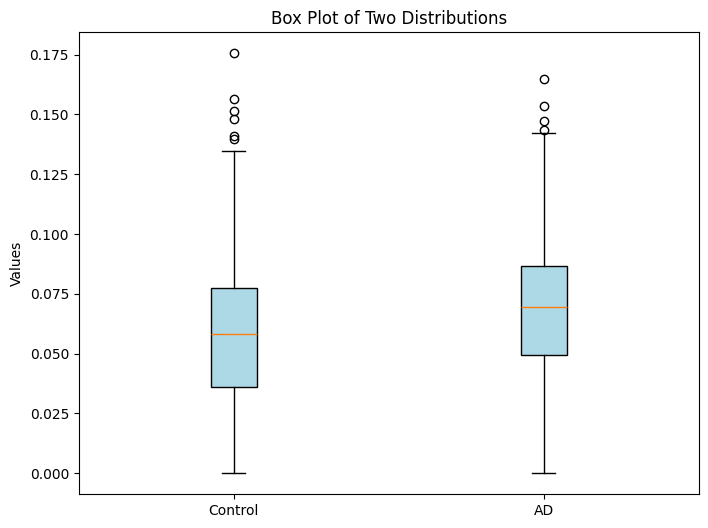

T-statistic: -18.21978754292435
P-value: 7.267004448159484e-71


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


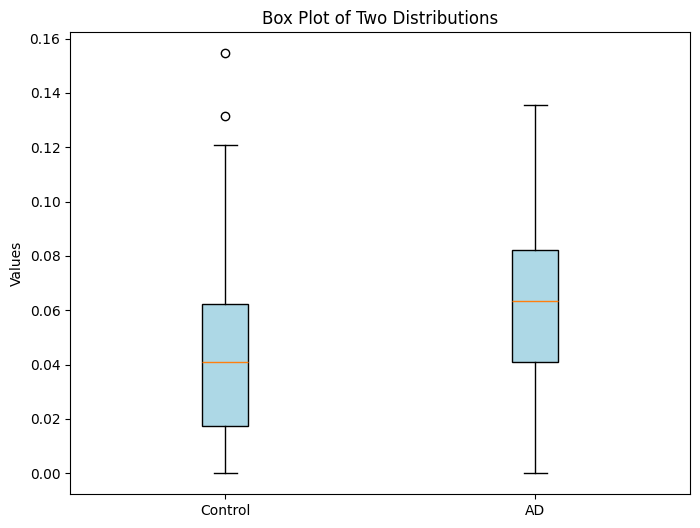

T-statistic: 30.83432912874877
P-value: 1.9344028201064276e-184


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


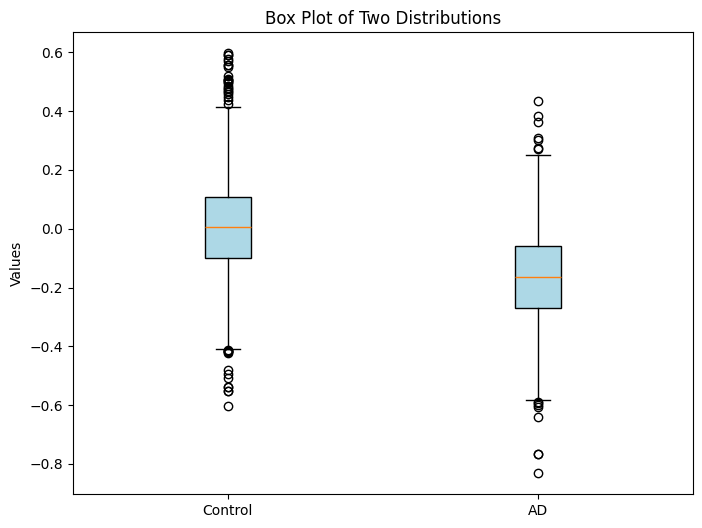

T-statistic: 14.406311965735899
P-value: 1.001670099345142e-45


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


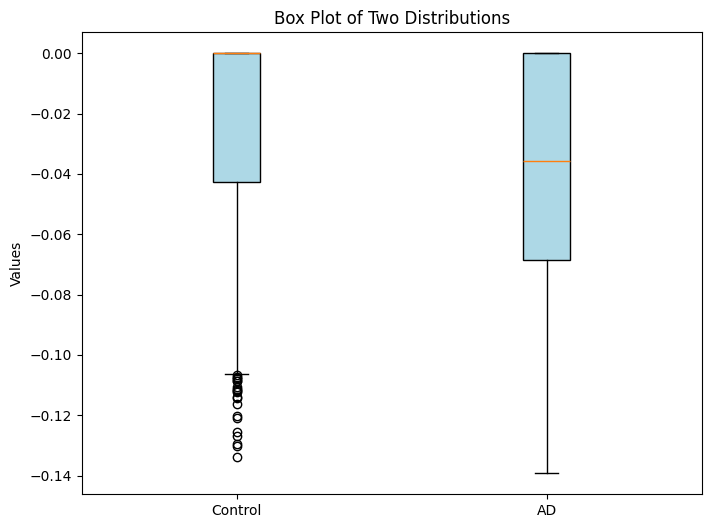

T-statistic: 22.671656615044874
P-value: 3.8819064140025337e-106


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


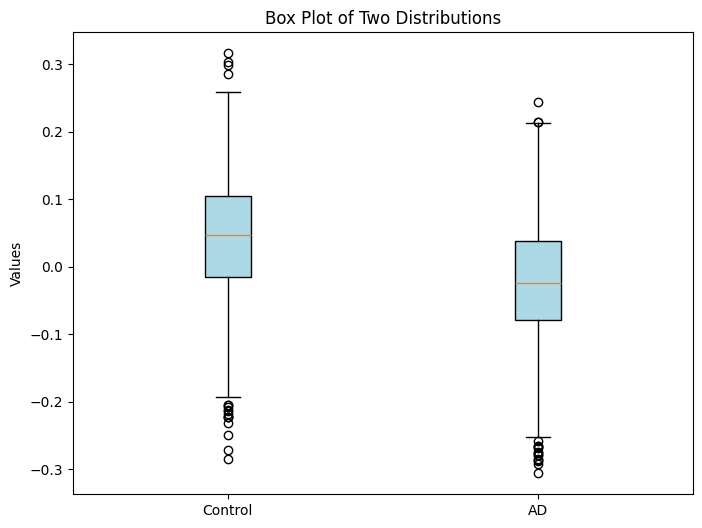

T-statistic: -31.35440853636211
P-value: 6.381904380182953e-190


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


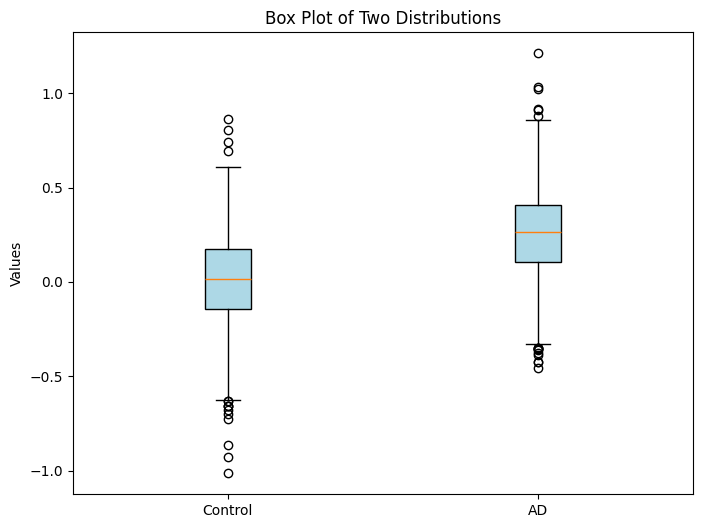

T-statistic: 12.722759292361689
P-value: 2.8933706957565955e-36


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


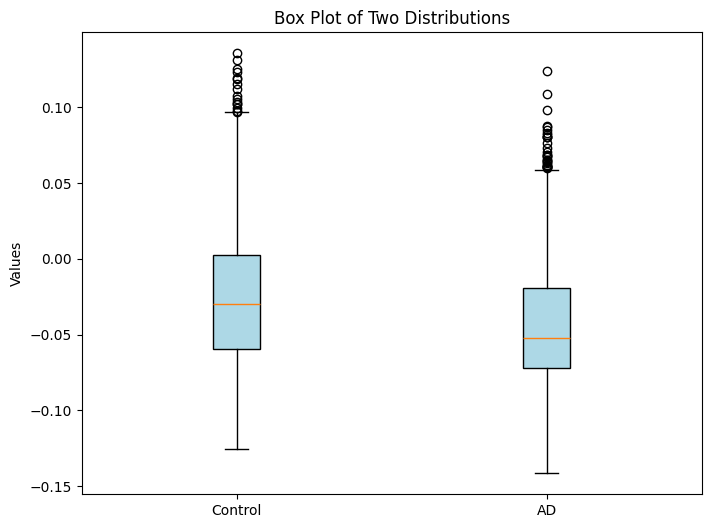

T-statistic: 7.44850354901426
P-value: 1.188713090373421e-13


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


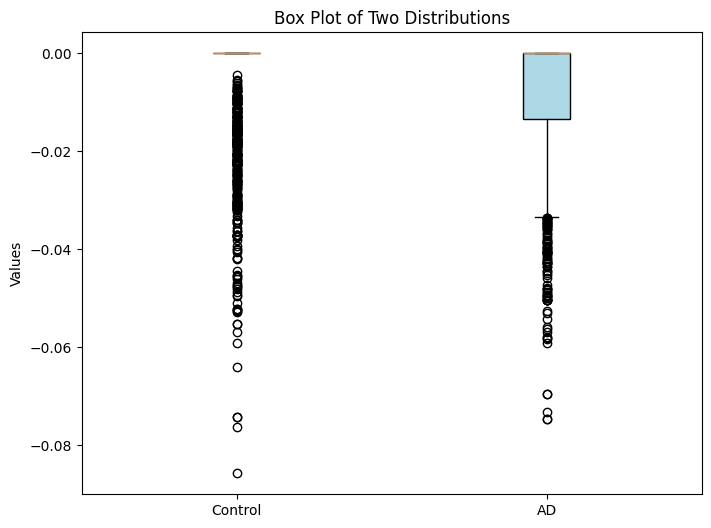

T-statistic: -12.805473824695984
P-value: 1.0497138913543828e-36


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


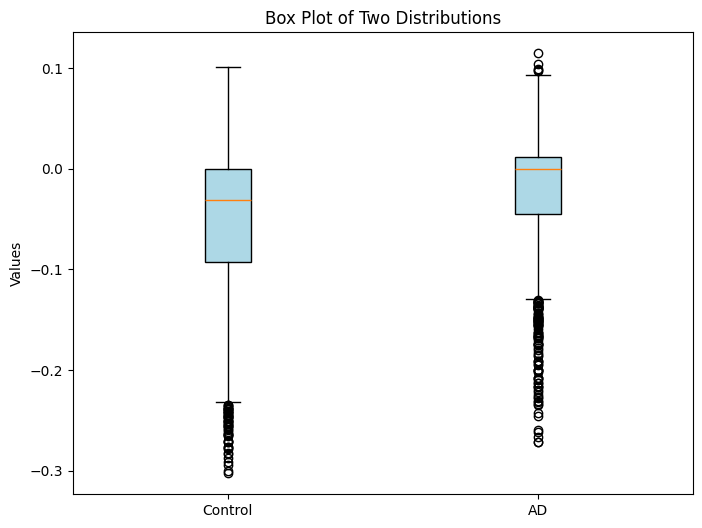

T-statistic: 5.336482832980939
P-value: 1.009301545160153e-07


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


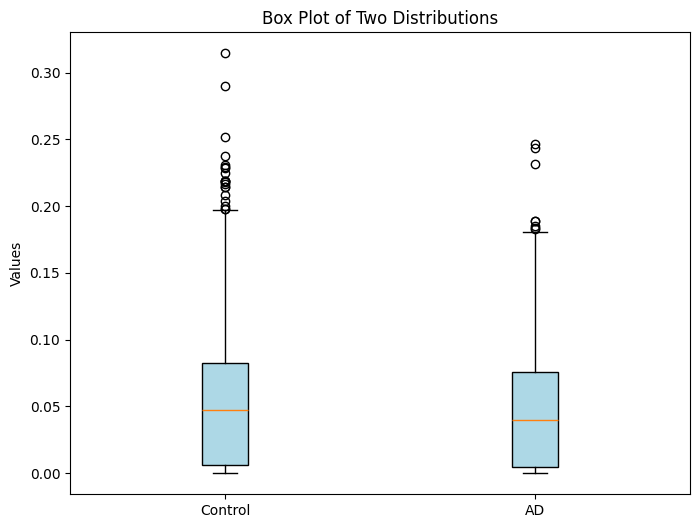

T-statistic: -8.018122253831406
P-value: 1.460268018370188e-15


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


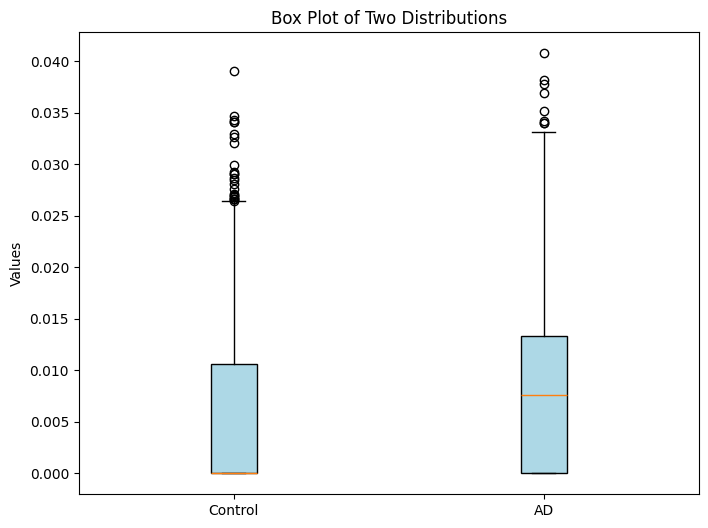

T-statistic: -37.55596909783784
P-value: 8.799556624754193e-259


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


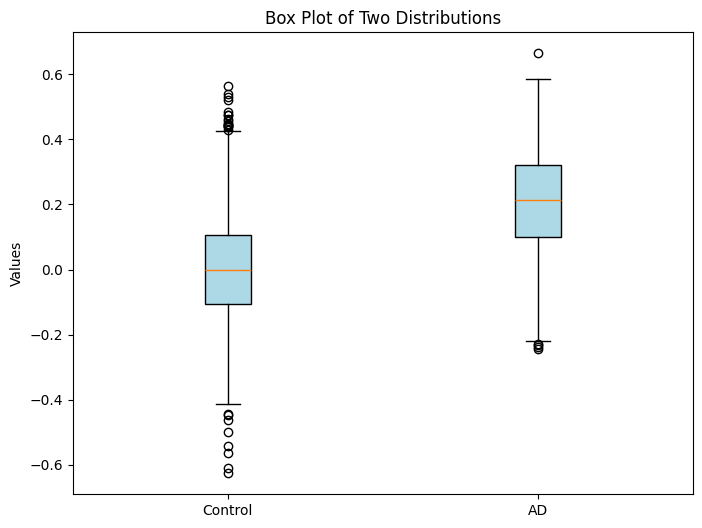

T-statistic: -15.354614097672734
P-value: 1.6570603411606633e-51


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


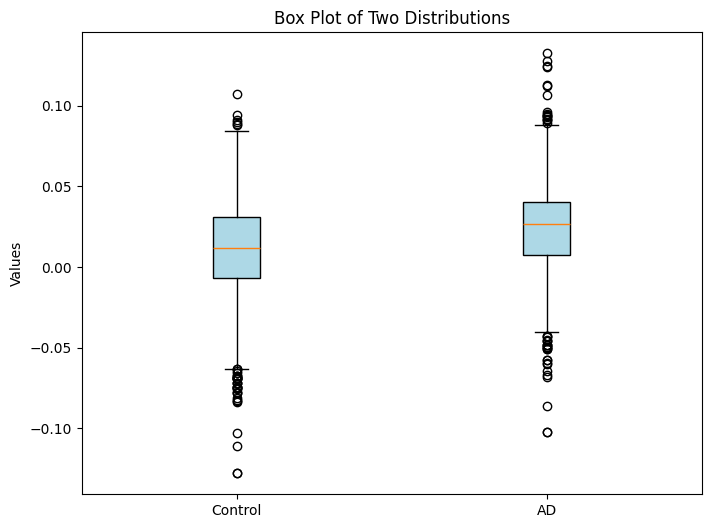

T-statistic: 13.486609536351072
P-value: 1.986939259344518e-40


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


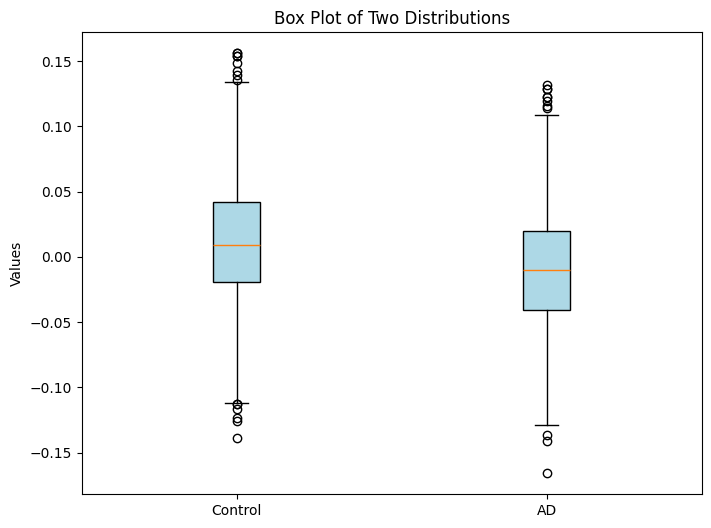

T-statistic: -19.994919158930887
P-value: 3.289601218788532e-84


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


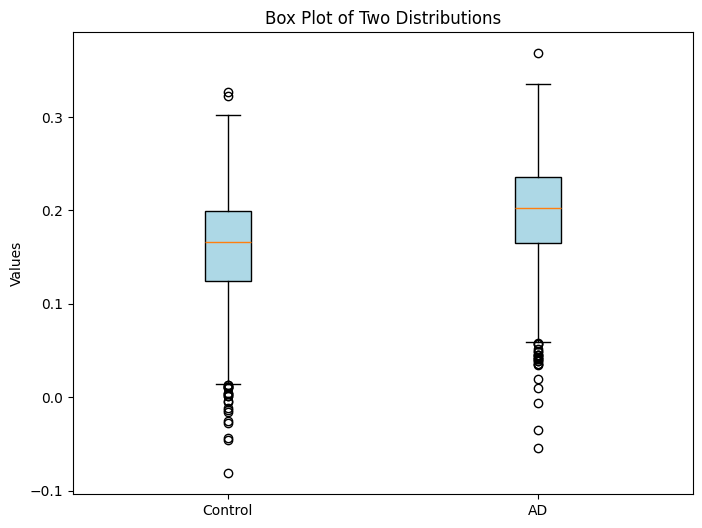

T-statistic: 17.436665001656497
P-value: 2.6708410801812055e-65


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


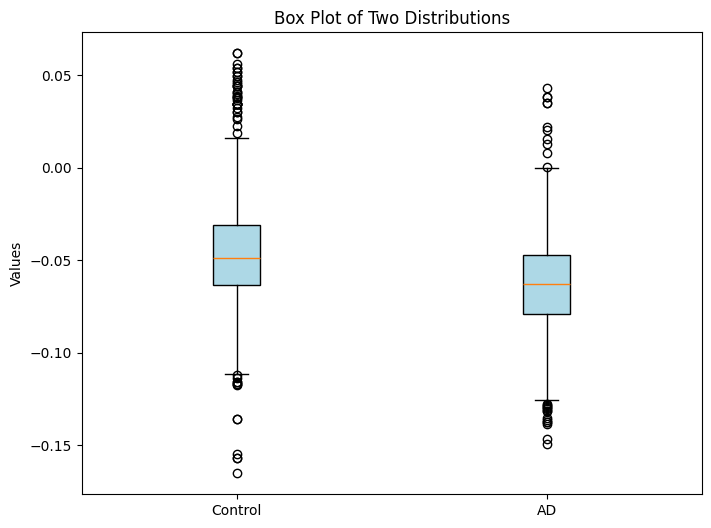

T-statistic: 12.541502637482896
P-value: 2.6143455893631205e-35


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


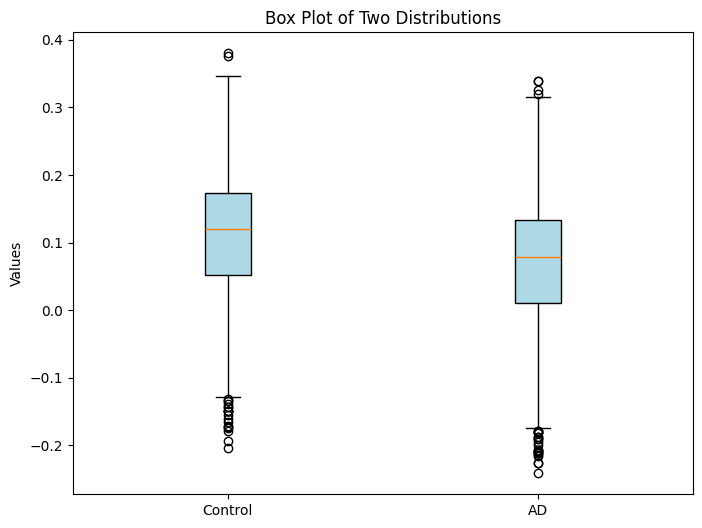

T-statistic: -19.06225280446022
P-value: 4.490448333062841e-77


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


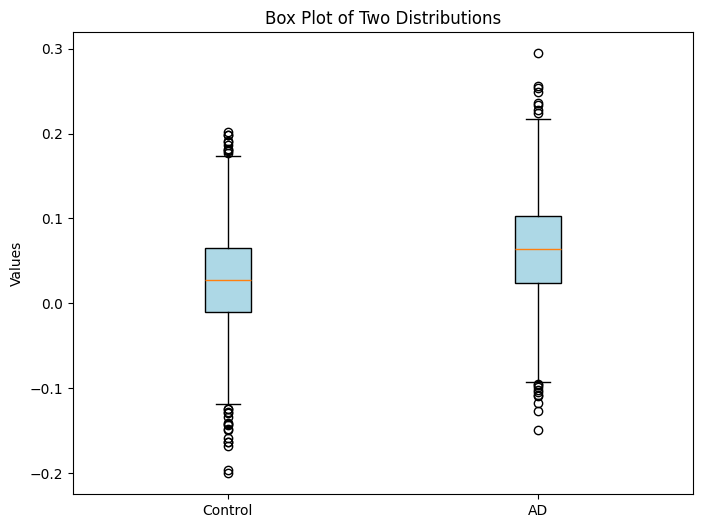

T-statistic: 25.63595288310037
P-value: 9.759673221119815e-133


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


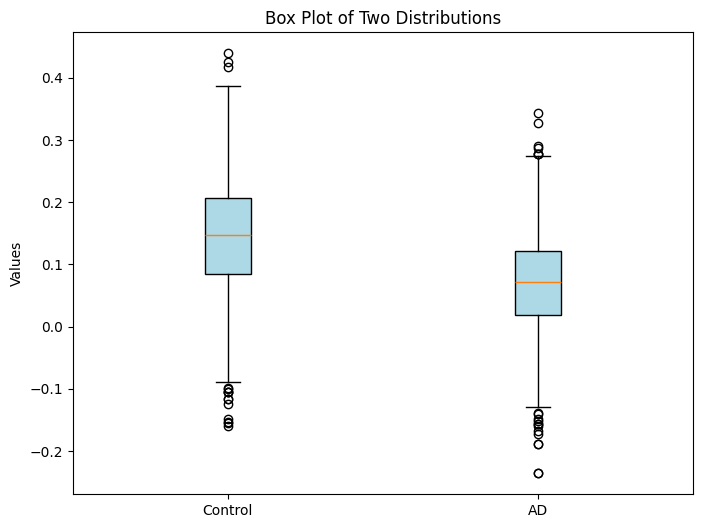

T-statistic: -18.94131164445455
P-value: 3.610507127117602e-76


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


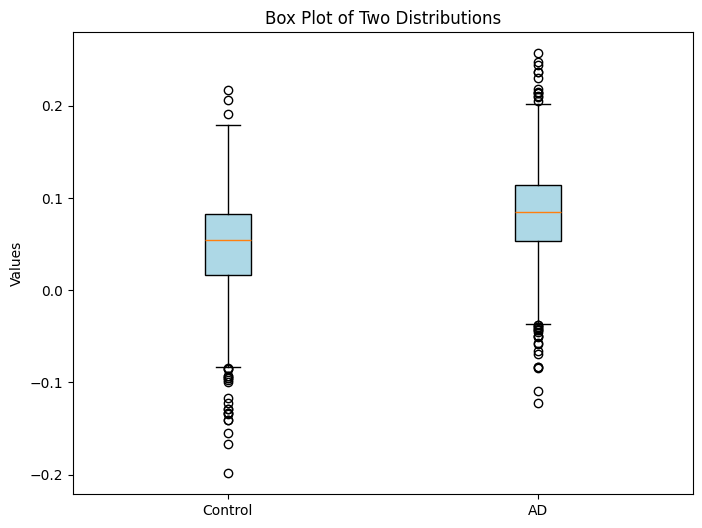

T-statistic: -7.313914852154544
P-value: 3.2157563100960713e-13


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


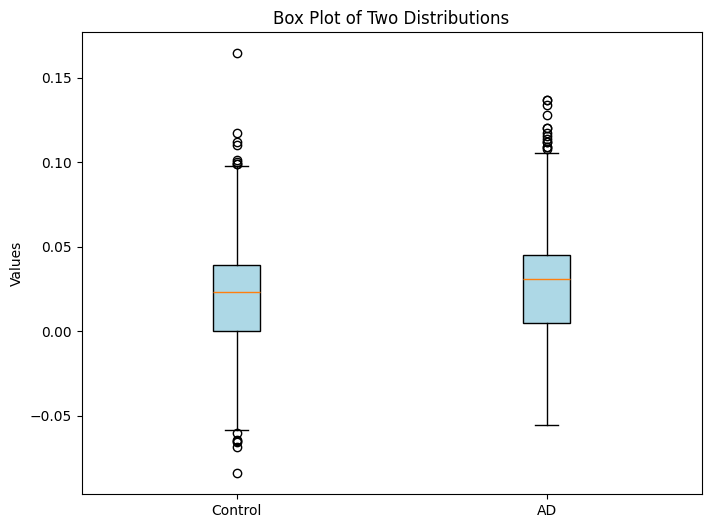

T-statistic: 15.402906724515343
P-value: 8.248648908351067e-52


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


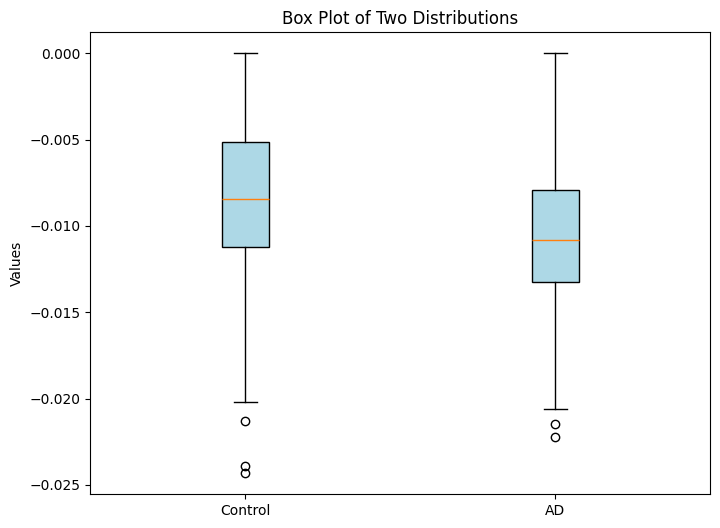

T-statistic: -12.594229436835363
P-value: 1.3821347293564648e-35


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


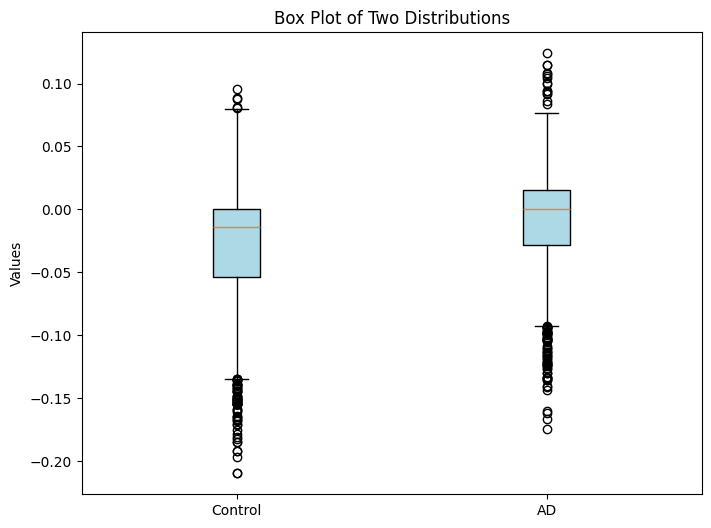

T-statistic: -4.723196933959442
P-value: 2.4149494333896305e-06


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


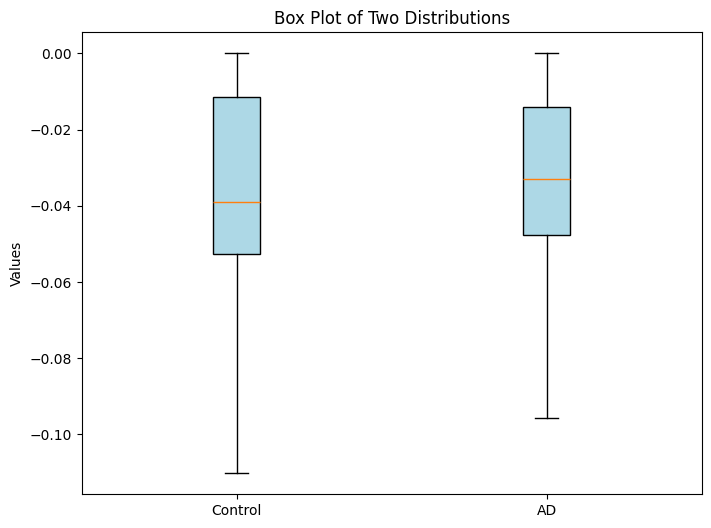

T-statistic: 10.9976546955896
P-value: 1.1337071402859407e-27


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


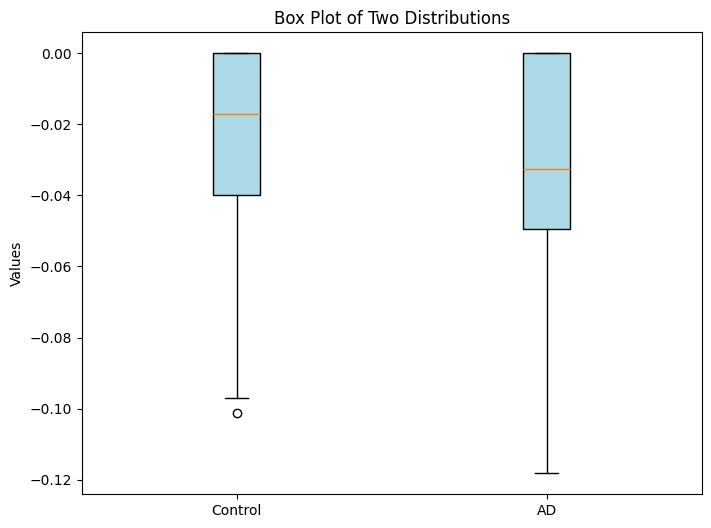

T-statistic: 18.789198026950988
P-value: 4.893185453872251e-75


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


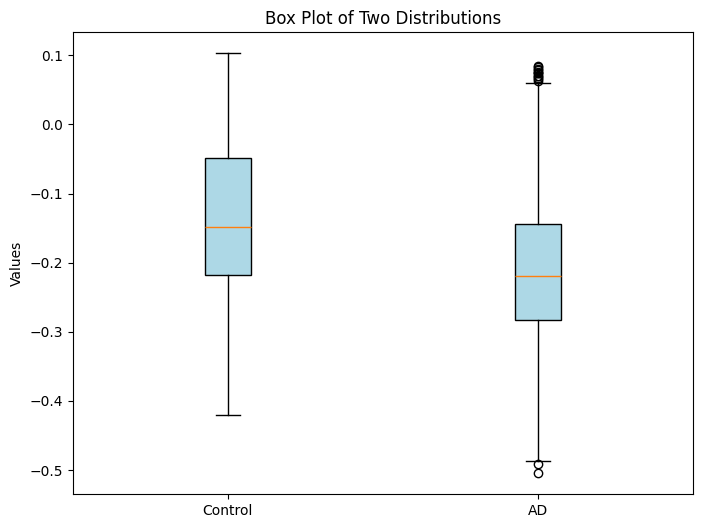

T-statistic: -36.14853896751084
P-value: 1.2050375155381703e-242


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


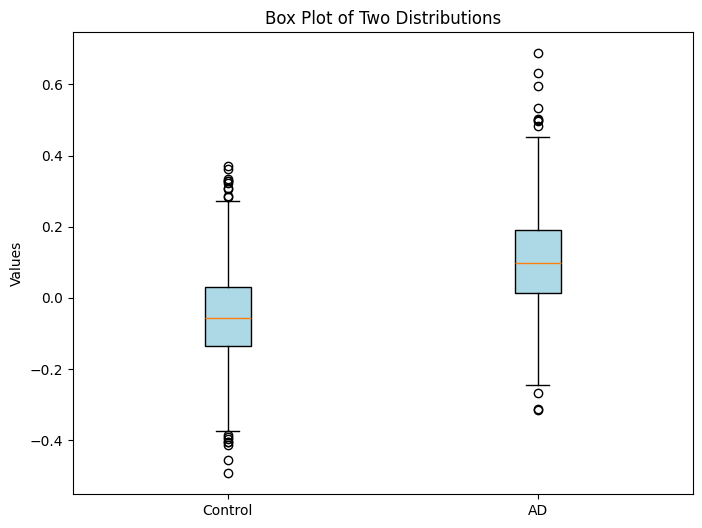

T-statistic: 30.72064664732087
P-value: 3.0053851407091558e-183


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


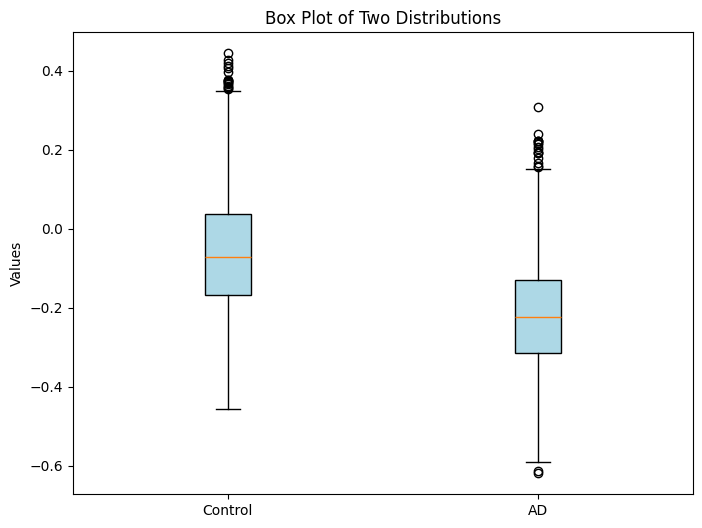

T-statistic: 10.519489853307277
P-value: 1.7135480860834514e-25


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


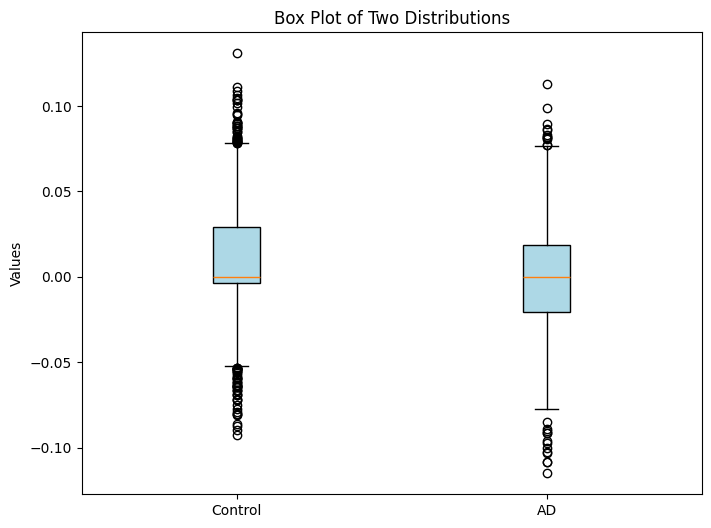

T-statistic: 13.251117220065998
P-value: 4.025082884536155e-39


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


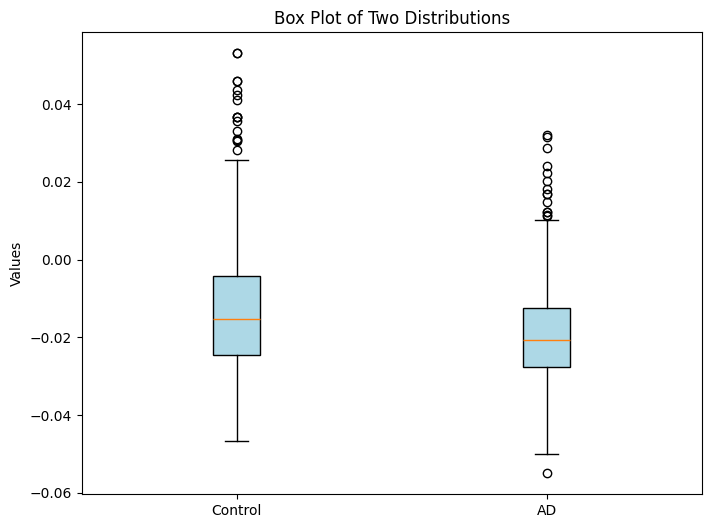

T-statistic: 32.67495778452068
P-value: 4.60579995942468e-204


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


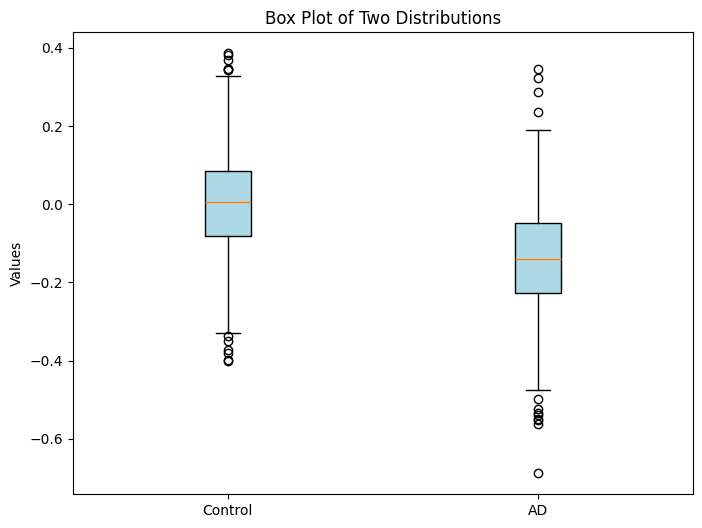

T-statistic: 19.854465257269514
P-value: 4.0635212648736645e-83


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


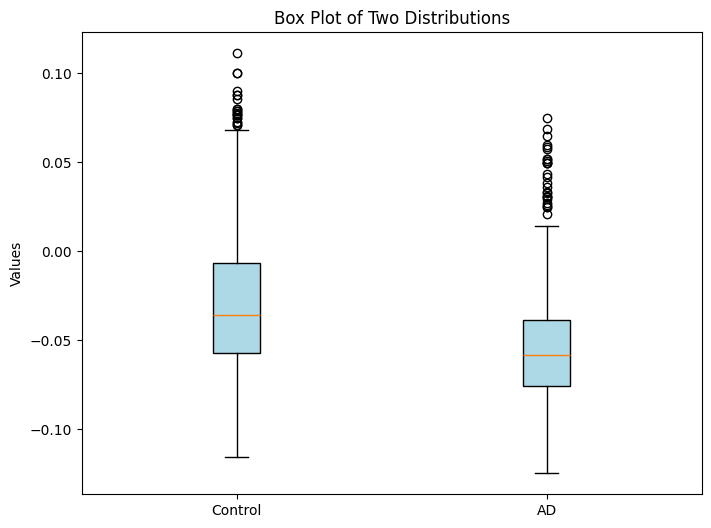

T-statistic: -23.37205868152667
P-value: 3.2670198854962226e-112


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


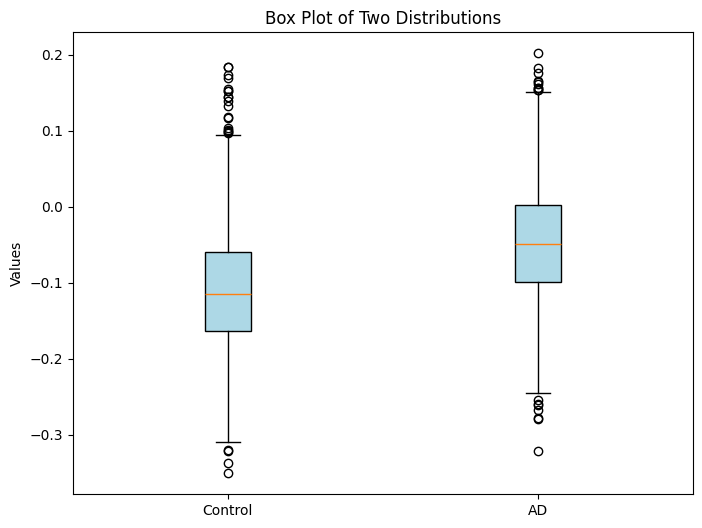

T-statistic: 10.711925123536085
P-value: 2.3307909233526482e-26


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


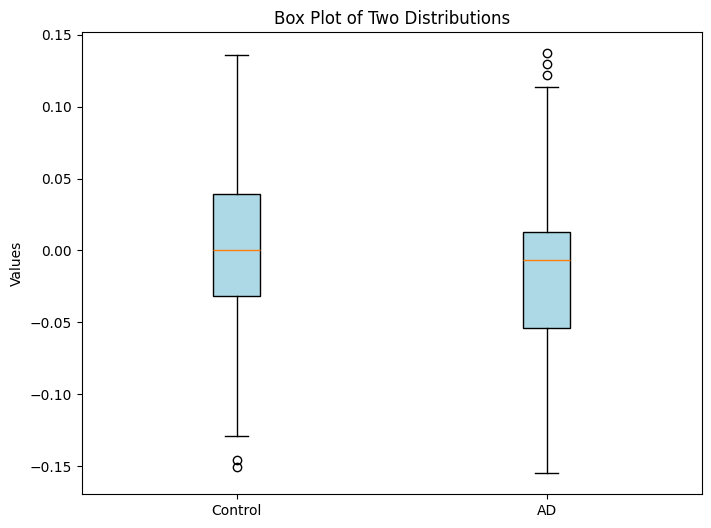

T-statistic: -10.464140905244268
P-value: 3.0228444558400334e-25


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


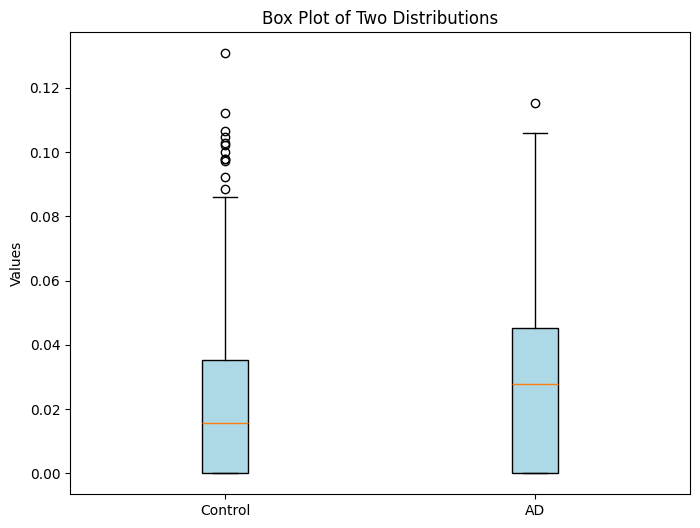

T-statistic: -29.830437660280523
P-value: 5.244261887058978e-174


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


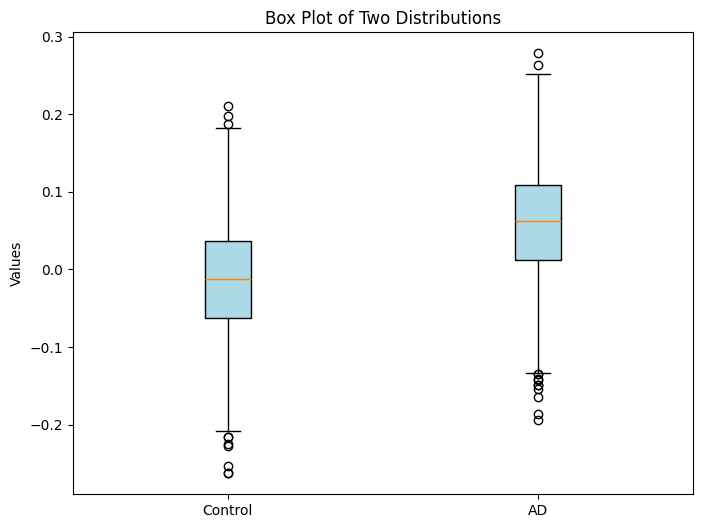

T-statistic: -9.235741458541446
P-value: 4.3802125191176595e-20


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


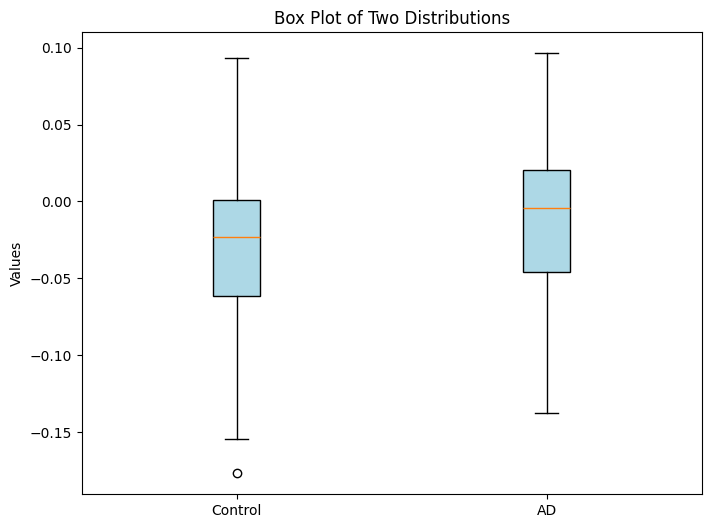

T-statistic: -12.083642795030192
P-value: 5.984590945404837e-33


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


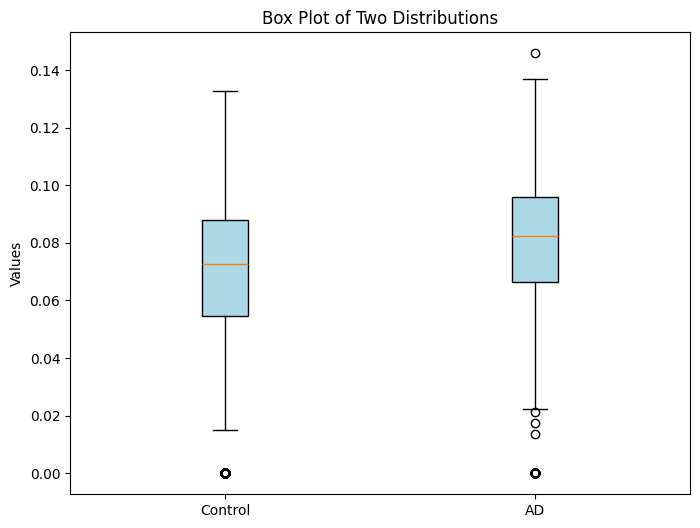

T-statistic: 41.87509143572501
P-value: 8.84873484596266e-310


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


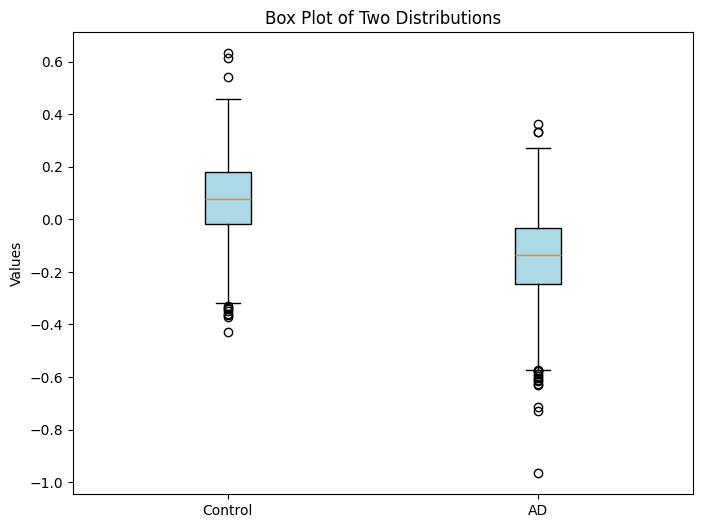

T-statistic: -21.511972733875883
P-value: 2.2173837985554025e-96


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


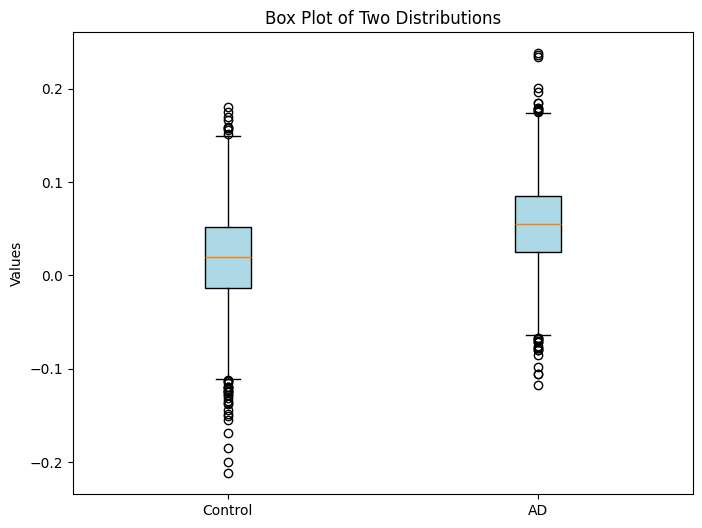

T-statistic: -4.001359782514394
P-value: 6.431320741082394e-05


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


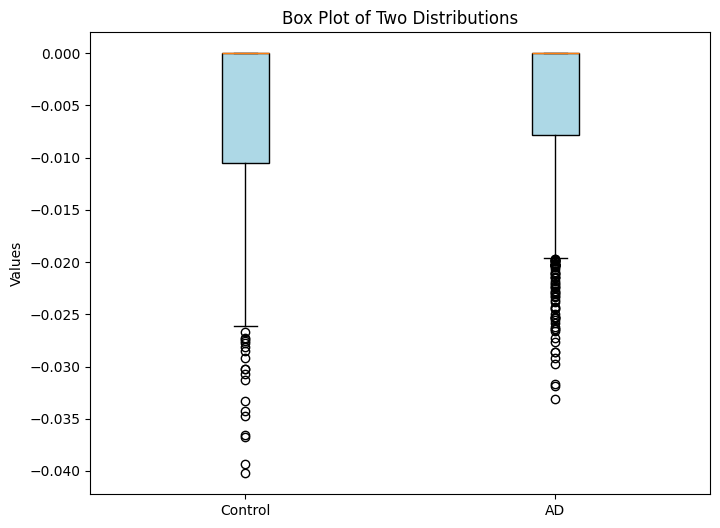

T-statistic: 45.866479392510556
P-value: 0.0


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


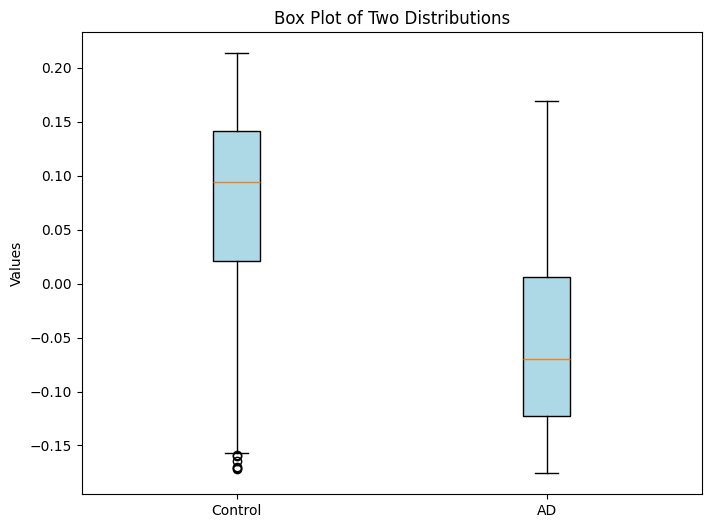

T-statistic: 11.690726126238024
P-value: 5.477890864782868e-31


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


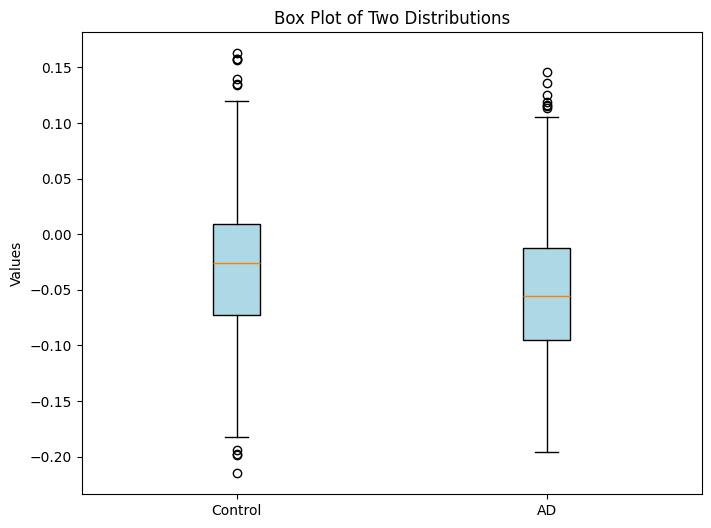

T-statistic: -3.078909804557791
P-value: 0.0020940698757680102


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


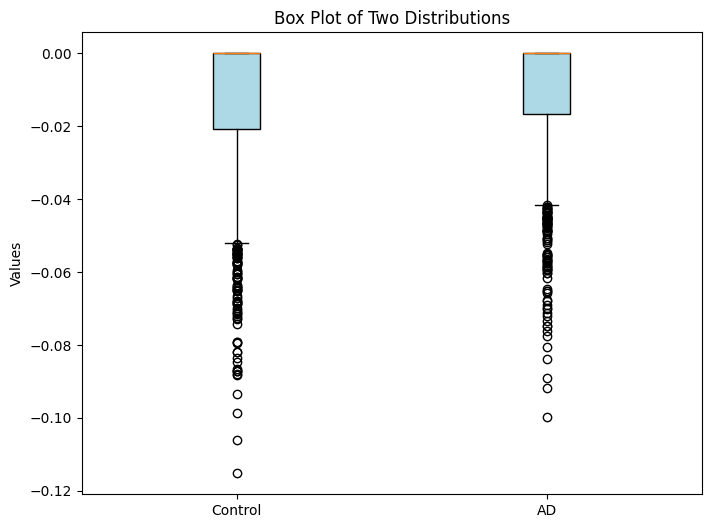

T-statistic: 11.035388627762504
P-value: 7.563739560572499e-28


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


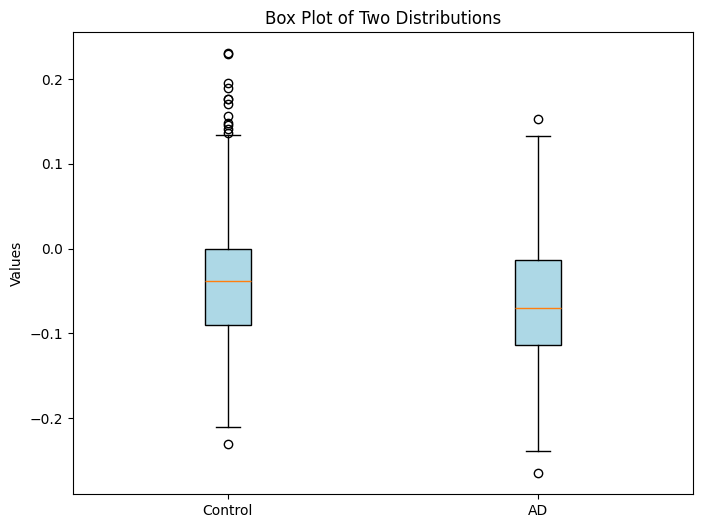

T-statistic: 12.584801554968132
P-value: 1.5492549467192466e-35


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


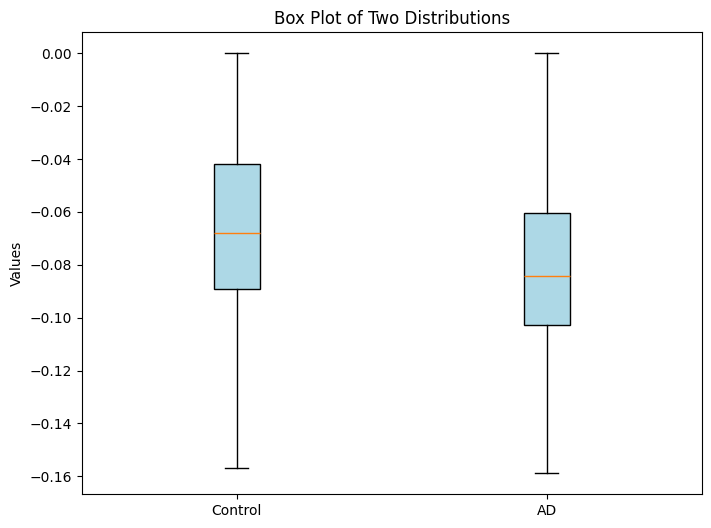

T-statistic: 15.350877136722614
P-value: 1.748828801465933e-51


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


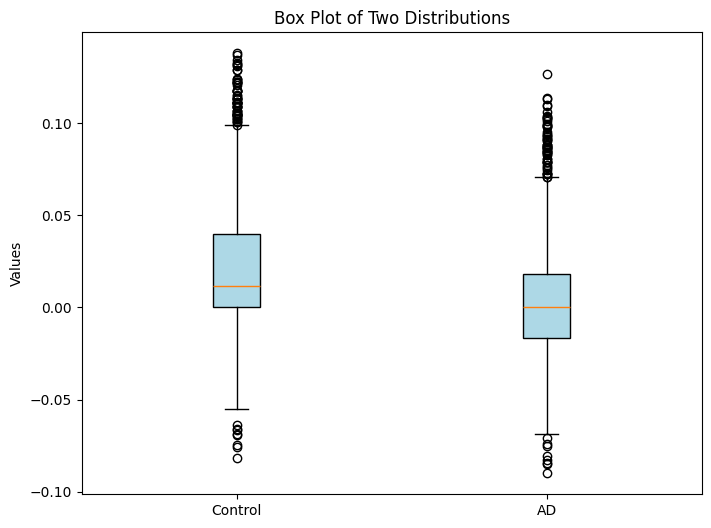

T-statistic: -21.45585451651714
P-value: 6.429956713309381e-96


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


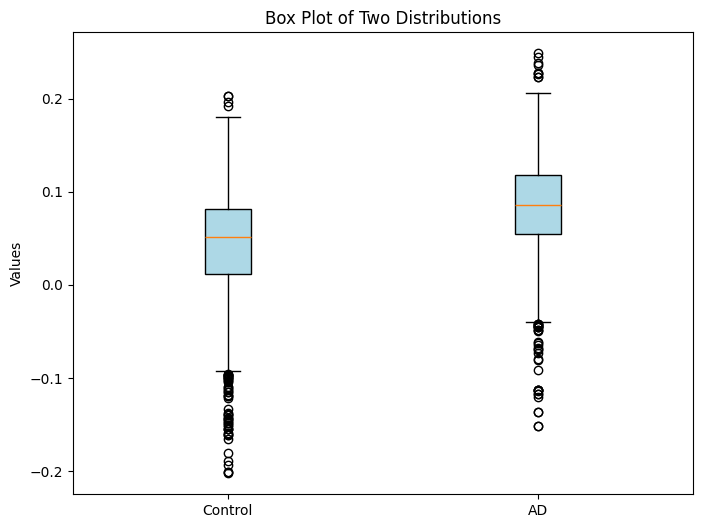

T-statistic: -21.146785540196284
P-value: 2.178739303309771e-93


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


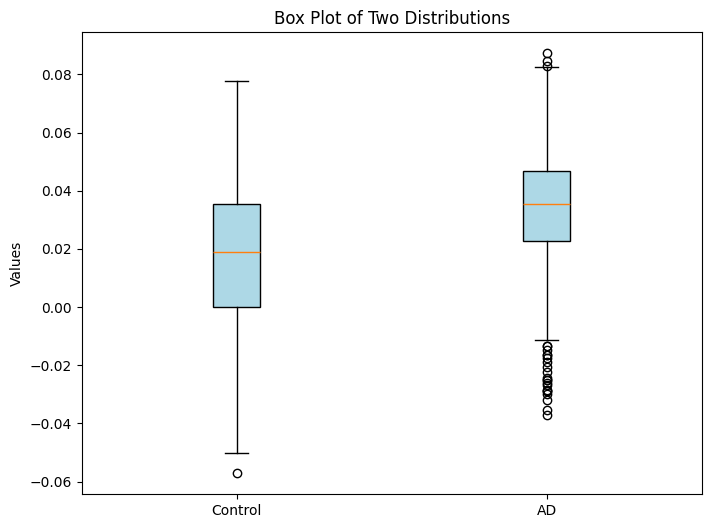

T-statistic: -7.210675090044042
P-value: 6.820589907625955e-13


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


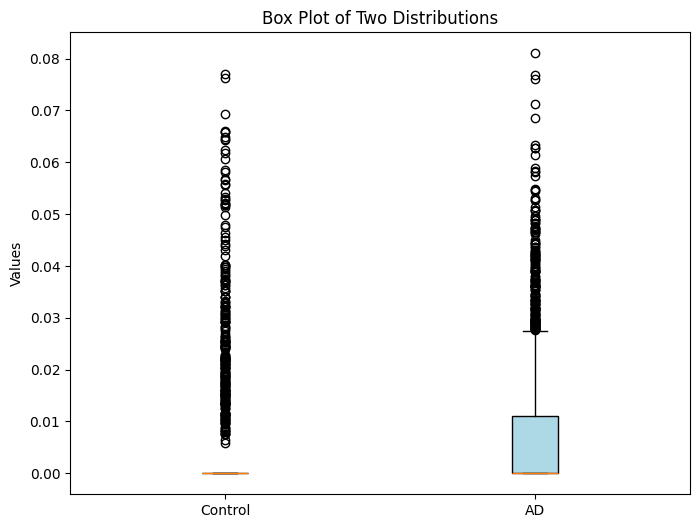

T-statistic: 44.38515362876959
P-value: 0.0


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


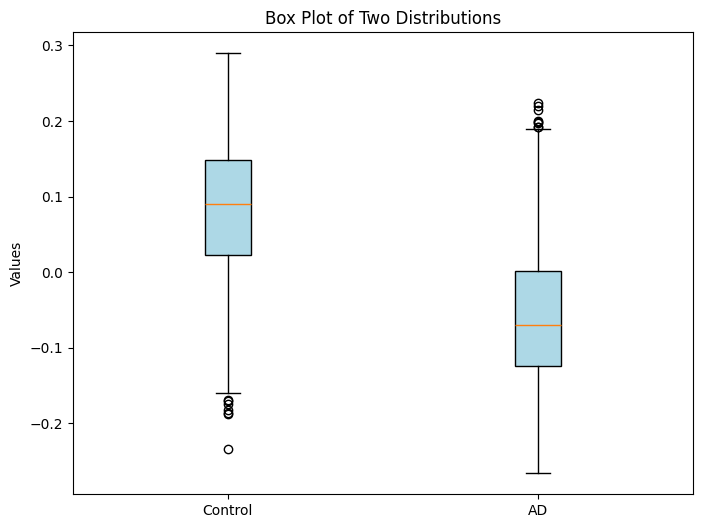

T-statistic: -17.241563490260194
P-value: 6.0481524134232306e-64


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


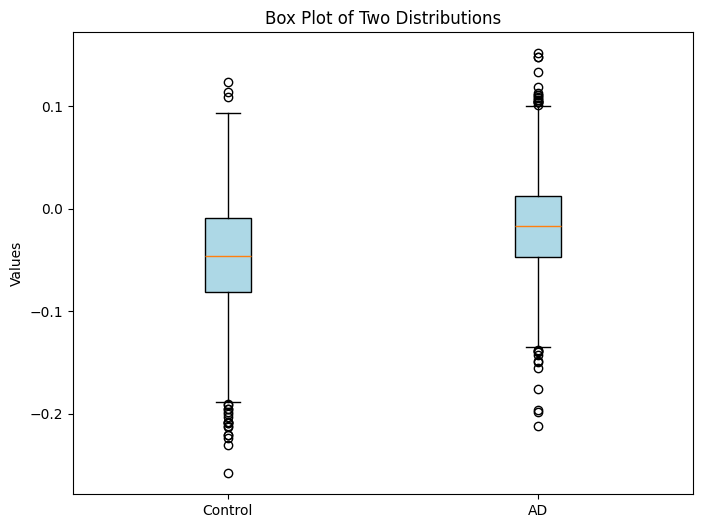

T-statistic: -3.1003657244140794
P-value: 0.0019485408075368888


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


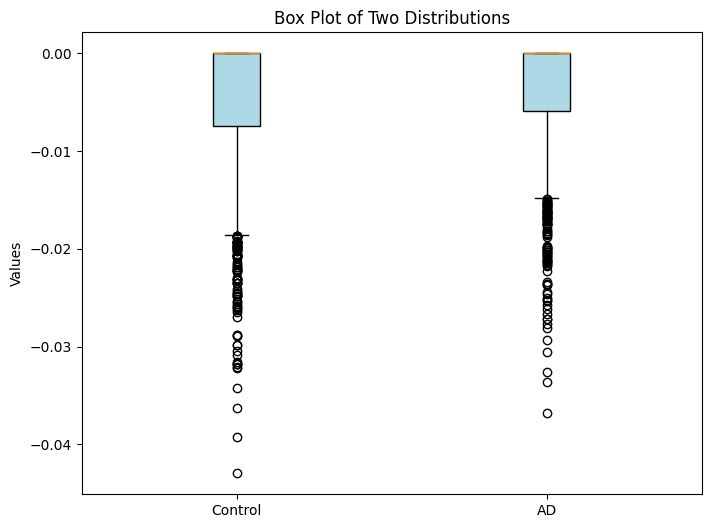

T-statistic: 21.45722041636731
P-value: 6.265634405625447e-96


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


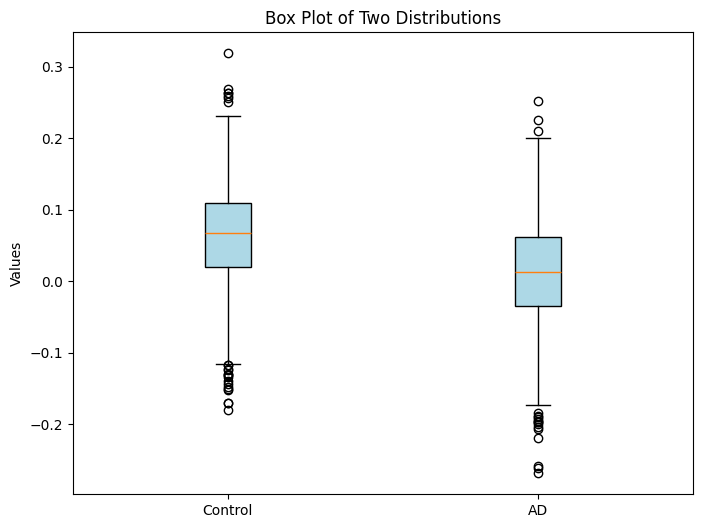

T-statistic: -20.30590506590345
P-value: 1.1977402370506222e-86


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


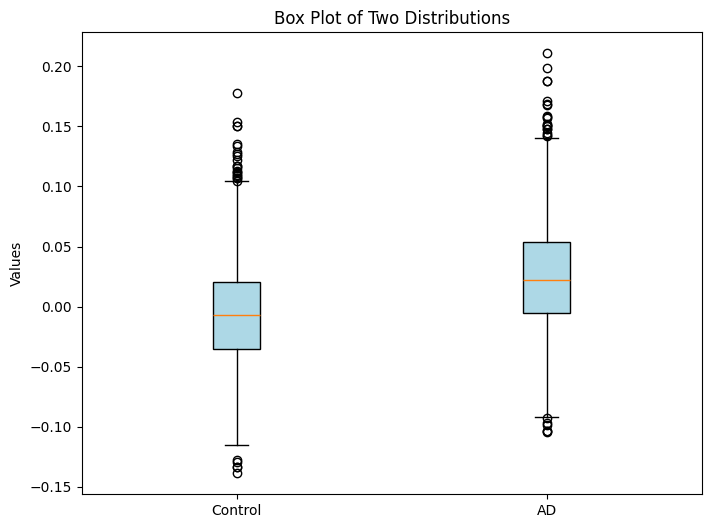

T-statistic: 7.944395985240758
P-value: 2.6250345112983656e-15


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


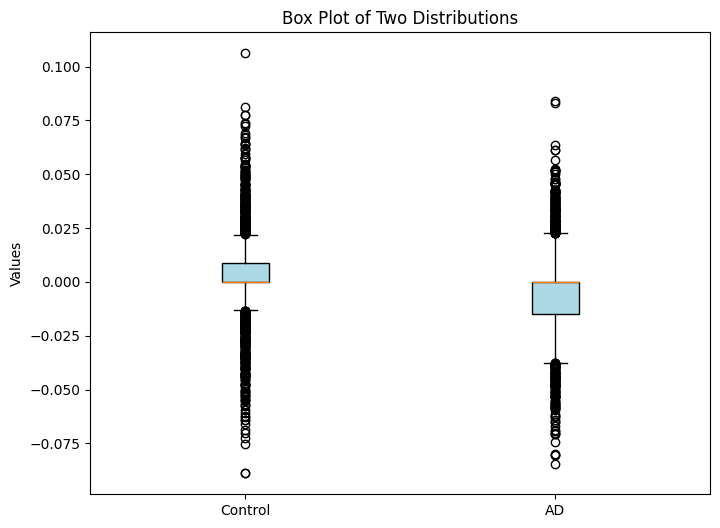

T-statistic: -13.285438851346338
P-value: 2.6038900433391438e-39


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


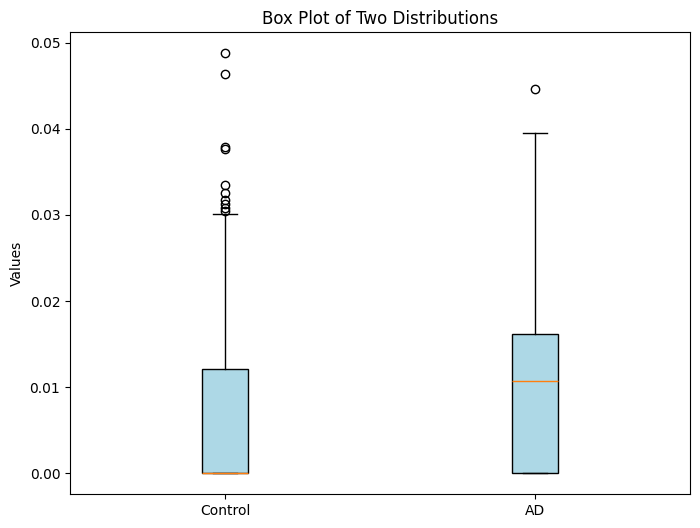

T-statistic: 18.802636701301406
P-value: 3.8893594521895967e-75


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


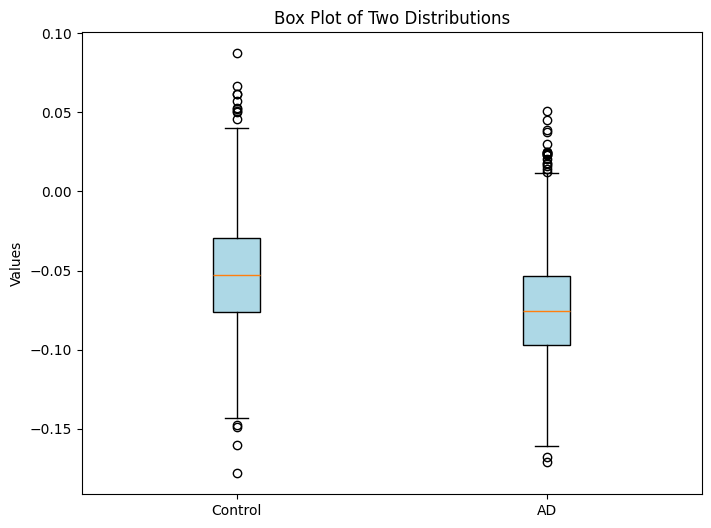

T-statistic: -24.46121404512253
P-value: 6.384626883564947e-122


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


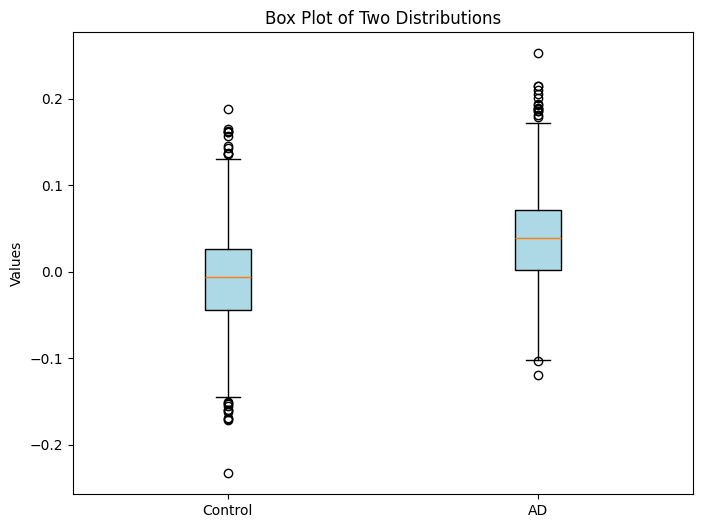

T-statistic: 26.239208390705862
P-value: 2.0053389202856703e-138


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


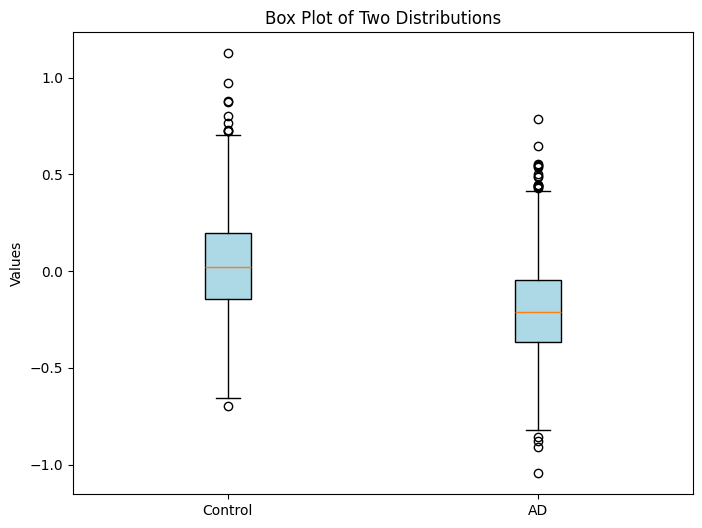

T-statistic: 17.429175322593938
P-value: 3.0122954947340895e-65


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


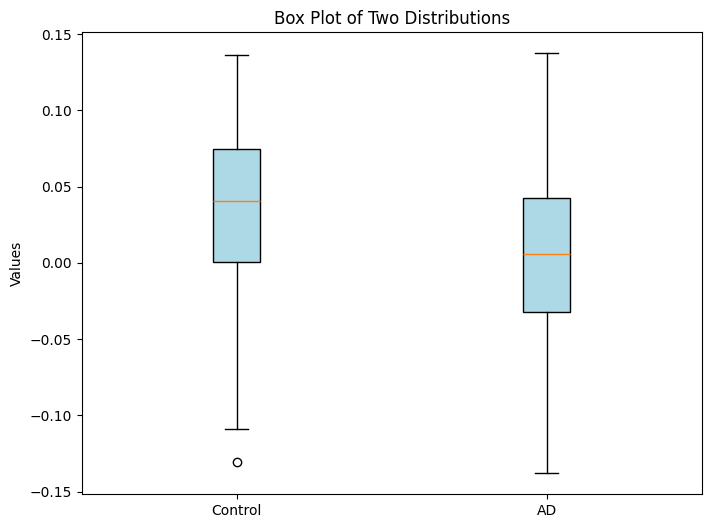

T-statistic: -15.60312133231891
P-value: 4.4836934416419585e-53


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


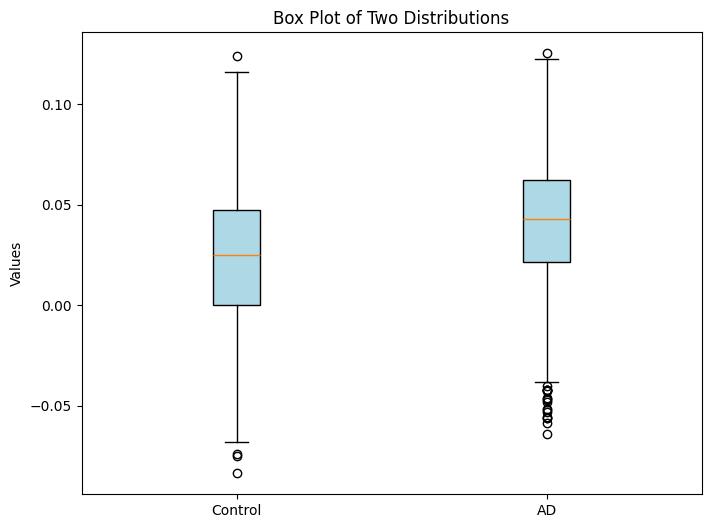

T-statistic: 16.565063495686157
P-value: 2.4038962471693276e-59


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


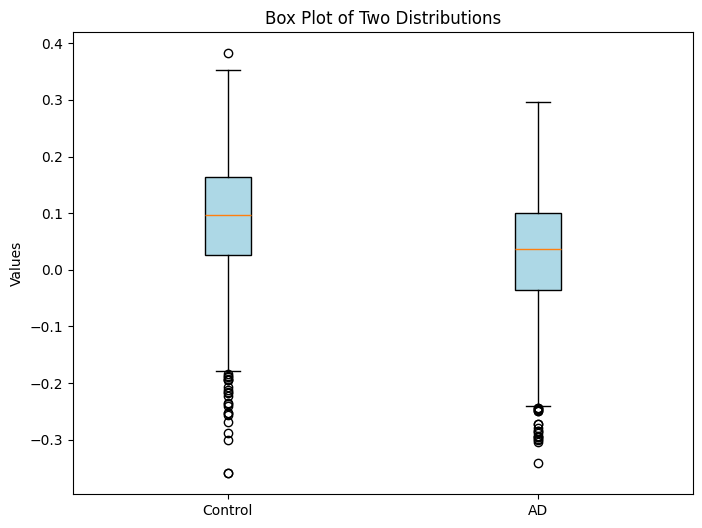

T-statistic: 24.520767488326484
P-value: 1.841963572116808e-122


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


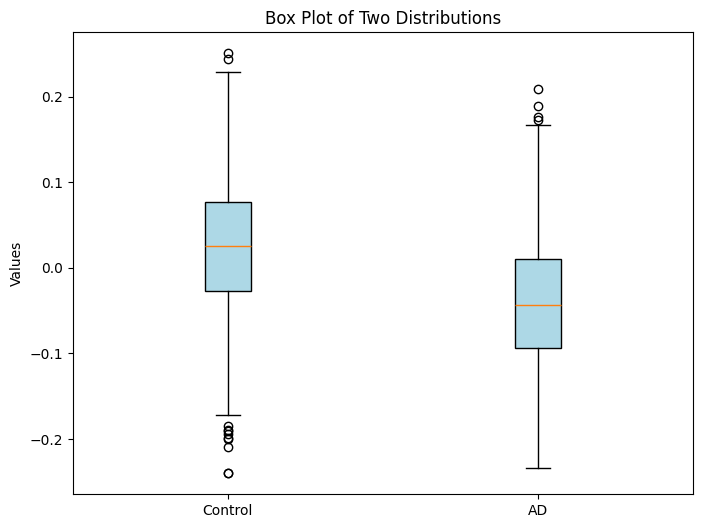

T-statistic: 3.5287313422005355
P-value: 0.0004230512077120699


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


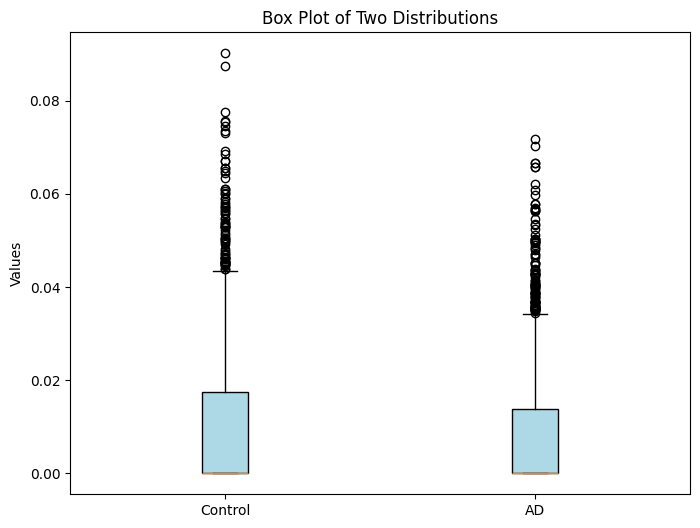

T-statistic: -29.584058334901783
P-value: 1.7763921396239989e-171


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


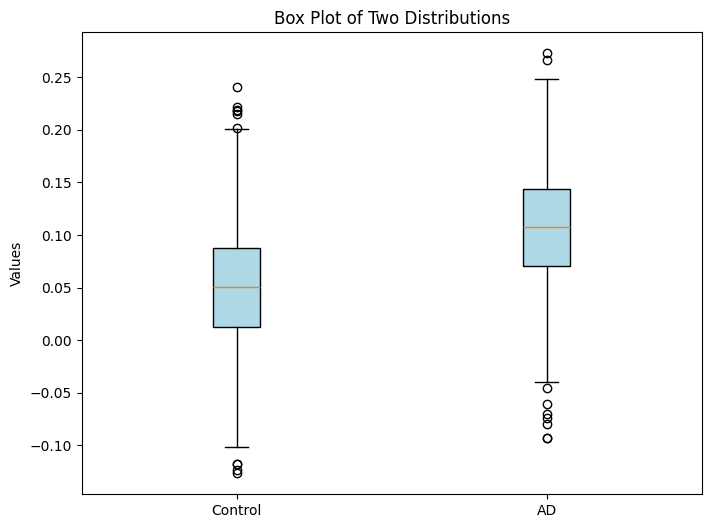

T-statistic: 25.01978596317117
P-value: 5.080346176037916e-127


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


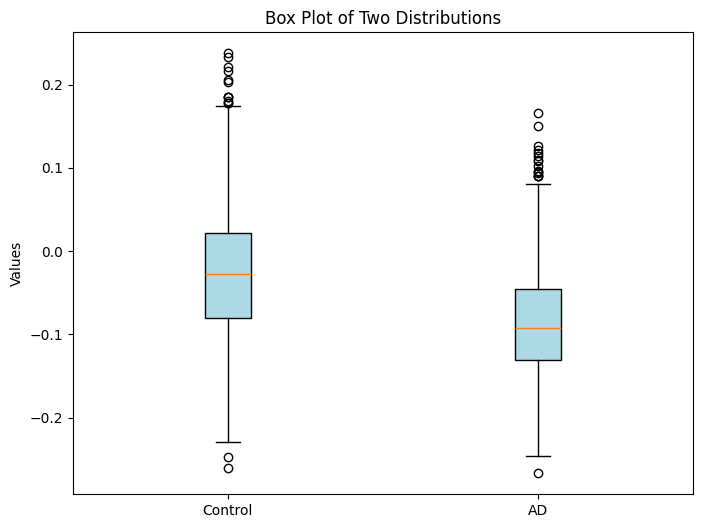

T-statistic: 26.187589170097358
P-value: 6.198396652598885e-138


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


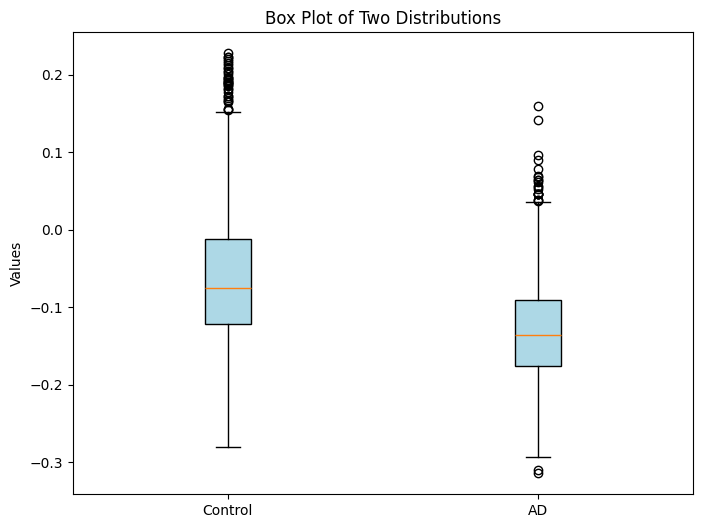

T-statistic: 12.623535780175887
P-value: 9.688182416597724e-36


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


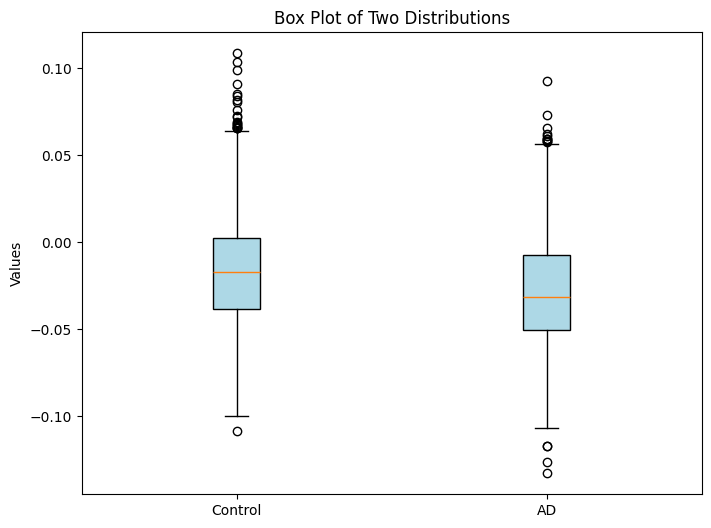

T-statistic: -6.376280540156771
P-value: 2.0573433514454947e-10


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


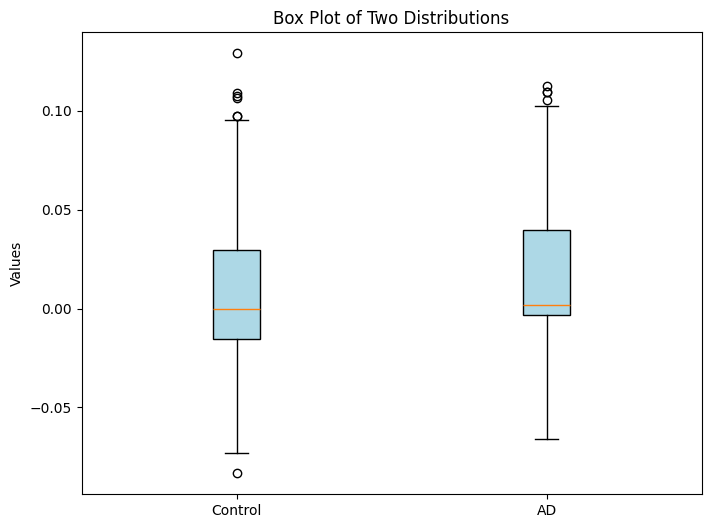

T-statistic: -9.818539593502873
P-value: 1.849901241613089e-22


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


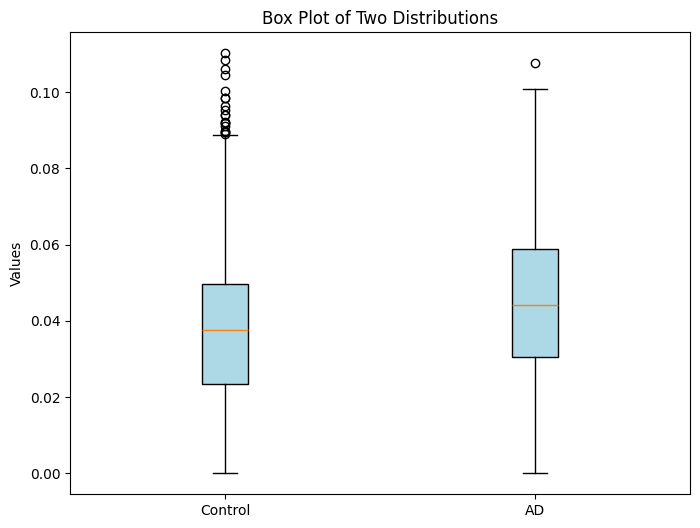

T-statistic: 15.157192160070826
P-value: 2.8137255197904116e-50


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


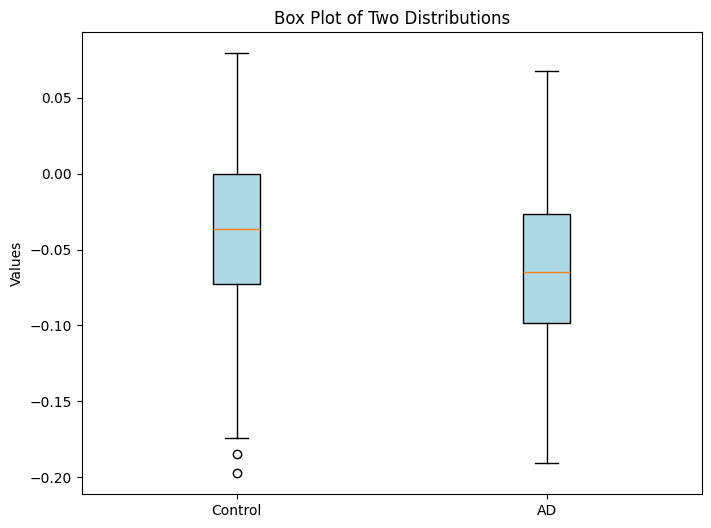

T-statistic: -5.490951305520235
P-value: 4.2891311581226094e-08


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


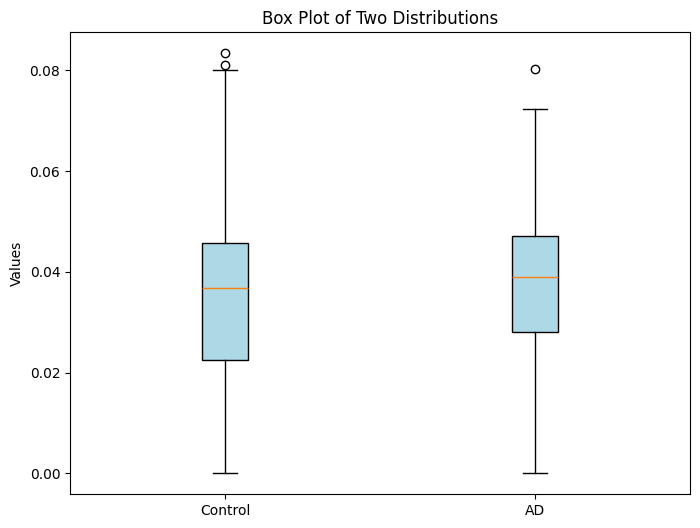

T-statistic: 1.8675877870867794
P-value: 0.06190497088165821


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


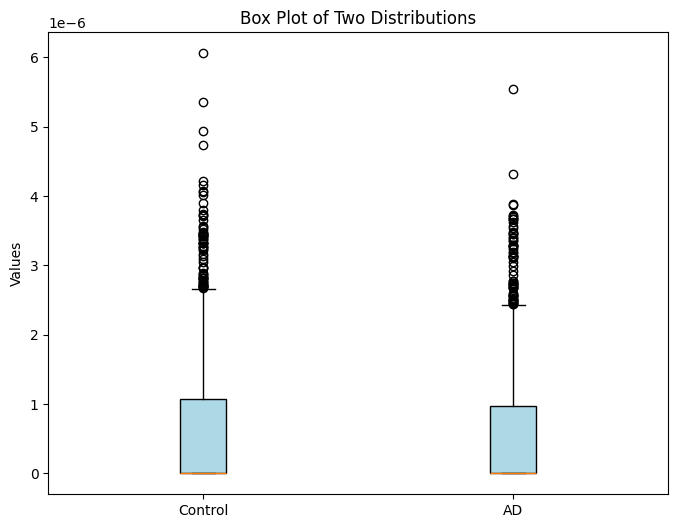

T-statistic: -3.6552746875976005
P-value: 0.00026076634193358437


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


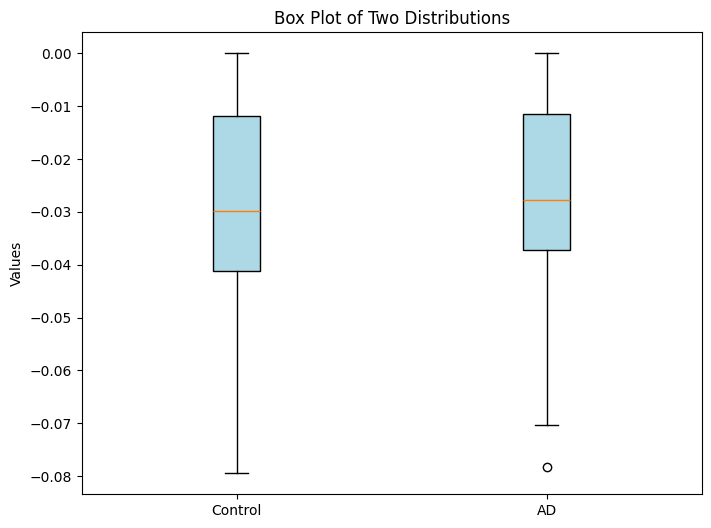

T-statistic: -14.02350428978574
P-value: 1.7503143571270752e-43


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


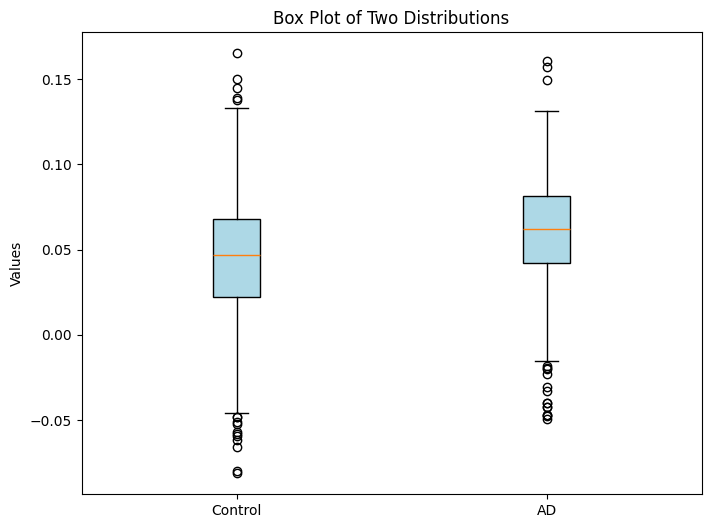

T-statistic: 14.340012736418101
P-value: 2.4710694786649164e-45


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


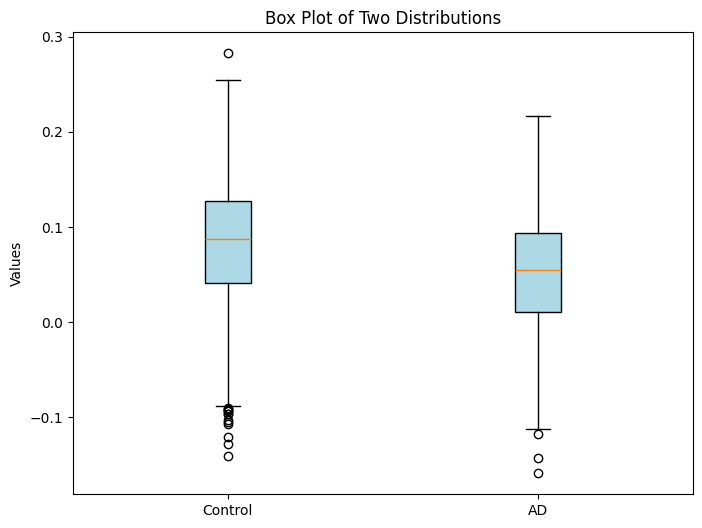

T-statistic: -22.0340832173955
P-value: 1.0011509311834254e-100


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


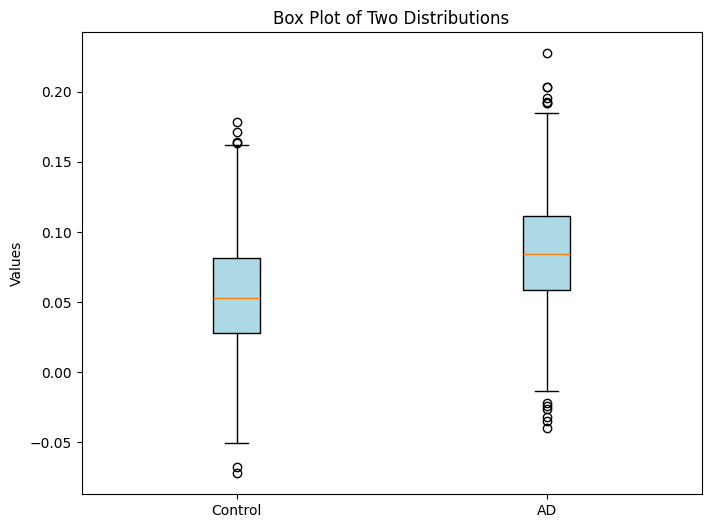

T-statistic: -22.22948178477836
P-value: 2.2605630903255102e-102


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


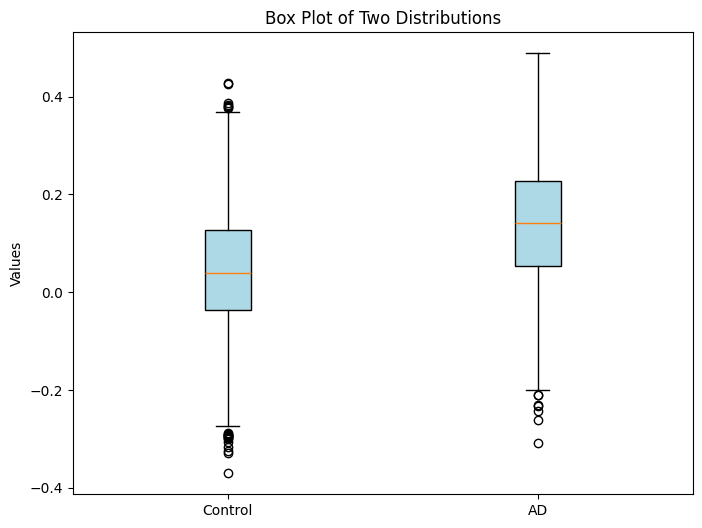

T-statistic: 11.601166791602562
P-value: 1.5048042179333702e-30


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


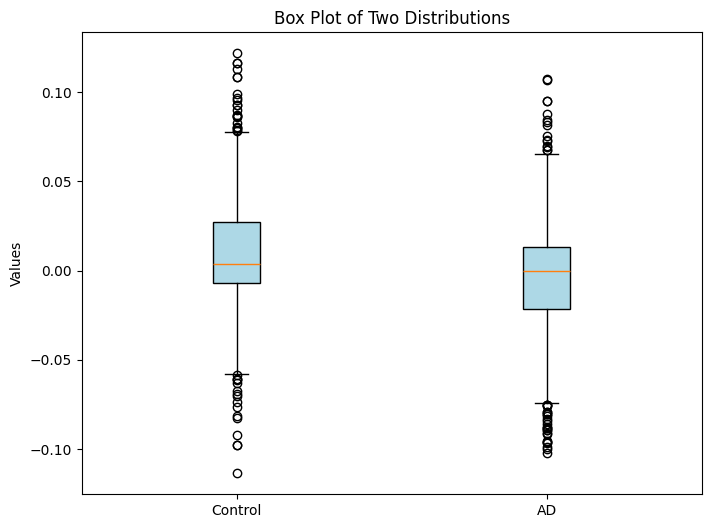

T-statistic: -11.8741944896227
P-value: 6.760737614584005e-32


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


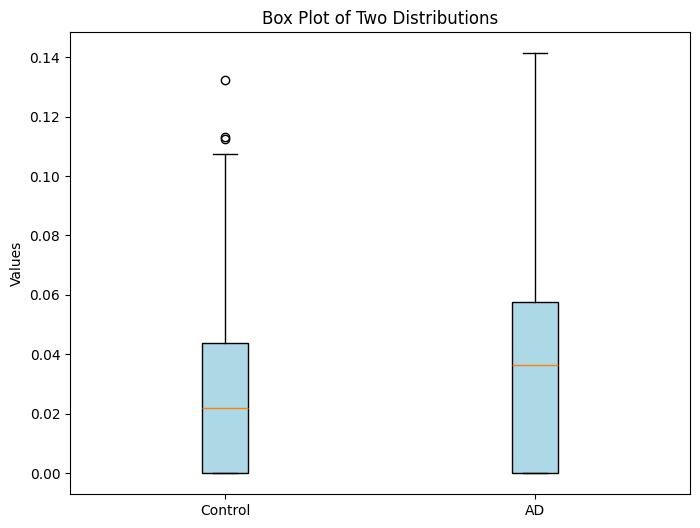

T-statistic: 40.03888256501207
P-value: 7.503942463309653e-288


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


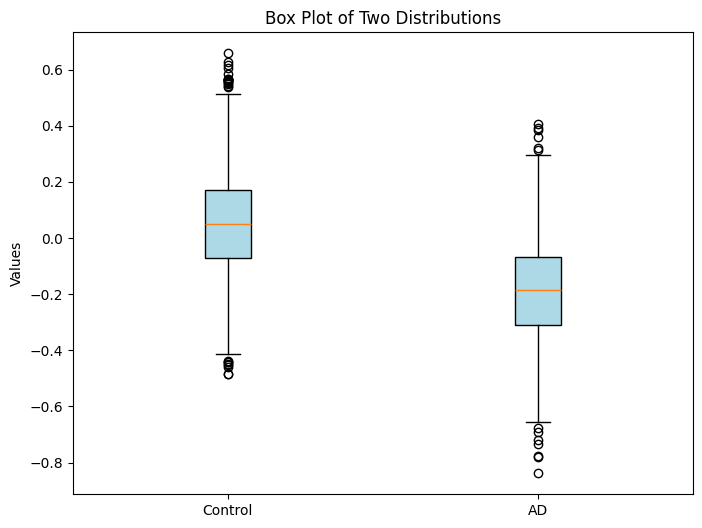

T-statistic: -39.28104102347953
P-value: 6.6601486653465e-279


/tmp/ipykernel_2219947/2340050927.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True,


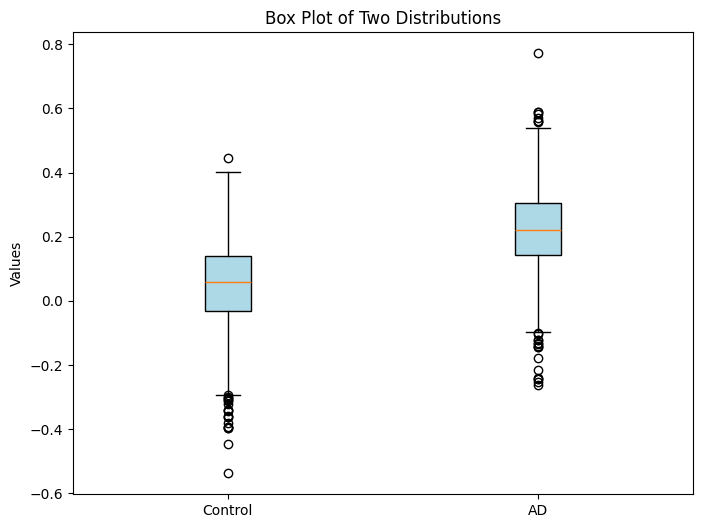

In [773]:
pathways_list = []
p_value_list = []

for i in correct_predicted_layer_1_df_Control.columns:
    t_stat, p_value = stats.ttest_ind(correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist())
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")

    plt.figure(figsize=(8, 6))
    plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True, 
                boxprops=dict(facecolor='lightblue'))
    
    # Add title and labels
    plt.title('Box Plot of Two Distributions')
    plt.ylabel('Values')
    pathways_list.append(i)
    p_value_list.append(p_value)
    # Display the plot
    plt.show()
    
    

In [781]:
pd.DataFrame(pathways_list, p_value_list)

0
8.977615e-10   R-HSA-9753281
2.132657e-103    R-HSA-71387
1.114416e-82    R-HSA-450531
7.354051e-71    R-HSA-391251
2.070103e-121    R-HSA-69620
...                      ...
2.260563e-102   R-HSA-157118
1.504804e-30    R-HSA-382556
6.760738e-32   R-HSA-1181150
7.503942e-288  R-HSA-5663205
6.660149e-279  R-HSA-2262752

[134 rows x 1 columns]

In [672]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_3_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 523034.99it/s]


In [688]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_4_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i)) 
layer_2_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_2'])

li = []
for i in layer_dict['layer_3']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 430269.60it/s]


# layer_2_df

# Plots